In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Mounted at /content/drive/


### Reading data

In [7]:
data1 = pd.read_csv('../../data/stock_week.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [9]:
data1.head()

,StockCode,week_start,Quantity,Price,holiday
0,20677,2010-05-31,96.000000,1.583599,-1.0
1,20677,2010-06-07,10.500000,1.583599,-1.0
2,20677,2010-06-14,32.000000,1.583599,-1.0
3,20677,2010-06-21,30.833333,1.583599,-1.0
4,20677,2010-06-28,123.666667,1.583599,-1.0


In [10]:
data1['ds'] = pd.to_datetime(data1['week_start'])

In [11]:
data1.drop(['week_start'],axis=1,inplace=True)

# creating date related feature

In [12]:
def weekinmonth(x):
  x = pd.to_datetime(x)
  fdom = x.day // 7
  return fdom
data1['wom'] = data1['ds'].apply(weekinmonth)
data1['year'] = data1['ds'].dt.year
data1['week_no'] = data1['ds'].dt.week
# data1['month'] = data1['ds'].dt.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [13]:
data1 = data1.loc[data1['year'] >= 2010,]

In [14]:
data1.shape

(305914, 8)

In [15]:
dtgc = data1.copy()

In [16]:
dtgc.head()

,StockCode,Quantity,Price,holiday,ds,wom,year,week_no
0,20677,96.000000,1.583599,-1.0,2010-05-31,4,2010,22
1,20677,10.500000,1.583599,-1.0,2010-06-07,1,2010,23
2,20677,32.000000,1.583599,-1.0,2010-06-14,2,2010,24
3,20677,30.833333,1.583599,-1.0,2010-06-21,3,2010,25
4,20677,123.666667,1.583599,-1.0,2010-06-28,4,2010,26


In [17]:
dtgc.shape

(305914, 8)

In [18]:
dtgc['timeelapsed'] = dtgc.groupby(['StockCode'])[['ds']].shift(1)

In [19]:
dtgc['timeelapsed'] = (dtgc['ds'].sub(dtgc['timeelapsed'],axis=0).dt.days//7).fillna(1)

In [20]:
dtgc.min()

Quantity                         0
Price                    0.0514286
holiday                         -1
ds             2010-01-04 00:00:00
wom                              0
year                          2010
week_no                          1
timeelapsed                      0
dtype: object

# cumulative Zero and average interval

In [21]:
dtgc['cumsum'] = dtgc.groupby(['StockCode'])['Quantity'].cumsum()

In [22]:
dtgc['cumdist'] = dtgc.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1

In [23]:
averagedistance = dtgc.groupby(['StockCode'])['cumdist'].mean().reset_index().rename(columns={'cumdist':'averagedistance'})

In [24]:
averagedistance.head()

,StockCode,averagedistance
0,20677,0.013333
1,20679,0.000000
2,20681,1.906250
3,20682,0.041667
4,20684,0.864583


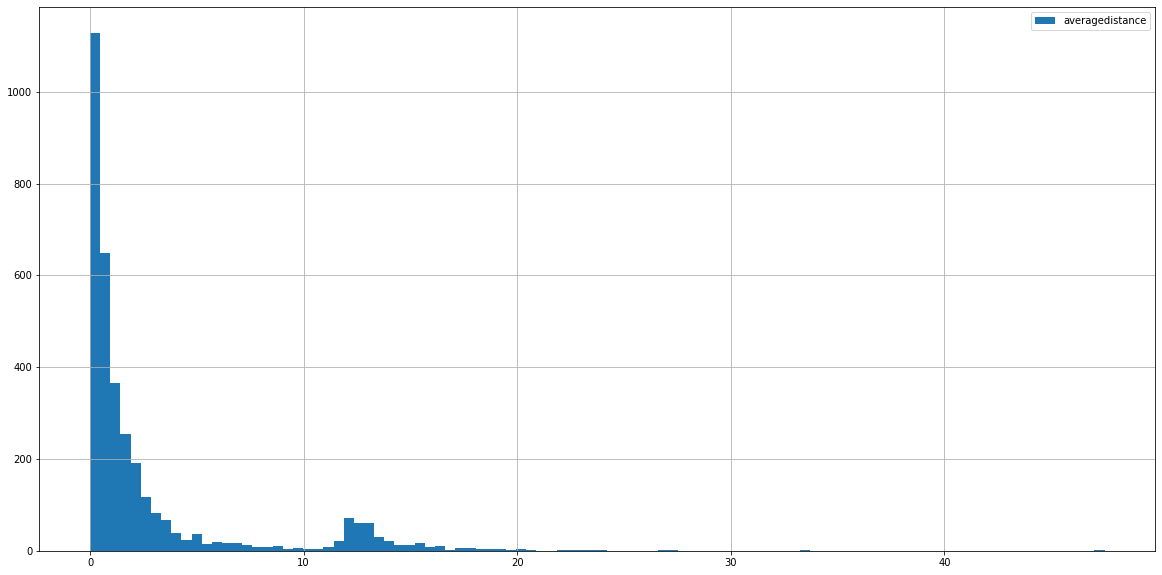

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
averagedistance['averagedistance'].hist(bins=100,legend='average _interval',ax=ax)

In [26]:
dtgc = dtgc.merge(averagedistance,on=['StockCode'],how='left')

In [27]:
dtgc.head()

,StockCode,Quantity,Price,holiday,ds,wom,year,week_no,timeelapsed,cumsum,cumdist,averagedistance
0,20677,96.000000,1.583599,-1.0,2010-05-31,4,2010,22,1.0,96.000000,0.0,0.013333
1,20677,10.500000,1.583599,-1.0,2010-06-07,1,2010,23,1.0,106.500000,0.0,0.013333
2,20677,32.000000,1.583599,-1.0,2010-06-14,2,2010,24,1.0,138.500000,0.0,0.013333
3,20677,30.833333,1.583599,-1.0,2010-06-21,3,2010,25,1.0,169.333333,0.0,0.013333
4,20677,123.666667,1.583599,-1.0,2010-06-28,4,2010,26,1.0,293.000000,0.0,0.013333


# data scaling by each stock, Avoided standard scaling to save time

In [28]:
mu = data1.groupby(['StockCode'])['Quantity'].mean().reset_index()
mu = mu.rename(columns={'Quantity':'mean'})
std = dtgc.groupby(['StockCode'])['Quantity'].std().reset_index()
std = std.rename(columns={'Quantity':'std'})
data1 = dtgc.merge(mu,on=['StockCode'],how='left')
data1 = data1.merge(std,on=['StockCode'],how='left')
data1['tQuantity'] = (data1['Quantity'] - data1['mean'])/(data1['std'])
data = data1.copy()
data['lag1'] = data.groupby('StockCode')['tQuantity'].shift(1)
data['lag4'] = data.groupby('StockCode')['tQuantity'].shift(4)
data['lag52'] = data.groupby('StockCode')['tQuantity'].shift(52)


In [29]:
data.isnull().sum()

StockCode               0
Quantity                0
Price                   0
holiday               612
ds                      0
wom                     0
year                    0
week_no                 0
timeelapsed             0
cumsum                  0
cumdist                 0
averagedistance         0
mean                    0
std                     0
tQuantity              96
lag1                 3553
lag4                13924
lag52              175218
dtype: int64

In [30]:
data.fillna(-1,inplace = True)

# train validation and split test

In [31]:
max_date = pd.to_datetime(data['ds']).max()
mx1_dt = (max_date - pd.to_timedelta(7, unit='w'))

In [32]:
data['ds'] = pd.to_datetime(data['ds'])
train = data.loc[data['ds'] <= mx1_dt,]

In [33]:
val = data.loc[data['ds'] > mx1_dt,]
val_f = val[[x for x in val.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
val_f.index = val['ds']
val_f = val_f.drop(['ds'],axis=1)

In [34]:
train_f = train[[x for x in train.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
train_f.index = train.ds
train_f = train_f.drop(['ds'],axis=1)

In [35]:
mx_dt = (train['ds'].max() - pd.to_timedelta(6, unit='w'))

In [36]:
train1 = train.loc[train['ds'] <= mx_dt,]
train1.index = train1['ds']
train1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
val1 = train.loc[train['ds'] >  mx_dt,]

In [38]:
val1.index = val1['ds']
val1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
test = data.loc[data['ds'] > val1.index.max(),]
test.index = test['ds']
test.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
train_x = train1[[x for x in train1.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
train_y = train1['tQuantity']

# installing required package

In [41]:
! pip install category_encoders

     |████████████████████████████████| 81kB 3.1MB/s 


####### data transformation

In [42]:
import category_encoders as ce
id_encoder =  ce.OrdinalEncoder()
id_encoder.fit(train_x['StockCode'])
train_x['id_cat'] = id_encoder.transform(train_x['StockCode'])
train_x1 = train_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [43]:
val_x = val1[[x for x in val1.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
val_y = val1['tQuantity']

In [44]:
val_x['id_cat'] = id_encoder.transform(val_x['StockCode'])
val_x1 = val_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
test_x = test[[x for x in test.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
test_x['id_cat'] = id_encoder.transform(test_x['StockCode'])
test_x1 = test_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
train_f['id_cat'] = id_encoder.transform(train_f['StockCode'])
train_f = train_f.drop(['StockCode'],axis=1)

In [47]:
train_fy = train['tQuantity']

In [48]:
val_f['id_cat'] = id_encoder.transform(val_f['StockCode'])
val_f.drop(['StockCode'],axis=1,inplace=True)
val_fy = val['tQuantity']

# installing optuna for tuning

In [49]:
! pip install optuna

     |████████████████████████████████| 296kB 5.7MB/s 
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 1.2MB 6.9MB/s 
     |████████████████████████████████| 143kB 9.6MB/s 
     |████████████████████████████████| 112kB 13.5MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 481kB 12.0MB/s 
  Created wheel for alembic: filename=alembic-1.5.5-py2.py3-none-any.whl size=156597 sha256=623be93c3fffef1000a1724bb1a2d911779c45b6cddafb02459e9058c198f0fb
  Stored in directory: /root/.cache/pip/wheels/74/3f/61/7de6e3cef766d2680a5d81b1a388286e640f6a681eb589d643
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=cc28f2be7612661c42895cd0fff75c9f6e6c4defbaa57f486caf67f98ff73f73
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp36-none-any.whl size=11108 sha256=8a

# tuning model

In [50]:
import optuna
import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import LightGBMTuner

In [51]:
params = {
    'objective': 'regression',
    'boosting_type':'gbdt',
    "eval_metric":'mse',
    'metric':'mse'
}

In [52]:
train_x1.columns.tolist()

['Price',
 'holiday',
 'wom',
 'year',
 'week_no',
 'cumdist',
 'averagedistance',
 'std',
 'lag1',
 'lag4',
 'lag52',
 'id_cat']

In [53]:
categorical_feature = ['week_no','wom','id_cat']

In [54]:
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [55]:
tuned_model = LightGBMTuner(params, train_set=lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=300,
                                     early_stopping_rounds=30,
                                    )

[I 2021-02-22 15:42:34,530] A new study created in memory with name: no-name-1a8f3b0e-e898-48ac-8d99-4a7878a99862


In [56]:
tuned_model.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l2: 0.679768
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676654
[3]	valid_0's l2: 0.671311
[4]	valid_0's l2: 0.651783
[5]	valid_0's l2: 0.647778
[6]	valid_0's l2: 0.647008
[7]	valid_0's l2: 0.632308
[8]	valid_0's l2: 0.631331
[9]	valid_0's l2: 0.630188
[10]	valid_0's l2: 0.630478
[11]	valid_0's l2: 0.62867
[12]	valid_0's l2: 0.626731
[13]	valid_0's l2: 0.625659
[14]	valid_0's l2: 0.626295
[15]	valid_0's l2: 0.62494
[16]	valid_0's l2: 0.614896
[17]	valid_0's l2: 0.613618
[18]	valid_0's l2: 0.613668
[19]	valid_0's l2: 0.604038
[20]	valid_0's l2: 0.603056
[21]	valid_0's l2: 0.595812
[22]	valid_0's l2: 0.595668
[23]	valid_0's l2: 0.591365
[24]	valid_0's l2: 0.58707
[25]	valid_0's l2: 0.586716
[26]	valid_0's l2: 0.582951
[27]	valid_0's l2: 0.579173
[28]	valid_0's l2: 0.578563
[29]	valid_0's l2: 0.574836
[30]	valid_0's l2: 0.575434
[31]	valid_0's l2: 0.5732
[32]	valid_0's l2: 0.573013
[33]	valid_0's l2: 0.571853
[34]	valid_0's l2: 0.571681


feature_fraction, val_score: 0.556149:  14%|#4        | 1/7 [00:03<00:18,  3.03s/it]

[144]	valid_0's l2: 0.557495
[145]	valid_0's l2: 0.557506
[146]	valid_0's l2: 0.557555
[147]	valid_0's l2: 0.558007
[148]	valid_0's l2: 0.557966
[149]	valid_0's l2: 0.557982
[150]	valid_0's l2: 0.558015
[151]	valid_0's l2: 0.557859
Early stopping, best iteration is:
[121]	valid_0's l2: 0.556149
[1]	valid_0's l2: 0.680757
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.675601
[3]	valid_0's l2: 0.651594
[4]	valid_0's l2: 0.632042
[5]	valid_0's l2: 0.615171
[6]	valid_0's l2: 0.615611
[7]	valid_0's l2: 0.602764
[8]	valid_0's l2: 0.593011
[9]	valid_0's l2: 0.584018
[10]	valid_0's l2: 0.577661
[11]	valid_0's l2: 0.57211
[12]	valid_0's l2: 0.567237
[13]	valid_0's l2: 0.56653
[14]	valid_0's l2: 0.56238
[15]	valid_0's l2: 0.559415
[16]	valid_0's l2: 0.55718
[17]	valid_0's l2: 0.555457
[18]	valid_0's l2: 0.553595
[19]	valid_0's l2: 0.552362
[20]	valid_0's l2: 0.552652
[21]	valid_0's l2: 0.551542
[22]	valid_0's l2: 0.550129
[23]	valid_0's l2: 0.549663
[24]	valid_

feature_fraction, val_score: 0.548220:  29%|##8       | 2/7 [00:04<00:13,  2.69s/it]

[59]	valid_0's l2: 0.549146
[60]	valid_0's l2: 0.548764
Early stopping, best iteration is:
[30]	valid_0's l2: 0.54822
[1]	valid_0's l2: 0.680173
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674988
[3]	valid_0's l2: 0.651562
[4]	valid_0's l2: 0.631782
[5]	valid_0's l2: 0.614941
[6]	valid_0's l2: 0.602977
[7]	valid_0's l2: 0.591185
[8]	valid_0's l2: 0.582832
[9]	valid_0's l2: 0.576156
[10]	valid_0's l2: 0.570554
[11]	valid_0's l2: 0.565634
[12]	valid_0's l2: 0.561836
[13]	valid_0's l2: 0.56175
[14]	valid_0's l2: 0.558314
[15]	valid_0's l2: 0.555516
[16]	valid_0's l2: 0.553212
[17]	valid_0's l2: 0.552026
[18]	valid_0's l2: 0.550831
[19]	valid_0's l2: 0.550057
[20]	valid_0's l2: 0.549895
[21]	valid_0's l2: 0.549336
[22]	valid_0's l2: 0.548553
[23]	valid_0's l2: 0.549536
[24]	valid_0's l2: 0.548921
[25]	valid_0's l2: 0.548927
[26]	valid_0's l2: 0.549284
[27]	valid_0's l2: 0.549396
[28]	valid_0's l2: 0.549046
[29]	valid_0's l2: 0.548834
[30]	valid_0's l2:

feature_fraction, val_score: 0.548220:  29%|##8       | 2/7 [00:06<00:13,  2.69s/it]

[44]	valid_0's l2: 0.550301
[45]	valid_0's l2: 0.550713
[46]	valid_0's l2: 0.550726
[47]	valid_0's l2: 0.551278
[48]	valid_0's l2: 0.551174
[49]	valid_0's l2: 0.551363
[50]	valid_0's l2: 0.551688
[51]	valid_0's l2: 0.551479
[52]	valid_0's l2: 0.551242
Early stopping, best iteration is:
[22]	valid_0's l2: 0.548553


feature_fraction, val_score: 0.548220:  43%|####2     | 3/7 [00:06<00:09,  2.45s/it]

[1]	valid_0's l2: 0.703802
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.699632
[3]	valid_0's l2: 0.669951
[4]	valid_0's l2: 0.648037
[5]	valid_0's l2: 0.647154
[6]	valid_0's l2: 0.645958
[7]	valid_0's l2: 0.631409
[8]	valid_0's l2: 0.616265
[9]	valid_0's l2: 0.603436
[10]	valid_0's l2: 0.596095
[11]	valid_0's l2: 0.595321
[12]	valid_0's l2: 0.586167
[13]	valid_0's l2: 0.587342
[14]	valid_0's l2: 0.581268
[15]	valid_0's l2: 0.575217
[16]	valid_0's l2: 0.570485
[17]	valid_0's l2: 0.571348
[18]	valid_0's l2: 0.567557
[19]	valid_0's l2: 0.563681
[20]	valid_0's l2: 0.563608
[21]	valid_0's l2: 0.561956
[22]	valid_0's l2: 0.559844
[23]	valid_0's l2: 0.558489
[24]	valid_0's l2: 0.557495
[25]	valid_0's l2: 0.556475
[26]	valid_0's l2: 0.556652
[27]	valid_0's l2: 0.556891
[28]	valid_0's l2: 0.55566
[29]	valid_0's l2: 0.554609
[30]	valid_0's l2: 0.553005
[31]	valid_0's l2: 0.553885
[32]	valid_0's l2: 0.554604
[33]	valid_0's l2: 0.555442
[34]	valid_0's l2: 0.555

feature_fraction, val_score: 0.548220:  57%|#####7    | 4/7 [00:08<00:07,  2.36s/it]

[78]	valid_0's l2: 0.552914
[79]	valid_0's l2: 0.553087
[80]	valid_0's l2: 0.553292
[81]	valid_0's l2: 0.553424
[82]	valid_0's l2: 0.553268
[83]	valid_0's l2: 0.553101
[84]	valid_0's l2: 0.552997
Early stopping, best iteration is:
[54]	valid_0's l2: 0.551632
[1]	valid_0's l2: 0.68021
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.655683
[3]	valid_0's l2: 0.635314
[4]	valid_0's l2: 0.617733
[5]	valid_0's l2: 0.603332
[6]	valid_0's l2: 0.593208
[7]	valid_0's l2: 0.584416
[8]	valid_0's l2: 0.576459
[9]	valid_0's l2: 0.571075
[10]	valid_0's l2: 0.567057
[11]	valid_0's l2: 0.562838
[12]	valid_0's l2: 0.560046
[13]	valid_0's l2: 0.557748
[14]	valid_0's l2: 0.555433
[15]	valid_0's l2: 0.553246
[16]	valid_0's l2: 0.551469
[17]	valid_0's l2: 0.551004
[18]	valid_0's l2: 0.551342
[19]	valid_0's l2: 0.550824
[20]	valid_0's l2: 0.550024
[21]	valid_0's l2: 0.549551
[22]	valid_0's l2: 0.549216
[23]	valid_0's l2: 0.549468
[24]	valid_0's l2: 0.54891
[25]	valid_0's l2:

feature_fraction, val_score: 0.548220:  71%|#######1  | 5/7 [00:11<00:04,  2.27s/it]

[49]	valid_0's l2: 0.551586
[50]	valid_0's l2: 0.551616
[51]	valid_0's l2: 0.551751
[52]	valid_0's l2: 0.551884
[53]	valid_0's l2: 0.552059
[54]	valid_0's l2: 0.552285
Early stopping, best iteration is:
[24]	valid_0's l2: 0.54891
[1]	valid_0's l2: 0.680228
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.675837
[3]	valid_0's l2: 0.650498
[4]	valid_0's l2: 0.631921
[5]	valid_0's l2: 0.632998
[6]	valid_0's l2: 0.632967
[7]	valid_0's l2: 0.617765
[8]	valid_0's l2: 0.605384
[9]	valid_0's l2: 0.593462
[10]	valid_0's l2: 0.585001
[11]	valid_0's l2: 0.577936
[12]	valid_0's l2: 0.572325
[13]	valid_0's l2: 0.572029
[14]	valid_0's l2: 0.567641
[15]	valid_0's l2: 0.563671
[16]	valid_0's l2: 0.560652
[17]	valid_0's l2: 0.558323
[18]	valid_0's l2: 0.556161
[19]	valid_0's l2: 0.553678
[20]	valid_0's l2: 0.554104
[21]	valid_0's l2: 0.55379
[22]	valid_0's l2: 0.552824
[23]	valid_0's l2: 0.551996
[24]	valid_0's l2: 0.551655
[25]	valid_0's l2: 0.550522
[26]	valid_0's l2:

feature_fraction, val_score: 0.548220:  71%|#######1  | 5/7 [00:13<00:04,  2.27s/it]

[56]	valid_0's l2: 0.549962
[57]	valid_0's l2: 0.549913
[58]	valid_0's l2: 0.5498
[59]	valid_0's l2: 0.550151
[60]	valid_0's l2: 0.549975
Early stopping, best iteration is:
[30]	valid_0's l2: 0.54873


feature_fraction, val_score: 0.548220:  86%|########5 | 6/7 [00:13<00:02,  2.22s/it]

[1]	valid_0's l2: 0.678956
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.654412
[3]	valid_0's l2: 0.635158
[4]	valid_0's l2: 0.61919
[5]	valid_0's l2: 0.606229
[6]	valid_0's l2: 0.596889
[7]	valid_0's l2: 0.589245
[8]	valid_0's l2: 0.582242
[9]	valid_0's l2: 0.575954
[10]	valid_0's l2: 0.572778
[11]	valid_0's l2: 0.570631
[12]	valid_0's l2: 0.567766
[13]	valid_0's l2: 0.566371
[14]	valid_0's l2: 0.565271
[15]	valid_0's l2: 0.564735
[16]	valid_0's l2: 0.563768
[17]	valid_0's l2: 0.56309
[18]	valid_0's l2: 0.563362
[19]	valid_0's l2: 0.56161
[20]	valid_0's l2: 0.561818
[21]	valid_0's l2: 0.561181
[22]	valid_0's l2: 0.561518
[23]	valid_0's l2: 0.559721
[24]	valid_0's l2: 0.56013
[25]	valid_0's l2: 0.560368
[26]	valid_0's l2: 0.560628
[27]	valid_0's l2: 0.559804
[28]	valid_0's l2: 0.560199
[29]	valid_0's l2: 0.560227
[30]	valid_0's l2: 0.559613
[31]	valid_0's l2: 0.559519
[32]	valid_0's l2: 0.559593
[33]	valid_0's l2: 0.559557
[34]	valid_0's l2: 0.559648

num_leaves, val_score: 0.548220:   0%|          | 0/20 [00:00<?, ?it/s]

[75]	valid_0's l2: 0.561149
[76]	valid_0's l2: 0.561207
[77]	valid_0's l2: 0.561388
[78]	valid_0's l2: 0.561409
[79]	valid_0's l2: 0.561074
[80]	valid_0's l2: 0.561186
[81]	valid_0's l2: 0.561209
[82]	valid_0's l2: 0.561262
[83]	valid_0's l2: 0.561285
Early stopping, best iteration is:
[53]	valid_0's l2: 0.55846
[1]	valid_0's l2: 0.680084
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674576
[3]	valid_0's l2: 0.650522
[4]	valid_0's l2: 0.630957
[5]	valid_0's l2: 0.615038
[6]	valid_0's l2: 0.614705
[7]	valid_0's l2: 0.601951
[8]	valid_0's l2: 0.592214
[9]	valid_0's l2: 0.583065
[10]	valid_0's l2: 0.576284
[11]	valid_0's l2: 0.570478
[12]	valid_0's l2: 0.566301
[13]	valid_0's l2: 0.565859
[14]	valid_0's l2: 0.562152
[15]	valid_0's l2: 0.559782
[16]	valid_0's l2: 0.557465
[17]	valid_0's l2: 0.55586
[18]	valid_0's l2: 0.553978
[19]	valid_0's l2: 0.55324
[20]	valid_0's l2: 0.554431
[21]	valid_0's l2: 0.554001
[22]	valid_0's l2: 0.552839
[23]	valid_0's l2: 

num_leaves, val_score: 0.548220:   5%|5         | 1/20 [00:03<01:11,  3.74s/it]

[57]	valid_0's l2: 0.55476
[58]	valid_0's l2: 0.55593
[59]	valid_0's l2: 0.556032
[60]	valid_0's l2: 0.555217
Early stopping, best iteration is:
[30]	valid_0's l2: 0.552565
[1]	valid_0's l2: 0.680367
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674921
[3]	valid_0's l2: 0.650196
[4]	valid_0's l2: 0.631137
[5]	valid_0's l2: 0.614811
[6]	valid_0's l2: 0.614418
[7]	valid_0's l2: 0.601659
[8]	valid_0's l2: 0.591831
[9]	valid_0's l2: 0.582845
[10]	valid_0's l2: 0.576109
[11]	valid_0's l2: 0.570524
[12]	valid_0's l2: 0.56638
[13]	valid_0's l2: 0.566462
[14]	valid_0's l2: 0.562681
[15]	valid_0's l2: 0.559842
[16]	valid_0's l2: 0.557532
[17]	valid_0's l2: 0.556224
[18]	valid_0's l2: 0.554391
[19]	valid_0's l2: 0.553726
[20]	valid_0's l2: 0.554819
[21]	valid_0's l2: 0.554349
[22]	valid_0's l2: 0.552344
[23]	valid_0's l2: 0.551971
[24]	valid_0's l2: 0.551724
[25]	valid_0's l2: 0.551852
[26]	valid_0's l2: 0.552313
[27]	valid_0's l2: 0.552838
[28]	valid_0's l2: 

num_leaves, val_score: 0.548220:  10%|#         | 2/20 [00:06<01:03,  3.52s/it]

[1]	valid_0's l2: 0.679604
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.673961
[3]	valid_0's l2: 0.649728
[4]	valid_0's l2: 0.629857
[5]	valid_0's l2: 0.613819
[6]	valid_0's l2: 0.613415
[7]	valid_0's l2: 0.600569
[8]	valid_0's l2: 0.590827
[9]	valid_0's l2: 0.581752
[10]	valid_0's l2: 0.575034
[11]	valid_0's l2: 0.569601
[12]	valid_0's l2: 0.565779
[13]	valid_0's l2: 0.566044
[14]	valid_0's l2: 0.56245
[15]	valid_0's l2: 0.560529
[16]	valid_0's l2: 0.558335
[17]	valid_0's l2: 0.557235
[18]	valid_0's l2: 0.555357
[19]	valid_0's l2: 0.554414
[20]	valid_0's l2: 0.555095
[21]	valid_0's l2: 0.554104
[22]	valid_0's l2: 0.553774
[23]	valid_0's l2: 0.553896
[24]	valid_0's l2: 0.553754
[25]	valid_0's l2: 0.553726
[26]	valid_0's l2: 0.554801
[27]	valid_0's l2: 0.555847
[28]	valid_0's l2: 0.555787
[29]	valid_0's l2: 0.555744
[30]	valid_0's l2: 0.555216
[31]	valid_0's l2: 0.55681
[32]	valid_0's l2: 0.557832
[33]	valid_0's l2: 0.55798
[34]	valid_0's l2: 0.55801

num_leaves, val_score: 0.548220:  15%|#5        | 3/20 [00:10<01:00,  3.56s/it]

[50]	valid_0's l2: 0.561279
[51]	valid_0's l2: 0.561207
[52]	valid_0's l2: 0.561354
[53]	valid_0's l2: 0.561982
[54]	valid_0's l2: 0.561887
[55]	valid_0's l2: 0.562047
Early stopping, best iteration is:
[25]	valid_0's l2: 0.553726
[1]	valid_0's l2: 0.680381
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674829
[3]	valid_0's l2: 0.650106
[4]	valid_0's l2: 0.630363
[5]	valid_0's l2: 0.614404
[6]	valid_0's l2: 0.613999
[7]	valid_0's l2: 0.601541
[8]	valid_0's l2: 0.591946
[9]	valid_0's l2: 0.583378
[10]	valid_0's l2: 0.576714
[11]	valid_0's l2: 0.570967
[12]	valid_0's l2: 0.566844
[13]	valid_0's l2: 0.566273
[14]	valid_0's l2: 0.562268
[15]	valid_0's l2: 0.559449
[16]	valid_0's l2: 0.557084
[17]	valid_0's l2: 0.555481
[18]	valid_0's l2: 0.553463
[19]	valid_0's l2: 0.552364
[20]	valid_0's l2: 0.553558
[21]	valid_0's l2: 0.552952
[22]	valid_0's l2: 0.551697
[23]	valid_0's l2: 0.551776
[24]	valid_0's l2: 0.551382
[25]	valid_0's l2: 0.551577
[26]	valid_0's l

num_leaves, val_score: 0.548220:  20%|##        | 4/20 [00:13<00:55,  3.46s/it]

[58]	valid_0's l2: 0.554663
[59]	valid_0's l2: 0.554766
[60]	valid_0's l2: 0.554478
Early stopping, best iteration is:
[30]	valid_0's l2: 0.551353
[1]	valid_0's l2: 0.681387
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676444
[3]	valid_0's l2: 0.652389
[4]	valid_0's l2: 0.633431
[5]	valid_0's l2: 0.616549
[6]	valid_0's l2: 0.616114
[7]	valid_0's l2: 0.602974
[8]	valid_0's l2: 0.593435
[9]	valid_0's l2: 0.584863
[10]	valid_0's l2: 0.577834
[11]	valid_0's l2: 0.571906
[12]	valid_0's l2: 0.566757
[13]	valid_0's l2: 0.566968
[14]	valid_0's l2: 0.562696
[15]	valid_0's l2: 0.55949
[16]	valid_0's l2: 0.557136
[17]	valid_0's l2: 0.555667
[18]	valid_0's l2: 0.553734
[19]	valid_0's l2: 0.552537
[20]	valid_0's l2: 0.552744
[21]	valid_0's l2: 0.551832
[22]	valid_0's l2: 0.551083
[23]	valid_0's l2: 0.550466
[24]	valid_0's l2: 0.550348
[25]	valid_0's l2: 0.549702
[26]	valid_0's l2: 0.549741
[27]	valid_0's l2: 0.55001
[28]	valid_0's l2: 0.549871
[29]	valid_0's l2:

num_leaves, val_score: 0.546764:  25%|##5       | 5/20 [00:15<00:45,  3.05s/it]

[98]	valid_0's l2: 0.548002
[99]	valid_0's l2: 0.548005
Early stopping, best iteration is:
[69]	valid_0's l2: 0.546764
[1]	valid_0's l2: 0.679831
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674385
[3]	valid_0's l2: 0.650251
[4]	valid_0's l2: 0.630308
[5]	valid_0's l2: 0.614055
[6]	valid_0's l2: 0.613618
[7]	valid_0's l2: 0.600766
[8]	valid_0's l2: 0.591216
[9]	valid_0's l2: 0.582157
[10]	valid_0's l2: 0.57518
[11]	valid_0's l2: 0.569524
[12]	valid_0's l2: 0.565553
[13]	valid_0's l2: 0.5657
[14]	valid_0's l2: 0.561858
[15]	valid_0's l2: 0.559236
[16]	valid_0's l2: 0.55671
[17]	valid_0's l2: 0.555305
[18]	valid_0's l2: 0.553366
[19]	valid_0's l2: 0.552574
[20]	valid_0's l2: 0.553424
[21]	valid_0's l2: 0.552727
[22]	valid_0's l2: 0.551133
[23]	valid_0's l2: 0.550924
[24]	valid_0's l2: 0.550759
[25]	valid_0's l2: 0.550702
[26]	valid_0's l2: 0.551759
[27]	valid_0's l2: 0.552546
[28]	valid_0's l2: 0.552442
[29]	valid_0's l2: 0.552475
[30]	valid_0's l2: 0

num_leaves, val_score: 0.546764:  30%|###       | 6/20 [00:19<00:44,  3.19s/it]

[55]	valid_0's l2: 0.556454
Early stopping, best iteration is:
[25]	valid_0's l2: 0.550702
[1]	valid_0's l2: 0.680394
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674913
[3]	valid_0's l2: 0.650559
[4]	valid_0's l2: 0.630646
[5]	valid_0's l2: 0.61398
[6]	valid_0's l2: 0.613845
[7]	valid_0's l2: 0.601094
[8]	valid_0's l2: 0.591591
[9]	valid_0's l2: 0.583317
[10]	valid_0's l2: 0.576703
[11]	valid_0's l2: 0.571135
[12]	valid_0's l2: 0.566786
[13]	valid_0's l2: 0.566293
[14]	valid_0's l2: 0.562506
[15]	valid_0's l2: 0.559791
[16]	valid_0's l2: 0.557274
[17]	valid_0's l2: 0.55599
[18]	valid_0's l2: 0.554034
[19]	valid_0's l2: 0.552851
[20]	valid_0's l2: 0.553945
[21]	valid_0's l2: 0.552826
[22]	valid_0's l2: 0.551894
[23]	valid_0's l2: 0.55156
[24]	valid_0's l2: 0.551241
[25]	valid_0's l2: 0.551417
[26]	valid_0's l2: 0.55148
[27]	valid_0's l2: 0.552239
[28]	valid_0's l2: 0.551757
[29]	valid_0's l2: 0.551845
[30]	valid_0's l2: 0.551568
[31]	valid_0's l2: 0

num_leaves, val_score: 0.546764:  35%|###5      | 7/20 [00:21<00:39,  3.03s/it]

[54]	valid_0's l2: 0.552565
Early stopping, best iteration is:
[24]	valid_0's l2: 0.551241
[1]	valid_0's l2: 0.680601
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.675474
[3]	valid_0's l2: 0.651199
[4]	valid_0's l2: 0.63179
[5]	valid_0's l2: 0.615061
[6]	valid_0's l2: 0.614542
[7]	valid_0's l2: 0.601993
[8]	valid_0's l2: 0.592353
[9]	valid_0's l2: 0.584061
[10]	valid_0's l2: 0.577658
[11]	valid_0's l2: 0.571797
[12]	valid_0's l2: 0.567113
[13]	valid_0's l2: 0.566591
[14]	valid_0's l2: 0.562386
[15]	valid_0's l2: 0.559551
[16]	valid_0's l2: 0.556716
[17]	valid_0's l2: 0.555249
[18]	valid_0's l2: 0.553482
[19]	valid_0's l2: 0.552069
[20]	valid_0's l2: 0.55308
[21]	valid_0's l2: 0.55235
[22]	valid_0's l2: 0.551153
[23]	valid_0's l2: 0.550893
[24]	valid_0's l2: 0.550687
[25]	valid_0's l2: 0.5508
[26]	valid_0's l2: 0.551485
[27]	valid_0's l2: 0.552271
[28]	valid_0's l2: 0.551979
[29]	valid_0's l2: 0.551614
[30]	valid_0's l2: 0.550495
[31]	valid_0's l2: 0.

num_leaves, val_score: 0.546764:  40%|####      | 8/20 [00:24<00:34,  2.90s/it]

[59]	valid_0's l2: 0.553169
[60]	valid_0's l2: 0.553001
Early stopping, best iteration is:
[30]	valid_0's l2: 0.550495
[1]	valid_0's l2: 0.679689
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674137
[3]	valid_0's l2: 0.649762
[4]	valid_0's l2: 0.62994
[5]	valid_0's l2: 0.61372
[6]	valid_0's l2: 0.613171
[7]	valid_0's l2: 0.60051
[8]	valid_0's l2: 0.590775
[9]	valid_0's l2: 0.581632
[10]	valid_0's l2: 0.574007
[11]	valid_0's l2: 0.568388
[12]	valid_0's l2: 0.564466
[13]	valid_0's l2: 0.564694
[14]	valid_0's l2: 0.560946
[15]	valid_0's l2: 0.558617
[16]	valid_0's l2: 0.556355
[17]	valid_0's l2: 0.555162
[18]	valid_0's l2: 0.55334
[19]	valid_0's l2: 0.552198
[20]	valid_0's l2: 0.553613
[21]	valid_0's l2: 0.552241
[22]	valid_0's l2: 0.551376
[23]	valid_0's l2: 0.550996
[24]	valid_0's l2: 0.550861
[25]	valid_0's l2: 0.550524
[26]	valid_0's l2: 0.55111
[27]	valid_0's l2: 0.552033
[28]	valid_0's l2: 0.552313
[29]	valid_0's l2: 0.55241
[30]	valid_0's l2: 0.5

num_leaves, val_score: 0.546764:  45%|####5     | 9/20 [00:28<00:34,  3.14s/it]

[55]	valid_0's l2: 0.557507
Early stopping, best iteration is:
[25]	valid_0's l2: 0.550524
[1]	valid_0's l2: 0.680506
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.675177
[3]	valid_0's l2: 0.650779
[4]	valid_0's l2: 0.631175
[5]	valid_0's l2: 0.614497
[6]	valid_0's l2: 0.613893
[7]	valid_0's l2: 0.600854
[8]	valid_0's l2: 0.590885
[9]	valid_0's l2: 0.582443
[10]	valid_0's l2: 0.576274
[11]	valid_0's l2: 0.570754
[12]	valid_0's l2: 0.566418
[13]	valid_0's l2: 0.565969
[14]	valid_0's l2: 0.561817
[15]	valid_0's l2: 0.558972
[16]	valid_0's l2: 0.556741
[17]	valid_0's l2: 0.555268
[18]	valid_0's l2: 0.553367
[19]	valid_0's l2: 0.552259
[20]	valid_0's l2: 0.553182
[21]	valid_0's l2: 0.552368
[22]	valid_0's l2: 0.55134
[23]	valid_0's l2: 0.551331
[24]	valid_0's l2: 0.550983
[25]	valid_0's l2: 0.550759
[26]	valid_0's l2: 0.551307
[27]	valid_0's l2: 0.552435
[28]	valid_0's l2: 0.551969
[29]	valid_0's l2: 0.551802
[30]	valid_0's l2: 0.551065
[31]	valid_0's l2

num_leaves, val_score: 0.546764:  50%|#####     | 10/20 [00:30<00:29,  2.94s/it]

[53]	valid_0's l2: 0.551931
[54]	valid_0's l2: 0.551744
[55]	valid_0's l2: 0.551899
Early stopping, best iteration is:
[25]	valid_0's l2: 0.550759
[1]	valid_0's l2: 0.681291
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676367
[3]	valid_0's l2: 0.653106
[4]	valid_0's l2: 0.63495
[5]	valid_0's l2: 0.618551
[6]	valid_0's l2: 0.61876
[7]	valid_0's l2: 0.605365
[8]	valid_0's l2: 0.595653
[9]	valid_0's l2: 0.586332
[10]	valid_0's l2: 0.579685
[11]	valid_0's l2: 0.574744
[12]	valid_0's l2: 0.570321
[13]	valid_0's l2: 0.570403
[14]	valid_0's l2: 0.566623
[15]	valid_0's l2: 0.564013
[16]	valid_0's l2: 0.561156
[17]	valid_0's l2: 0.559512
[18]	valid_0's l2: 0.55775
[19]	valid_0's l2: 0.556998
[20]	valid_0's l2: 0.557192
[21]	valid_0's l2: 0.557047
[22]	valid_0's l2: 0.555264
[23]	valid_0's l2: 0.554908
[24]	valid_0's l2: 0.554126
[25]	valid_0's l2: 0.553222
[26]	valid_0's l2: 0.553563
[27]	valid_0's l2: 0.553384
[28]	valid_0's l2: 0.552532
[29]	valid_0's l2: 

num_leaves, val_score: 0.546764:  55%|#####5    | 11/20 [00:32<00:23,  2.61s/it]

[84]	valid_0's l2: 0.551195
[85]	valid_0's l2: 0.551134
[86]	valid_0's l2: 0.551264
[87]	valid_0's l2: 0.551315
[88]	valid_0's l2: 0.551415
[89]	valid_0's l2: 0.551568
[90]	valid_0's l2: 0.551663
[91]	valid_0's l2: 0.55181
[92]	valid_0's l2: 0.551559
[93]	valid_0's l2: 0.551735
[94]	valid_0's l2: 0.551931
[95]	valid_0's l2: 0.551868
[96]	valid_0's l2: 0.551793
[97]	valid_0's l2: 0.55186
[98]	valid_0's l2: 0.551911
[99]	valid_0's l2: 0.551782
Early stopping, best iteration is:
[69]	valid_0's l2: 0.549939
[1]	valid_0's l2: 0.681421
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676498
[3]	valid_0's l2: 0.652379
[4]	valid_0's l2: 0.633382
[5]	valid_0's l2: 0.616745
[6]	valid_0's l2: 0.616373
[7]	valid_0's l2: 0.60336
[8]	valid_0's l2: 0.593939
[9]	valid_0's l2: 0.58498
[10]	valid_0's l2: 0.578757
[11]	valid_0's l2: 0.573188
[12]	valid_0's l2: 0.567985
[13]	valid_0's l2: 0.568123
[14]	valid_0's l2: 0.564006
[15]	valid_0's l2: 0.561243
[16]	valid_0's l2: 0

num_leaves, val_score: 0.546764:  60%|######    | 12/20 [00:34<00:19,  2.50s/it]

[86]	valid_0's l2: 0.548298
[87]	valid_0's l2: 0.548279
[88]	valid_0's l2: 0.548437
[89]	valid_0's l2: 0.54843
[90]	valid_0's l2: 0.548534
[91]	valid_0's l2: 0.548664
[92]	valid_0's l2: 0.548418
[93]	valid_0's l2: 0.548425
[94]	valid_0's l2: 0.548366
[95]	valid_0's l2: 0.548355
[96]	valid_0's l2: 0.548352
[97]	valid_0's l2: 0.548314
[98]	valid_0's l2: 0.548507
[99]	valid_0's l2: 0.548484
Early stopping, best iteration is:
[69]	valid_0's l2: 0.546869
[1]	valid_0's l2: 0.684562
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.68232
[3]	valid_0's l2: 0.662123
[4]	valid_0's l2: 0.645257
[5]	valid_0's l2: 0.632937
[6]	valid_0's l2: 0.635052
[7]	valid_0's l2: 0.623042
[8]	valid_0's l2: 0.615096
[9]	valid_0's l2: 0.60888
[10]	valid_0's l2: 0.602042
[11]	valid_0's l2: 0.597939
[12]	valid_0's l2: 0.594699
[13]	valid_0's l2: 0.59439
[14]	valid_0's l2: 0.591819
[15]	valid_0's l2: 0.588394
[16]	valid_0's l2: 0.586752
[17]	valid_0's l2: 0.585939
[18]	valid_0's l2: 0

num_leaves, val_score: 0.546764:  65%|######5   | 13/20 [00:37<00:17,  2.45s/it]

[222]	valid_0's l2: 0.554934
[223]	valid_0's l2: 0.555013
[224]	valid_0's l2: 0.555052
[225]	valid_0's l2: 0.555084
[226]	valid_0's l2: 0.555026
[227]	valid_0's l2: 0.555053
[228]	valid_0's l2: 0.555095
[229]	valid_0's l2: 0.554994
[230]	valid_0's l2: 0.555043
[231]	valid_0's l2: 0.554944
[232]	valid_0's l2: 0.55499
[233]	valid_0's l2: 0.555011
Early stopping, best iteration is:
[203]	valid_0's l2: 0.554912
[1]	valid_0's l2: 0.680975
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.675802
[3]	valid_0's l2: 0.651844
[4]	valid_0's l2: 0.632289
[5]	valid_0's l2: 0.61529
[6]	valid_0's l2: 0.615468
[7]	valid_0's l2: 0.602654
[8]	valid_0's l2: 0.592733
[9]	valid_0's l2: 0.583743
[10]	valid_0's l2: 0.577171
[11]	valid_0's l2: 0.571538
[12]	valid_0's l2: 0.566616
[13]	valid_0's l2: 0.565849
[14]	valid_0's l2: 0.561572
[15]	valid_0's l2: 0.55899
[16]	valid_0's l2: 0.556495
[17]	valid_0's l2: 0.55471
[18]	valid_0's l2: 0.552828
[19]	valid_0's l2: 0.551735
[20]	va

num_leaves, val_score: 0.546764:  70%|#######   | 14/20 [00:39<00:15,  2.53s/it]

[96]	valid_0's l2: 0.548632
[97]	valid_0's l2: 0.548682
[98]	valid_0's l2: 0.54858
[99]	valid_0's l2: 0.548582
[100]	valid_0's l2: 0.548637
[101]	valid_0's l2: 0.548684
[102]	valid_0's l2: 0.548648
[103]	valid_0's l2: 0.548749
[104]	valid_0's l2: 0.54866
[105]	valid_0's l2: 0.548689
[106]	valid_0's l2: 0.548681
[107]	valid_0's l2: 0.548689
Early stopping, best iteration is:
[77]	valid_0's l2: 0.547671
[1]	valid_0's l2: 0.679582
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.673977
[3]	valid_0's l2: 0.649711
[4]	valid_0's l2: 0.629958
[5]	valid_0's l2: 0.613998
[6]	valid_0's l2: 0.613601
[7]	valid_0's l2: 0.600661
[8]	valid_0's l2: 0.591187
[9]	valid_0's l2: 0.582113
[10]	valid_0's l2: 0.575622
[11]	valid_0's l2: 0.570162
[12]	valid_0's l2: 0.566027
[13]	valid_0's l2: 0.566317
[14]	valid_0's l2: 0.562535
[15]	valid_0's l2: 0.560436
[16]	valid_0's l2: 0.55823
[17]	valid_0's l2: 0.55689
[18]	valid_0's l2: 0.554978
[19]	valid_0's l2: 0.554228
[20]	valid_0

num_leaves, val_score: 0.546764:  75%|#######5  | 15/20 [00:43<00:14,  2.99s/it]

[51]	valid_0's l2: 0.558156
[52]	valid_0's l2: 0.55801
[53]	valid_0's l2: 0.558055
[54]	valid_0's l2: 0.557935
Early stopping, best iteration is:
[24]	valid_0's l2: 0.551948


[I 2021-02-22 15:43:35,020] Trial 21 finished with value: 0.5519484764707299 and parameters: {'num_leaves': 248}. Best is trial 11 with value: 0.5467642398098685.
num_leaves, val_score: 0.546764:  75%|#######5  | 15/20 [00:43<00:14,  2.99s/it]

[1]	valid_0's l2: 0.680738
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.675583
[3]	valid_0's l2: 0.651627
[4]	valid_0's l2: 0.63203
[5]	valid_0's l2: 0.615036
[6]	valid_0's l2: 0.615892
[7]	valid_0's l2: 0.602801
[8]	valid_0's l2: 0.593132
[9]	valid_0's l2: 0.584228
[10]	valid_0's l2: 0.577004
[11]	valid_0's l2: 0.571253
[12]	valid_0's l2: 0.566411
[13]	valid_0's l2: 0.565606
[14]	valid_0's l2: 0.561553
[15]	valid_0's l2: 0.558601
[16]	valid_0's l2: 0.555913
[17]	valid_0's l2: 0.554218
[18]	valid_0's l2: 0.552481
[19]	valid_0's l2: 0.551076
[20]	valid_0's l2: 0.552105
[21]	valid_0's l2: 0.550991
[22]	valid_0's l2: 0.549721
[23]	valid_0's l2: 0.549386
[24]	valid_0's l2: 0.549345
[25]	valid_0's l2: 0.549064
[26]	valid_0's l2: 0.549345
[27]	valid_0's l2: 0.549812
[28]	valid_0's l2: 0.549259
[29]	valid_0's l2: 0.548747
[30]	valid_0's l2: 0.548408
[31]	valid_0's l2: 0.548596
[32]	valid_0's l2: 0.548939
[33]	valid_0's l2: 0.548975
[34]	valid_0's l2: 0.548

num_leaves, val_score: 0.546764:  80%|########  | 16/20 [00:46<00:11,  2.90s/it]

[82]	valid_0's l2: 0.551133
[83]	valid_0's l2: 0.551395
[84]	valid_0's l2: 0.551426
[85]	valid_0's l2: 0.55125
[86]	valid_0's l2: 0.551234
[87]	valid_0's l2: 0.551196
[88]	valid_0's l2: 0.55128
[89]	valid_0's l2: 0.551371
[90]	valid_0's l2: 0.55137
[91]	valid_0's l2: 0.551358
[92]	valid_0's l2: 0.551441
Early stopping, best iteration is:
[62]	valid_0's l2: 0.548166
[1]	valid_0's l2: 0.680766
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.675544
[3]	valid_0's l2: 0.651488
[4]	valid_0's l2: 0.632028
[5]	valid_0's l2: 0.615258
[6]	valid_0's l2: 0.614827
[7]	valid_0's l2: 0.602102
[8]	valid_0's l2: 0.592337
[9]	valid_0's l2: 0.583603
[10]	valid_0's l2: 0.576702
[11]	valid_0's l2: 0.570686
[12]	valid_0's l2: 0.566242
[13]	valid_0's l2: 0.565755
[14]	valid_0's l2: 0.561658
[15]	valid_0's l2: 0.558732
[16]	valid_0's l2: 0.55663
[17]	valid_0's l2: 0.554936
[18]	valid_0's l2: 0.553009
[19]	valid_0's l2: 0.551898
[20]	valid_0's l2: 0.552634
[21]	valid_0's l2: 0

num_leaves, val_score: 0.546764:  85%|########5 | 17/20 [00:48<00:07,  2.65s/it]

[49]	valid_0's l2: 0.551904
[50]	valid_0's l2: 0.551964
[51]	valid_0's l2: 0.551797
[52]	valid_0's l2: 0.551569
[53]	valid_0's l2: 0.551593
[54]	valid_0's l2: 0.551394
[55]	valid_0's l2: 0.551673
Early stopping, best iteration is:
[25]	valid_0's l2: 0.550668
[1]	valid_0's l2: 0.684562
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.68232
[3]	valid_0's l2: 0.662123
[4]	valid_0's l2: 0.645257
[5]	valid_0's l2: 0.632937
[6]	valid_0's l2: 0.635052
[7]	valid_0's l2: 0.623042
[8]	valid_0's l2: 0.615096
[9]	valid_0's l2: 0.60888
[10]	valid_0's l2: 0.602042
[11]	valid_0's l2: 0.597939
[12]	valid_0's l2: 0.594699
[13]	valid_0's l2: 0.59439
[14]	valid_0's l2: 0.591819
[15]	valid_0's l2: 0.588394
[16]	valid_0's l2: 0.586752
[17]	valid_0's l2: 0.585939
[18]	valid_0's l2: 0.584948
[19]	valid_0's l2: 0.584814
[20]	valid_0's l2: 0.58418
[21]	valid_0's l2: 0.583582
[22]	valid_0's l2: 0.582514
[23]	valid_0's l2: 0.581619
[24]	valid_0's l2: 0.581094
[25]	valid_0's l2: 0

num_leaves, val_score: 0.546764:  90%|######### | 18/20 [00:50<00:05,  2.56s/it]

[220]	valid_0's l2: 0.555176
[221]	valid_0's l2: 0.555066
[222]	valid_0's l2: 0.554934
[223]	valid_0's l2: 0.555013
[224]	valid_0's l2: 0.555052
[225]	valid_0's l2: 0.555084
[226]	valid_0's l2: 0.555026
[227]	valid_0's l2: 0.555053
[228]	valid_0's l2: 0.555095
[229]	valid_0's l2: 0.554994
[230]	valid_0's l2: 0.555043
[231]	valid_0's l2: 0.554944
[232]	valid_0's l2: 0.55499
[233]	valid_0's l2: 0.555011
Early stopping, best iteration is:
[203]	valid_0's l2: 0.554912
[1]	valid_0's l2: 0.679997
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.674479
[3]	valid_0's l2: 0.650409
[4]	valid_0's l2: 0.630771
[5]	valid_0's l2: 0.614502
[6]	valid_0's l2: 0.614116
[7]	valid_0's l2: 0.601298
[8]	valid_0's l2: 0.591694
[9]	valid_0's l2: 0.58249
[10]	valid_0's l2: 0.575914
[11]	valid_0's l2: 0.570235
[12]	valid_0's l2: 0.566011
[13]	valid_0's l2: 0.565558
[14]	valid_0's l2: 0.561894
[15]	valid_0's l2: 0.55925
[16]	valid_0's l2: 0.556814
[17]	valid_0's l2: 0.555514
[18]

num_leaves, val_score: 0.546764:  95%|#########5| 19/20 [00:54<00:02,  2.78s/it]

[50]	valid_0's l2: 0.555498
[51]	valid_0's l2: 0.555356
[52]	valid_0's l2: 0.555233
[53]	valid_0's l2: 0.555086
[54]	valid_0's l2: 0.554928
[55]	valid_0's l2: 0.555136
Early stopping, best iteration is:
[25]	valid_0's l2: 0.551785
[1]	valid_0's l2: 0.681191
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676013
[3]	valid_0's l2: 0.652107
[4]	valid_0's l2: 0.63219
[5]	valid_0's l2: 0.615471
[6]	valid_0's l2: 0.615214
[7]	valid_0's l2: 0.602621
[8]	valid_0's l2: 0.592747
[9]	valid_0's l2: 0.584119
[10]	valid_0's l2: 0.577406
[11]	valid_0's l2: 0.571768
[12]	valid_0's l2: 0.567185
[13]	valid_0's l2: 0.566494
[14]	valid_0's l2: 0.562364
[15]	valid_0's l2: 0.559305
[16]	valid_0's l2: 0.556556
[17]	valid_0's l2: 0.555033
[18]	valid_0's l2: 0.553116
[19]	valid_0's l2: 0.551553
[20]	valid_0's l2: 0.55208
[21]	valid_0's l2: 0.551011
[22]	valid_0's l2: 0.55045
[23]	valid_0's l2: 0.550338
[24]	valid_0's l2: 0.549911
[25]	valid_0's l2: 0.550042
[26]	valid_0's l2: 

bagging, val_score: 0.546764:   0%|          | 0/10 [00:00<?, ?it/s]

[78]	valid_0's l2: 0.549487
[79]	valid_0's l2: 0.549822
[80]	valid_0's l2: 0.549743
[81]	valid_0's l2: 0.549549
[82]	valid_0's l2: 0.549576
[83]	valid_0's l2: 0.549585
[84]	valid_0's l2: 0.549724
Early stopping, best iteration is:
[54]	valid_0's l2: 0.547903
[1]	valid_0's l2: 0.681492
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676569
[3]	valid_0's l2: 0.652443
[4]	valid_0's l2: 0.633506
[5]	valid_0's l2: 0.617365
[6]	valid_0's l2: 0.617173
[7]	valid_0's l2: 0.605143
[8]	valid_0's l2: 0.595362
[9]	valid_0's l2: 0.586509
[10]	valid_0's l2: 0.580042
[11]	valid_0's l2: 0.574758
[12]	valid_0's l2: 0.570092
[13]	valid_0's l2: 0.570943
[14]	valid_0's l2: 0.566945
[15]	valid_0's l2: 0.564192
[16]	valid_0's l2: 0.561374
[17]	valid_0's l2: 0.560034
[18]	valid_0's l2: 0.55809
[19]	valid_0's l2: 0.557292
[20]	valid_0's l2: 0.55775
[21]	valid_0's l2: 0.556626
[22]	valid_0's l2: 0.55539
[23]	valid_0's l2: 0.555142
[24]	valid_0's l2: 0.554768
[25]	valid_0's l2: 

bagging, val_score: 0.546764:  10%|#         | 1/10 [00:03<00:28,  3.12s/it]

[83]	valid_0's l2: 0.554275
[84]	valid_0's l2: 0.554396
[85]	valid_0's l2: 0.553743
Early stopping, best iteration is:
[55]	valid_0's l2: 0.552532
[1]	valid_0's l2: 0.681451
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676488
[3]	valid_0's l2: 0.653383
[4]	valid_0's l2: 0.63498
[5]	valid_0's l2: 0.617906
[6]	valid_0's l2: 0.618575
[7]	valid_0's l2: 0.606512
[8]	valid_0's l2: 0.59722
[9]	valid_0's l2: 0.588801
[10]	valid_0's l2: 0.582774
[11]	valid_0's l2: 0.577116
[12]	valid_0's l2: 0.57285
[13]	valid_0's l2: 0.573811
[14]	valid_0's l2: 0.569511
[15]	valid_0's l2: 0.566823
[16]	valid_0's l2: 0.56461
[17]	valid_0's l2: 0.562959
[18]	valid_0's l2: 0.560807
[19]	valid_0's l2: 0.560317
[20]	valid_0's l2: 0.560369
[21]	valid_0's l2: 0.559913
[22]	valid_0's l2: 0.559654
[23]	valid_0's l2: 0.559486
[24]	valid_0's l2: 0.559263
[25]	valid_0's l2: 0.558194
[26]	valid_0's l2: 0.558338
[27]	valid_0's l2: 0.558471
[28]	valid_0's l2: 0.55817
[29]	valid_0's l2: 0.

bagging, val_score: 0.546764:  10%|#         | 1/10 [00:05<00:28,  3.12s/it]

[79]	valid_0's l2: 0.55821
[80]	valid_0's l2: 0.558388
[81]	valid_0's l2: 0.558349
[82]	valid_0's l2: 0.55853
[83]	valid_0's l2: 0.558588
[84]	valid_0's l2: 0.558886
Early stopping, best iteration is:
[54]	valid_0's l2: 0.557535


bagging, val_score: 0.546764:  20%|##        | 2/10 [00:05<00:24,  3.03s/it]

[1]	valid_0's l2: 0.68149
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676516
[3]	valid_0's l2: 0.65364
[4]	valid_0's l2: 0.635105
[5]	valid_0's l2: 0.61799
[6]	valid_0's l2: 0.617845
[7]	valid_0's l2: 0.605978
[8]	valid_0's l2: 0.596191
[9]	valid_0's l2: 0.586956
[10]	valid_0's l2: 0.580143
[11]	valid_0's l2: 0.574563
[12]	valid_0's l2: 0.569977
[13]	valid_0's l2: 0.569578
[14]	valid_0's l2: 0.565578
[15]	valid_0's l2: 0.563013
[16]	valid_0's l2: 0.560959
[17]	valid_0's l2: 0.559443
[18]	valid_0's l2: 0.557441
[19]	valid_0's l2: 0.557141
[20]	valid_0's l2: 0.558094
[21]	valid_0's l2: 0.558145
[22]	valid_0's l2: 0.556616
[23]	valid_0's l2: 0.555842
[24]	valid_0's l2: 0.556004
[25]	valid_0's l2: 0.554982
[26]	valid_0's l2: 0.555072
[27]	valid_0's l2: 0.555042
[28]	valid_0's l2: 0.554699
[29]	valid_0's l2: 0.55475
[30]	valid_0's l2: 0.554205
[31]	valid_0's l2: 0.554275
[32]	valid_0's l2: 0.554156
[33]	valid_0's l2: 0.554587
[34]	valid_0's l2: 0.554542

bagging, val_score: 0.546764:  30%|###       | 3/10 [00:08<00:20,  2.92s/it]


[81]	valid_0's l2: 0.556638
[82]	valid_0's l2: 0.556838
[83]	valid_0's l2: 0.556965
[84]	valid_0's l2: 0.557211
Early stopping, best iteration is:
[54]	valid_0's l2: 0.553914
[1]	valid_0's l2: 0.681854
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676596
[3]	valid_0's l2: 0.65354
[4]	valid_0's l2: 0.635329
[5]	valid_0's l2: 0.618054
[6]	valid_0's l2: 0.618331
[7]	valid_0's l2: 0.606408
[8]	valid_0's l2: 0.596891
[9]	valid_0's l2: 0.588334
[10]	valid_0's l2: 0.582795
[11]	valid_0's l2: 0.577345
[12]	valid_0's l2: 0.573087
[13]	valid_0's l2: 0.573989
[14]	valid_0's l2: 0.569623
[15]	valid_0's l2: 0.567194
[16]	valid_0's l2: 0.565356
[17]	valid_0's l2: 0.563845
[18]	valid_0's l2: 0.561865
[19]	valid_0's l2: 0.560634
[20]	valid_0's l2: 0.560726
[21]	valid_0's l2: 0.56031
[22]	valid_0's l2: 0.558659
[23]	valid_0's l2: 0.558002
[24]	valid_0's l2: 0.557803
[25]	valid_0's l2: 0.556696
[26]	valid_0's l2: 0.5569
[27]	valid_0's l2: 0.55713
[28]	valid_0's l2: 0

bagging, val_score: 0.546764:  40%|####      | 4/10 [00:10<00:15,  2.60s/it]

[50]	valid_0's l2: 0.559107
[51]	valid_0's l2: 0.558364
[52]	valid_0's l2: 0.55808
[53]	valid_0's l2: 0.55769
[54]	valid_0's l2: 0.557142
[55]	valid_0's l2: 0.557327
Early stopping, best iteration is:
[25]	valid_0's l2: 0.556696
[1]	valid_0's l2: 0.681607
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676512
[3]	valid_0's l2: 0.65369
[4]	valid_0's l2: 0.635276
[5]	valid_0's l2: 0.618267
[6]	valid_0's l2: 0.618701
[7]	valid_0's l2: 0.60583
[8]	valid_0's l2: 0.596071
[9]	valid_0's l2: 0.587418
[10]	valid_0's l2: 0.579871
[11]	valid_0's l2: 0.573703
[12]	valid_0's l2: 0.568341
[13]	valid_0's l2: 0.569244
[14]	valid_0's l2: 0.565477
[15]	valid_0's l2: 0.562744
[16]	valid_0's l2: 0.560222
[17]	valid_0's l2: 0.558462
[18]	valid_0's l2: 0.556452
[19]	valid_0's l2: 0.555186
[20]	valid_0's l2: 0.556037
[21]	valid_0's l2: 0.555189
[22]	valid_0's l2: 0.553947
[23]	valid_0's l2: 0.553942
[24]	valid_0's l2: 0.553352
[25]	valid_0's l2: 0.55262
[26]	valid_0's l2: 0.

bagging, val_score: 0.546764:  50%|#####     | 5/10 [00:12<00:12,  2.45s/it]

[59]	valid_0's l2: 0.554461
[60]	valid_0's l2: 0.554682
Early stopping, best iteration is:
[30]	valid_0's l2: 0.551485
[1]	valid_0's l2: 0.681746
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676759
[3]	valid_0's l2: 0.65384
[4]	valid_0's l2: 0.635228
[5]	valid_0's l2: 0.617785
[6]	valid_0's l2: 0.617775
[7]	valid_0's l2: 0.605862
[8]	valid_0's l2: 0.59607
[9]	valid_0's l2: 0.587953
[10]	valid_0's l2: 0.580855
[11]	valid_0's l2: 0.575809
[12]	valid_0's l2: 0.571191
[13]	valid_0's l2: 0.572191
[14]	valid_0's l2: 0.568174
[15]	valid_0's l2: 0.565641
[16]	valid_0's l2: 0.563646
[17]	valid_0's l2: 0.56172
[18]	valid_0's l2: 0.55919
[19]	valid_0's l2: 0.557862
[20]	valid_0's l2: 0.558198
[21]	valid_0's l2: 0.557406
[22]	valid_0's l2: 0.556587
[23]	valid_0's l2: 0.556141
[24]	valid_0's l2: 0.556035
[25]	valid_0's l2: 0.555381
[26]	valid_0's l2: 0.555562
[27]	valid_0's l2: 0.55569
[28]	valid_0's l2: 0.554934
[29]	valid_0's l2: 0.554922
[30]	valid_0's l2: 0.

bagging, val_score: 0.546764:  60%|######    | 6/10 [00:14<00:09,  2.33s/it]

[56]	valid_0's l2: 0.556024
[57]	valid_0's l2: 0.55627
[58]	valid_0's l2: 0.555647
[59]	valid_0's l2: 0.556146
[60]	valid_0's l2: 0.55589
Early stopping, best iteration is:
[30]	valid_0's l2: 0.553961
[1]	valid_0's l2: 0.681609
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676684
[3]	valid_0's l2: 0.652931
[4]	valid_0's l2: 0.633964
[5]	valid_0's l2: 0.61644
[6]	valid_0's l2: 0.615967
[7]	valid_0's l2: 0.603445
[8]	valid_0's l2: 0.593374
[9]	valid_0's l2: 0.585377
[10]	valid_0's l2: 0.578826
[11]	valid_0's l2: 0.572975
[12]	valid_0's l2: 0.567891
[13]	valid_0's l2: 0.56797
[14]	valid_0's l2: 0.563861
[15]	valid_0's l2: 0.561298
[16]	valid_0's l2: 0.558781
[17]	valid_0's l2: 0.556883
[18]	valid_0's l2: 0.555003
[19]	valid_0's l2: 0.553689
[20]	valid_0's l2: 0.553951
[21]	valid_0's l2: 0.553701
[22]	valid_0's l2: 0.552541
[23]	valid_0's l2: 0.552189
[24]	valid_0's l2: 0.551746
[25]	valid_0's l2: 0.55072
[26]	valid_0's l2: 0.550756
[27]	valid_0's l2: 0.

bagging, val_score: 0.546764:  70%|#######   | 7/10 [00:16<00:06,  2.28s/it]

[82]	valid_0's l2: 0.550135
[83]	valid_0's l2: 0.550113
[84]	valid_0's l2: 0.550195
[85]	valid_0's l2: 0.54968
[86]	valid_0's l2: 0.549752
Early stopping, best iteration is:
[56]	valid_0's l2: 0.548975
[1]	valid_0's l2: 0.681381
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676421
[3]	valid_0's l2: 0.652879
[4]	valid_0's l2: 0.634017
[5]	valid_0's l2: 0.616051
[6]	valid_0's l2: 0.615589
[7]	valid_0's l2: 0.603614
[8]	valid_0's l2: 0.593871
[9]	valid_0's l2: 0.585516
[10]	valid_0's l2: 0.579274
[11]	valid_0's l2: 0.573639
[12]	valid_0's l2: 0.568601
[13]	valid_0's l2: 0.569493
[14]	valid_0's l2: 0.565625
[15]	valid_0's l2: 0.56274
[16]	valid_0's l2: 0.560932
[17]	valid_0's l2: 0.559127
[18]	valid_0's l2: 0.557244
[19]	valid_0's l2: 0.556568
[20]	valid_0's l2: 0.556607
[21]	valid_0's l2: 0.55626
[22]	valid_0's l2: 0.555226
[23]	valid_0's l2: 0.555252
[24]	valid_0's l2: 0.554243
[25]	valid_0's l2: 0.553361
[26]	valid_0's l2: 0.553459
[27]	valid_0's l2: 

bagging, val_score: 0.546764:  80%|########  | 8/10 [00:19<00:04,  2.27s/it]

[57]	valid_0's l2: 0.554802
[58]	valid_0's l2: 0.554458
[59]	valid_0's l2: 0.554666
[60]	valid_0's l2: 0.554252
Early stopping, best iteration is:
[30]	valid_0's l2: 0.552663
[1]	valid_0's l2: 0.681627
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676629
[3]	valid_0's l2: 0.653659
[4]	valid_0's l2: 0.63497
[5]	valid_0's l2: 0.617284
[6]	valid_0's l2: 0.617447
[7]	valid_0's l2: 0.605188
[8]	valid_0's l2: 0.595596
[9]	valid_0's l2: 0.586702
[10]	valid_0's l2: 0.579532
[11]	valid_0's l2: 0.573649
[12]	valid_0's l2: 0.56909
[13]	valid_0's l2: 0.56968
[14]	valid_0's l2: 0.565753
[15]	valid_0's l2: 0.562354
[16]	valid_0's l2: 0.559803
[17]	valid_0's l2: 0.55801
[18]	valid_0's l2: 0.556013
[19]	valid_0's l2: 0.554705
[20]	valid_0's l2: 0.554964
[21]	valid_0's l2: 0.554456
[22]	valid_0's l2: 0.552727
[23]	valid_0's l2: 0.552423
[24]	valid_0's l2: 0.551863
[25]	valid_0's l2: 0.551156
[26]	valid_0's l2: 0.551241
[27]	valid_0's l2: 0.551467
[28]	valid_0's l2: 0

bagging, val_score: 0.546764:  90%|######### | 9/10 [00:21<00:02,  2.26s/it]

[57]	valid_0's l2: 0.551726
[58]	valid_0's l2: 0.55231
[59]	valid_0's l2: 0.552681
[60]	valid_0's l2: 0.552981
Early stopping, best iteration is:
[30]	valid_0's l2: 0.550115
[1]	valid_0's l2: 0.681322
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676258
[3]	valid_0's l2: 0.653438
[4]	valid_0's l2: 0.635045
[5]	valid_0's l2: 0.617811
[6]	valid_0's l2: 0.61782
[7]	valid_0's l2: 0.605319
[8]	valid_0's l2: 0.595384
[9]	valid_0's l2: 0.586254
[10]	valid_0's l2: 0.579807
[11]	valid_0's l2: 0.574344
[12]	valid_0's l2: 0.56968
[13]	valid_0's l2: 0.569646
[14]	valid_0's l2: 0.565603
[15]	valid_0's l2: 0.562976
[16]	valid_0's l2: 0.56071
[17]	valid_0's l2: 0.558971
[18]	valid_0's l2: 0.557092
[19]	valid_0's l2: 0.556669
[20]	valid_0's l2: 0.557049
[21]	valid_0's l2: 0.557157
[22]	valid_0's l2: 0.555663
[23]	valid_0's l2: 0.555469
[24]	valid_0's l2: 0.555007
[25]	valid_0's l2: 0.554048
[26]	valid_0's l2: 0.554418
[27]	valid_0's l2: 0.554491
[28]	valid_0's l2: 0

feature_fraction_stage2, val_score: 0.546764:   0%|          | 0/6 [00:00<?, ?it/s]

[83]	valid_0's l2: 0.554735
[84]	valid_0's l2: 0.554999
Early stopping, best iteration is:
[54]	valid_0's l2: 0.552381
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 0.553977
[25]	valid_0's l2: 0.553318
[26]	valid_0's l2: 0.553297
[27]	valid_0's l2: 0.553347
[28]	valid_0's l2: 0.552205
[29]	valid_0's l2: 0.551486
[30]	valid_0's l2:

feature_fraction_stage2, val_score: 0.545445:  17%|#6        | 1/6 [00:01<00:09,  1.96s/it]

[84]	valid_0's l2: 0.546902
[85]	valid_0's l2: 0.546958
[86]	valid_0's l2: 0.547224
[87]	valid_0's l2: 0.547445
[88]	valid_0's l2: 0.547521
[89]	valid_0's l2: 0.547515
[90]	valid_0's l2: 0.547566
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545445
[1]	valid_0's l2: 0.681328
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676409
[3]	valid_0's l2: 0.652317
[4]	valid_0's l2: 0.633467
[5]	valid_0's l2: 0.616744
[6]	valid_0's l2: 0.604117
[7]	valid_0's l2: 0.593326
[8]	valid_0's l2: 0.584923
[9]	valid_0's l2: 0.578449
[10]	valid_0's l2: 0.573236
[11]	valid_0's l2: 0.568247
[12]	valid_0's l2: 0.563876
[13]	valid_0's l2: 0.564783
[14]	valid_0's l2: 0.561311
[15]	valid_0's l2: 0.558532
[16]	valid_0's l2: 0.556663
[17]	valid_0's l2: 0.555785
[18]	valid_0's l2: 0.55457
[19]	valid_0's l2: 0.553393
[20]	valid_0's l2: 0.553112
[21]	valid_0's l2: 0.552177
[22]	valid_0's l2: 0.551504
[23]	valid_0's l2: 0.551235
[24]	valid_0's l2: 0.550239
[25]	valid_0's l2

feature_fraction_stage2, val_score: 0.545445:  33%|###3      | 2/6 [00:04<00:07,  1.98s/it]

[76]	valid_0's l2: 0.549066
[77]	valid_0's l2: 0.549245
[78]	valid_0's l2: 0.549308
[79]	valid_0's l2: 0.549256
[80]	valid_0's l2: 0.549291
[81]	valid_0's l2: 0.549311
[82]	valid_0's l2: 0.549293
[83]	valid_0's l2: 0.549478
Early stopping, best iteration is:
[53]	valid_0's l2: 0.54858
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 

feature_fraction_stage2, val_score: 0.545445:  50%|#####     | 3/6 [00:05<00:05,  1.98s/it]

[84]	valid_0's l2: 0.546902
[85]	valid_0's l2: 0.546958
[86]	valid_0's l2: 0.547224
[87]	valid_0's l2: 0.547445
[88]	valid_0's l2: 0.547521
[89]	valid_0's l2: 0.547515
[90]	valid_0's l2: 0.547566
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545445
[1]	valid_0's l2: 0.681387
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676444
[3]	valid_0's l2: 0.652389
[4]	valid_0's l2: 0.633431
[5]	valid_0's l2: 0.616549
[6]	valid_0's l2: 0.616114
[7]	valid_0's l2: 0.602974
[8]	valid_0's l2: 0.593435
[9]	valid_0's l2: 0.584863
[10]	valid_0's l2: 0.577834
[11]	valid_0's l2: 0.571906
[12]	valid_0's l2: 0.566757
[13]	valid_0's l2: 0.566968
[14]	valid_0's l2: 0.562696
[15]	valid_0's l2: 0.55949
[16]	valid_0's l2: 0.557136
[17]	valid_0's l2: 0.555667
[18]	valid_0's l2: 0.553734
[19]	valid_0's l2: 0.552537
[20]	valid_0's l2: 0.552744
[21]	valid_0's l2: 0.551832
[22]	valid_0's l2: 0.551083
[23]	valid_0's l2: 0.550466
[24]	valid_0's l2: 0.550348
[25]	valid_0's l2

feature_fraction_stage2, val_score: 0.545445:  67%|######6   | 4/6 [00:08<00:04,  2.02s/it]

[96]	valid_0's l2: 0.547852
[97]	valid_0's l2: 0.548043
[98]	valid_0's l2: 0.548002
[99]	valid_0's l2: 0.548005
Early stopping, best iteration is:
[69]	valid_0's l2: 0.546764
[1]	valid_0's l2: 0.681387
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676444
[3]	valid_0's l2: 0.652389
[4]	valid_0's l2: 0.633431
[5]	valid_0's l2: 0.616549
[6]	valid_0's l2: 0.616114
[7]	valid_0's l2: 0.602974
[8]	valid_0's l2: 0.593435
[9]	valid_0's l2: 0.584863
[10]	valid_0's l2: 0.577834
[11]	valid_0's l2: 0.571906
[12]	valid_0's l2: 0.566757
[13]	valid_0's l2: 0.566968
[14]	valid_0's l2: 0.562696
[15]	valid_0's l2: 0.55949
[16]	valid_0's l2: 0.557136
[17]	valid_0's l2: 0.555667
[18]	valid_0's l2: 0.553734
[19]	valid_0's l2: 0.552537
[20]	valid_0's l2: 0.552744
[21]	valid_0's l2: 0.551832
[22]	valid_0's l2: 0.551083
[23]	valid_0's l2: 0.550466
[24]	valid_0's l2: 0.550348
[25]	valid_0's l2: 0.549702
[26]	valid_0's l2: 0.549741
[27]	valid_0's l2: 0.55001
[28]	valid_0's l2:

feature_fraction_stage2, val_score: 0.545445:  83%|########3 | 5/6 [00:10<00:02,  2.06s/it]

[94]	valid_0's l2: 0.548
[95]	valid_0's l2: 0.547867
[96]	valid_0's l2: 0.547852
[97]	valid_0's l2: 0.548043
[98]	valid_0's l2: 0.548002
[99]	valid_0's l2: 0.548005
Early stopping, best iteration is:
[69]	valid_0's l2: 0.546764
[1]	valid_0's l2: 0.681387
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676444
[3]	valid_0's l2: 0.652389
[4]	valid_0's l2: 0.633431
[5]	valid_0's l2: 0.616549
[6]	valid_0's l2: 0.616114
[7]	valid_0's l2: 0.602974
[8]	valid_0's l2: 0.593435
[9]	valid_0's l2: 0.584863
[10]	valid_0's l2: 0.577834
[11]	valid_0's l2: 0.571906
[12]	valid_0's l2: 0.566757
[13]	valid_0's l2: 0.566968
[14]	valid_0's l2: 0.562696
[15]	valid_0's l2: 0.55949
[16]	valid_0's l2: 0.557136
[17]	valid_0's l2: 0.555667
[18]	valid_0's l2: 0.553734
[19]	valid_0's l2: 0.552537
[20]	valid_0's l2: 0.552744
[21]	valid_0's l2: 0.551832
[22]	valid_0's l2: 0.551083
[23]	valid_0's l2: 0.550466
[24]	valid_0's l2: 0.550348
[25]	valid_0's l2: 0.549702
[26]	valid_0's l2: 0

regularization_factors, val_score: 0.545445:   0%|          | 0/20 [00:00<?, ?it/s]

[94]	valid_0's l2: 0.548
[95]	valid_0's l2: 0.547867
[96]	valid_0's l2: 0.547852
[97]	valid_0's l2: 0.548043
[98]	valid_0's l2: 0.548002
[99]	valid_0's l2: 0.548005
Early stopping, best iteration is:
[69]	valid_0's l2: 0.546764
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 0.553977
[25]	valid_0's l2: 0.553318
[26]	valid_0's l2: 0.

regularization_factors, val_score: 0.545445:   5%|5         | 1/20 [00:02<00:39,  2.08s/it]

[90]	valid_0's l2: 0.547566
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545445
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 0.553977
[25]	valid_0's l2: 0.553318
[26]	valid_0's l2: 0.553297
[27]	valid_0's l2: 0.553347
[28]	valid_0's l2: 0.552205
[29]	valid_0's l2: 0.551486
[30]	valid_0's l2: 0.550414
[31]	valid_0's l2:

regularization_factors, val_score: 0.545445:  10%|#         | 2/20 [00:04<00:36,  2.05s/it]

[84]	valid_0's l2: 0.546902
[85]	valid_0's l2: 0.546958
[86]	valid_0's l2: 0.547224
[87]	valid_0's l2: 0.547445
[88]	valid_0's l2: 0.547521
[89]	valid_0's l2: 0.547515
[90]	valid_0's l2: 0.547566
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545445
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587442
[11]	valid_0's l2: 0.580933
[12]	valid_0's l2: 0.575599
[13]	valid_0's l2: 0.575522
[14]	valid_0's l2: 0.570963
[15]	valid_0's l2: 0.567313
[16]	valid_0's l2: 0.563668
[17]	valid_0's l2: 0.561226
[18]	valid_0's l2: 0.559098
[19]	valid_0's l2: 0.557135
[20]	valid_0's l2: 0.557493
[21]	valid_0's l2: 0.556708
[22]	valid_0's l2: 0.555424
[23]	valid_0's l2: 0.554648
[24]	valid_0's l2: 0.553971
[25]	valid_0's l2

regularization_factors, val_score: 0.545231:  15%|#5        | 3/20 [00:06<00:34,  2.03s/it]

[84]	valid_0's l2: 0.546988
[85]	valid_0's l2: 0.547118
[86]	valid_0's l2: 0.547105
[87]	valid_0's l2: 0.547139
[88]	valid_0's l2: 0.547261
[89]	valid_0's l2: 0.547402
[90]	valid_0's l2: 0.547442
[91]	valid_0's l2: 0.547479
[92]	valid_0's l2: 0.547224
Early stopping, best iteration is:
[62]	valid_0's l2: 0.545231
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2:

regularization_factors, val_score: 0.545231:  20%|##        | 4/20 [00:08<00:32,  2.02s/it]

[83]	valid_0's l2: 0.546674
[84]	valid_0's l2: 0.546879
[85]	valid_0's l2: 0.546935
[86]	valid_0's l2: 0.547258
[87]	valid_0's l2: 0.547621
[88]	valid_0's l2: 0.547845
[89]	valid_0's l2: 0.547839
[90]	valid_0's l2: 0.547887
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545445
[1]	valid_0's l2: 0.681157
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676958
[3]	valid_0's l2: 0.652381
[4]	valid_0's l2: 0.633689
[5]	valid_0's l2: 0.635112
[6]	valid_0's l2: 0.634262
[7]	valid_0's l2: 0.619411
[8]	valid_0's l2: 0.607177
[9]	valid_0's l2: 0.595924
[10]	valid_0's l2: 0.58792
[11]	valid_0's l2: 0.581186
[12]	valid_0's l2: 0.575559
[13]	valid_0's l2: 0.57571
[14]	valid_0's l2: 0.571249
[15]	valid_0's l2: 0.567068
[16]	valid_0's l2: 0.563647
[17]	valid_0's l2: 0.561173
[18]	valid_0's l2: 0.559222
[19]	valid_0's l2: 0.55722
[20]	valid_0's l2: 0.556898
[21]	valid_0's l2: 0.556046
[22]	valid_0's l2: 0.553997
[23]	valid_0's l2: 0.553492
[24]	valid_0's l2: 

regularization_factors, val_score: 0.545231:  25%|##5       | 5/20 [00:10<00:31,  2.09s/it]

[95]	valid_0's l2: 0.547528
[96]	valid_0's l2: 0.547474
[97]	valid_0's l2: 0.547671
[98]	valid_0's l2: 0.547872
[99]	valid_0's l2: 0.547728
[100]	valid_0's l2: 0.547719
[101]	valid_0's l2: 0.547803
[102]	valid_0's l2: 0.547946
[103]	valid_0's l2: 0.547973
Early stopping, best iteration is:
[73]	valid_0's l2: 0.547424
[1]	valid_0's l2: 0.681149
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676948
[3]	valid_0's l2: 0.652366
[4]	valid_0's l2: 0.633385
[5]	valid_0's l2: 0.634805
[6]	valid_0's l2: 0.633961
[7]	valid_0's l2: 0.61886
[8]	valid_0's l2: 0.606705
[9]	valid_0's l2: 0.595795
[10]	valid_0's l2: 0.587952
[11]	valid_0's l2: 0.581139
[12]	valid_0's l2: 0.575456
[13]	valid_0's l2: 0.575422
[14]	valid_0's l2: 0.570895
[15]	valid_0's l2: 0.566906
[16]	valid_0's l2: 0.563523
[17]	valid_0's l2: 0.561058
[18]	valid_0's l2: 0.559131
[19]	valid_0's l2: 0.55634
[20]	valid_0's l2: 0.556414
[21]	valid_0's l2: 0.555611
[22]	valid_0's l2: 0.554186
[23]	valid_0's

regularization_factors, val_score: 0.545231:  30%|###       | 6/20 [00:12<00:31,  2.22s/it]

[113]	valid_0's l2: 0.546367
[114]	valid_0's l2: 0.546303
[115]	valid_0's l2: 0.54644
[116]	valid_0's l2: 0.546371
[117]	valid_0's l2: 0.546488
[118]	valid_0's l2: 0.546483
[119]	valid_0's l2: 0.546474
[120]	valid_0's l2: 0.546419
[121]	valid_0's l2: 0.546553
[122]	valid_0's l2: 0.546661
[123]	valid_0's l2: 0.546546
[124]	valid_0's l2: 0.546538
[125]	valid_0's l2: 0.546549
[126]	valid_0's l2: 0.546515
Early stopping, best iteration is:
[96]	valid_0's l2: 0.545711
[1]	valid_0's l2: 0.681137
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.67694
[3]	valid_0's l2: 0.652348
[4]	valid_0's l2: 0.633308
[5]	valid_0's l2: 0.634736
[6]	valid_0's l2: 0.633899
[7]	valid_0's l2: 0.618867
[8]	valid_0's l2: 0.607121
[9]	valid_0's l2: 0.596133
[10]	valid_0's l2: 0.587441
[11]	valid_0's l2: 0.580931
[12]	valid_0's l2: 0.575596
[13]	valid_0's l2: 0.57552
[14]	valid_0's l2: 0.570961
[15]	valid_0's l2: 0.567044
[16]	valid_0's l2: 0.563394
[17]	valid_0's l2: 0.560934
[18]	

regularization_factors, val_score: 0.545231:  35%|###5      | 7/20 [00:14<00:28,  2.18s/it]

[97]	valid_0's l2: 0.54715
[98]	valid_0's l2: 0.547144
[99]	valid_0's l2: 0.547106
Early stopping, best iteration is:
[69]	valid_0's l2: 0.546716
[1]	valid_0's l2: 0.681146
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676949
[3]	valid_0's l2: 0.652364
[4]	valid_0's l2: 0.633441
[5]	valid_0's l2: 0.634872
[6]	valid_0's l2: 0.634029
[7]	valid_0's l2: 0.618918
[8]	valid_0's l2: 0.606737
[9]	valid_0's l2: 0.595663
[10]	valid_0's l2: 0.587036
[11]	valid_0's l2: 0.580672
[12]	valid_0's l2: 0.575373
[13]	valid_0's l2: 0.575111
[14]	valid_0's l2: 0.570635
[15]	valid_0's l2: 0.566692
[16]	valid_0's l2: 0.563308
[17]	valid_0's l2: 0.560907
[18]	valid_0's l2: 0.558801
[19]	valid_0's l2: 0.556774
[20]	valid_0's l2: 0.556799
[21]	valid_0's l2: 0.555666
[22]	valid_0's l2: 0.554302
[23]	valid_0's l2: 0.553788
[24]	valid_0's l2: 0.553147
[25]	valid_0's l2: 0.552422
[26]	valid_0's l2: 0.552417
[27]	valid_0's l2: 0.552532
[28]	valid_0's l2: 0.551557
[29]	valid_0's l2

regularization_factors, val_score: 0.545231:  40%|####      | 8/20 [00:16<00:25,  2.09s/it]

[84]	valid_0's l2: 0.548758
Early stopping, best iteration is:
[54]	valid_0's l2: 0.547514
[1]	valid_0's l2: 0.681165
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676964
[3]	valid_0's l2: 0.652393
[4]	valid_0's l2: 0.633707
[5]	valid_0's l2: 0.635134
[6]	valid_0's l2: 0.634161
[7]	valid_0's l2: 0.619299
[8]	valid_0's l2: 0.606921
[9]	valid_0's l2: 0.595942
[10]	valid_0's l2: 0.587531
[11]	valid_0's l2: 0.580393
[12]	valid_0's l2: 0.575022
[13]	valid_0's l2: 0.575021
[14]	valid_0's l2: 0.570625
[15]	valid_0's l2: 0.566415
[16]	valid_0's l2: 0.563093
[17]	valid_0's l2: 0.560689
[18]	valid_0's l2: 0.558673
[19]	valid_0's l2: 0.556719
[20]	valid_0's l2: 0.556724
[21]	valid_0's l2: 0.555862
[22]	valid_0's l2: 0.553961
[23]	valid_0's l2: 0.55334
[24]	valid_0's l2: 0.552517
[25]	valid_0's l2: 0.552025
[26]	valid_0's l2: 0.552445
[27]	valid_0's l2: 0.552404
[28]	valid_0's l2: 0.551375
[29]	valid_0's l2: 0.550659
[30]	valid_0's l2: 0.549438
[31]	valid_0's l2

regularization_factors, val_score: 0.545231:  45%|####5     | 9/20 [00:18<00:21,  1.95s/it]

[58]	valid_0's l2: 0.54787
[59]	valid_0's l2: 0.547915
[60]	valid_0's l2: 0.547761
[61]	valid_0's l2: 0.54783
[62]	valid_0's l2: 0.547704
[63]	valid_0's l2: 0.547883
[64]	valid_0's l2: 0.547788
[65]	valid_0's l2: 0.548034
[66]	valid_0's l2: 0.54842
[67]	valid_0's l2: 0.548147
[68]	valid_0's l2: 0.548351
Early stopping, best iteration is:
[38]	valid_0's l2: 0.547635
[1]	valid_0's l2: 0.681137
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.67694
[3]	valid_0's l2: 0.652348
[4]	valid_0's l2: 0.633307
[5]	valid_0's l2: 0.634736
[6]	valid_0's l2: 0.6339
[7]	valid_0's l2: 0.618867
[8]	valid_0's l2: 0.607121
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587442
[11]	valid_0's l2: 0.580933
[12]	valid_0's l2: 0.575598
[13]	valid_0's l2: 0.575522
[14]	valid_0's l2: 0.570962
[15]	valid_0's l2: 0.567046
[16]	valid_0's l2: 0.563396
[17]	valid_0's l2: 0.560936
[18]	valid_0's l2: 0.558803
[19]	valid_0's l2: 0.556829
[20]	valid_0's l2: 0.557183
[21]	valid_0's l2: 0.5

regularization_factors, val_score: 0.545231:  50%|#####     | 10/20 [00:20<00:19,  1.95s/it]

[82]	valid_0's l2: 0.547422
[83]	valid_0's l2: 0.547493
[84]	valid_0's l2: 0.547605
[85]	valid_0's l2: 0.547367
[86]	valid_0's l2: 0.547518
[87]	valid_0's l2: 0.547514
[88]	valid_0's l2: 0.547626
[89]	valid_0's l2: 0.546945
[90]	valid_0's l2: 0.546986
Early stopping, best iteration is:
[60]	valid_0's l2: 0.546506
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2:

regularization_factors, val_score: 0.545231:  55%|#####5    | 11/20 [00:22<00:17,  1.97s/it]

[82]	valid_0's l2: 0.54663
[83]	valid_0's l2: 0.546632
[84]	valid_0's l2: 0.546675
[85]	valid_0's l2: 0.546671
[86]	valid_0's l2: 0.546775
[87]	valid_0's l2: 0.546917
[88]	valid_0's l2: 0.546986
[89]	valid_0's l2: 0.546977
[90]	valid_0's l2: 0.547068
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545445
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 

regularization_factors, val_score: 0.545231:  60%|######    | 12/20 [00:24<00:15,  1.97s/it]

[84]	valid_0's l2: 0.546764
[85]	valid_0's l2: 0.546797
[86]	valid_0's l2: 0.546913
[87]	valid_0's l2: 0.54699
[88]	valid_0's l2: 0.546991
[89]	valid_0's l2: 0.547113
[90]	valid_0's l2: 0.547148
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545444
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587442
[11]	valid_0's l2: 0.580933
[12]	valid_0's l2: 0.575599
[13]	valid_0's l2: 0.575523
[14]	valid_0's l2: 0.570963
[15]	valid_0's l2: 0.567313
[16]	valid_0's l2: 0.563668
[17]	valid_0's l2: 0.561226
[18]	valid_0's l2: 0.559099
[19]	valid_0's l2: 0.557136
[20]	valid_0's l2: 0.557494
[21]	valid_0's l2: 0.556708
[22]	valid_0's l2: 0.555424
[23]	valid_0's l2: 0.554649
[24]	valid_0's l2: 0.553972
[25]	valid_0's l2:

regularization_factors, val_score: 0.545231:  65%|######5   | 13/20 [00:26<00:13,  1.97s/it]

[86]	valid_0's l2: 0.548108
[87]	valid_0's l2: 0.548133
[88]	valid_0's l2: 0.548187
[89]	valid_0's l2: 0.548261
[90]	valid_0's l2: 0.548305
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545976
[1]	valid_0's l2: 0.681156
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676953
[3]	valid_0's l2: 0.652376
[4]	valid_0's l2: 0.63368
[5]	valid_0's l2: 0.635088
[6]	valid_0's l2: 0.634241
[7]	valid_0's l2: 0.619384
[8]	valid_0's l2: 0.606843
[9]	valid_0's l2: 0.5952
[10]	valid_0's l2: 0.58706
[11]	valid_0's l2: 0.579969
[12]	valid_0's l2: 0.574505
[13]	valid_0's l2: 0.574487
[14]	valid_0's l2: 0.570103
[15]	valid_0's l2: 0.56603
[16]	valid_0's l2: 0.562756
[17]	valid_0's l2: 0.560362
[18]	valid_0's l2: 0.55819
[19]	valid_0's l2: 0.555868
[20]	valid_0's l2: 0.555607
[21]	valid_0's l2: 0.55449
[22]	valid_0's l2: 0.552732
[23]	valid_0's l2: 0.552201
[24]	valid_0's l2: 0.551575
[25]	valid_0's l2: 0.550669
[26]	valid_0's l2: 0.551214
[27]	valid_0's l2: 0.55

regularization_factors, val_score: 0.545231:  70%|#######   | 14/20 [00:28<00:11,  1.98s/it]

[81]	valid_0's l2: 0.54753
[82]	valid_0's l2: 0.547666
[83]	valid_0's l2: 0.54727
[84]	valid_0's l2: 0.547335
[85]	valid_0's l2: 0.547358
[86]	valid_0's l2: 0.547503
[87]	valid_0's l2: 0.547397
[88]	valid_0's l2: 0.547514
[89]	valid_0's l2: 0.547604
[90]	valid_0's l2: 0.547604
Early stopping, best iteration is:
[60]	valid_0's l2: 0.546583
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0

regularization_factors, val_score: 0.545231:  75%|#######5  | 15/20 [00:30<00:09,  1.98s/it]

[84]	valid_0's l2: 0.546902
[85]	valid_0's l2: 0.546958
[86]	valid_0's l2: 0.547224
[87]	valid_0's l2: 0.547445
[88]	valid_0's l2: 0.547521
[89]	valid_0's l2: 0.547515
[90]	valid_0's l2: 0.547566
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545445
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575529
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 0.553977
[25]	valid_0's l2:

regularization_factors, val_score: 0.545231:  80%|########  | 16/20 [00:32<00:07,  1.98s/it]

[84]	valid_0's l2: 0.546677
[85]	valid_0's l2: 0.54677
[86]	valid_0's l2: 0.546857
[87]	valid_0's l2: 0.546909
[88]	valid_0's l2: 0.546911
[89]	valid_0's l2: 0.546939
[90]	valid_0's l2: 0.546926
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545444
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575529
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 0.553977
[25]	valid_0's l2: 

regularization_factors, val_score: 0.545231:  85%|########5 | 17/20 [00:34<00:05,  2.00s/it]

[83]	valid_0's l2: 0.546649
[84]	valid_0's l2: 0.546677
[85]	valid_0's l2: 0.54677
[86]	valid_0's l2: 0.546857
[87]	valid_0's l2: 0.546909
[88]	valid_0's l2: 0.546911
[89]	valid_0's l2: 0.546939
[90]	valid_0's l2: 0.546952
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545444
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633899
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575529
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 

regularization_factors, val_score: 0.545231:  90%|######### | 18/20 [00:36<00:04,  2.00s/it]

[85]	valid_0's l2: 0.546622
[86]	valid_0's l2: 0.546724
[87]	valid_0's l2: 0.546778
[88]	valid_0's l2: 0.546737
[89]	valid_0's l2: 0.546727
[90]	valid_0's l2: 0.546761
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545515
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618865
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587443
[11]	valid_0's l2: 0.580934
[12]	valid_0's l2: 0.575605
[13]	valid_0's l2: 0.575528
[14]	valid_0's l2: 0.570969
[15]	valid_0's l2: 0.567318
[16]	valid_0's l2: 0.563673
[17]	valid_0's l2: 0.561231
[18]	valid_0's l2: 0.559103
[19]	valid_0's l2: 0.55714
[20]	valid_0's l2: 0.557499
[21]	valid_0's l2: 0.556713
[22]	valid_0's l2: 0.555429
[23]	valid_0's l2: 0.554654
[24]	valid_0's l2: 0.553977
[25]	valid_0's l2: 0.553318
[26]	valid_0's l2:

regularization_factors, val_score: 0.545231:  95%|#########5| 19/20 [00:38<00:02,  2.00s/it]

[84]	valid_0's l2: 0.546591
[85]	valid_0's l2: 0.546588
[86]	valid_0's l2: 0.546722
[87]	valid_0's l2: 0.546814
[88]	valid_0's l2: 0.547207
[89]	valid_0's l2: 0.546743
[90]	valid_0's l2: 0.546709
Early stopping, best iteration is:
[60]	valid_0's l2: 0.545444
[1]	valid_0's l2: 0.681137
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.67694
[3]	valid_0's l2: 0.652349
[4]	valid_0's l2: 0.633309
[5]	valid_0's l2: 0.634738
[6]	valid_0's l2: 0.633901
[7]	valid_0's l2: 0.618868
[8]	valid_0's l2: 0.607122
[9]	valid_0's l2: 0.596137
[10]	valid_0's l2: 0.587445
[11]	valid_0's l2: 0.580936
[12]	valid_0's l2: 0.5756
[13]	valid_0's l2: 0.575524
[14]	valid_0's l2: 0.570965
[15]	valid_0's l2: 0.567315
[16]	valid_0's l2: 0.563669
[17]	valid_0's l2: 0.561227
[18]	valid_0's l2: 0.559099
[19]	valid_0's l2: 0.557136
[20]	valid_0's l2: 0.557494
[21]	valid_0's l2: 0.556707
[22]	valid_0's l2: 0.555423
[23]	valid_0's l2: 0.554647
[24]	valid_0's l2: 0.553966
[25]	valid_0's l2: 

  0%|          | 0/5 [00:00<?, ?it/s]

[90]	valid_0's l2: 0.546708
[91]	valid_0's l2: 0.546724
[92]	valid_0's l2: 0.546289
[93]	valid_0's l2: 0.54638
Early stopping, best iteration is:
[63]	valid_0's l2: 0.545851


min_data_in_leaf, val_score: 0.545231:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587442
[11]	valid_0's l2: 0.580933
[12]	valid_0's l2: 0.575599
[13]	valid_0's l2: 0.575522
[14]	valid_0's l2: 0.570963
[15]	valid_0's l2: 0.567313
[16]	valid_0's l2: 0.563668
[17]	valid_0's l2: 0.561226
[18]	valid_0's l2: 0.559098
[19]	valid_0's l2: 0.557135
[20]	valid_0's l2: 0.557493
[21]	valid_0's l2: 0.556708
[22]	valid_0's l2: 0.555424
[23]	valid_0's l2: 0.554648
[24]	valid_0's l2: 0.553971
[25]	valid_0's l2: 0.553313
[26]	valid_0's l2: 0.553292
[27]	valid_0's l2: 0.553341
[28]	valid_0's l2: 0.5522
[29]	valid_0's l2: 0.551481
[30]	valid_0's l2: 0.550409
[31]	valid_0's l2: 0.550188
[32]	valid_0's l2: 0.549942
[33]	valid_0's l2: 0.550148
[34]	valid_0's l2: 0.55000

min_data_in_leaf, val_score: 0.545231:  20%|##        | 1/5 [00:02<00:10,  2.56s/it]

[84]	valid_0's l2: 0.547689
[85]	valid_0's l2: 0.547679
[86]	valid_0's l2: 0.547727
[87]	valid_0's l2: 0.547924
[88]	valid_0's l2: 0.547971
Early stopping, best iteration is:
[58]	valid_0's l2: 0.54628
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587442
[11]	valid_0's l2: 0.580933
[12]	valid_0's l2: 0.575599
[13]	valid_0's l2: 0.575522
[14]	valid_0's l2: 0.570963
[15]	valid_0's l2: 0.567313
[16]	valid_0's l2: 0.563668
[17]	valid_0's l2: 0.561226
[18]	valid_0's l2: 0.559098
[19]	valid_0's l2: 0.557135
[20]	valid_0's l2: 0.557493
[21]	valid_0's l2: 0.556708
[22]	valid_0's l2: 0.555424
[23]	valid_0's l2: 0.554648
[24]	valid_0's l2: 0.553971
[25]	valid_0's l2: 0.553313
[26]	valid_0's l2: 0.553292
[27]	valid_0's l2:

min_data_in_leaf, val_score: 0.545181:  40%|####      | 2/5 [00:04<00:07,  2.47s/it]

[92]	valid_0's l2: 0.545817
Early stopping, best iteration is:
[62]	valid_0's l2: 0.545181
[1]	valid_0's l2: 0.711751
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.689087
[3]	valid_0's l2: 0.6634
[4]	valid_0's l2: 0.642371
[5]	valid_0's l2: 0.62864
[6]	valid_0's l2: 0.625126
[7]	valid_0's l2: 0.611757
[8]	valid_0's l2: 0.60089
[9]	valid_0's l2: 0.593603
[10]	valid_0's l2: 0.586848
[11]	valid_0's l2: 0.582012
[12]	valid_0's l2: 0.580813
[13]	valid_0's l2: 0.580701
[14]	valid_0's l2: 0.580344
[15]	valid_0's l2: 0.579894
[16]	valid_0's l2: 0.576551
[17]	valid_0's l2: 0.573162
[18]	valid_0's l2: 0.569271
[19]	valid_0's l2: 0.566016
[20]	valid_0's l2: 0.564
[21]	valid_0's l2: 0.563659
[22]	valid_0's l2: 0.563932
[23]	valid_0's l2: 0.564166
[24]	valid_0's l2: 0.562552
[25]	valid_0's l2: 0.56109
[26]	valid_0's l2: 0.561079
[27]	valid_0's l2: 0.559616
[28]	valid_0's l2: 0.558728
[29]	valid_0's l2: 0.5581
[30]	valid_0's l2: 0.55751
[31]	valid_0's l2: 0.557972

min_data_in_leaf, val_score: 0.545181:  60%|######    | 3/5 [00:06<00:04,  2.28s/it]

[81]	valid_0's l2: 0.553529
[82]	valid_0's l2: 0.553548
[83]	valid_0's l2: 0.553786
[84]	valid_0's l2: 0.553711
[85]	valid_0's l2: 0.553715
[86]	valid_0's l2: 0.553455
[87]	valid_0's l2: 0.553505
[88]	valid_0's l2: 0.553712
[89]	valid_0's l2: 0.553878
[90]	valid_0's l2: 0.553647
[91]	valid_0's l2: 0.554181
[92]	valid_0's l2: 0.554087
[93]	valid_0's l2: 0.553078
Early stopping, best iteration is:
[63]	valid_0's l2: 0.552288


[I 2021-02-22 15:45:11,704] Trial 65 finished with value: 0.5522881009666155 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.5451809073295477.
min_data_in_leaf, val_score: 0.545181:  60%|######    | 3/5 [00:06<00:04,  2.28s/it]

[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.59605
[10]	valid_0's l2: 0.587407
[11]	valid_0's l2: 0.580894
[12]	valid_0's l2: 0.575506
[13]	valid_0's l2: 0.575429
[14]	valid_0's l2: 0.570878
[15]	valid_0's l2: 0.567235
[16]	valid_0's l2: 0.563684
[17]	valid_0's l2: 0.561243
[18]	valid_0's l2: 0.559149
[19]	valid_0's l2: 0.557174
[20]	valid_0's l2: 0.557623
[21]	valid_0's l2: 0.556542
[22]	valid_0's l2: 0.554983
[23]	valid_0's l2: 0.554205
[24]	valid_0's l2: 0.553416
[25]	valid_0's l2: 0.552716
[26]	valid_0's l2: 0.553403
[27]	valid_0's l2: 0.553516
[28]	valid_0's l2: 0.552504
[29]	valid_0's l2: 0.551774
[30]	valid_0's l2: 0.551377
[31]	valid_0's l2: 0.551273
[32]	valid_0's l2: 0.551101
[33]	valid_0's l2: 0.551486
[34]	valid_0's l2: 0.5511

min_data_in_leaf, val_score: 0.545181:  80%|########  | 4/5 [00:08<00:02,  2.23s/it]

[86]	valid_0's l2: 0.54928
[87]	valid_0's l2: 0.549244
[88]	valid_0's l2: 0.549233
[89]	valid_0's l2: 0.549225
[90]	valid_0's l2: 0.549271
[91]	valid_0's l2: 0.549334
[92]	valid_0's l2: 0.548953
Early stopping, best iteration is:
[62]	valid_0's l2: 0.548233
[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.59605
[10]	valid_0's l2: 0.587407
[11]	valid_0's l2: 0.580894
[12]	valid_0's l2: 0.575506
[13]	valid_0's l2: 0.575429
[14]	valid_0's l2: 0.570878
[15]	valid_0's l2: 0.566968
[16]	valid_0's l2: 0.563385
[17]	valid_0's l2: 0.560923
[18]	valid_0's l2: 0.558822
[19]	valid_0's l2: 0.556772
[20]	valid_0's l2: 0.557168
[21]	valid_0's l2: 0.556077
[22]	valid_0's l2: 0.554534
[23]	valid_0's l2: 0.553676
[24]	valid_0's l2: 0.552753
[25]	valid_0's l2: 

min_data_in_leaf, val_score: 0.545181: 100%|##########| 5/5 [00:10<00:00,  2.15s/it]

[79]	valid_0's l2: 0.549015
[80]	valid_0's l2: 0.54901
[81]	valid_0's l2: 0.548743
[82]	valid_0's l2: 0.548631
[83]	valid_0's l2: 0.548674
[84]	valid_0's l2: 0.548814
Early stopping, best iteration is:
[54]	valid_0's l2: 0.547487


In [57]:
best_params = tuned_model.best_params

In [58]:
best_params

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'boosting_type': 'gbdt',
 'eval_metric': 'mse',
 'feature_fraction': 0.62,
 'feature_pre_filter': False,
 'lambda_l1': 2.6904738358193663e-06,
 'lambda_l2': 0.1474139366838275,
 'metric': 'l2',
 'min_child_samples': 10,
 'num_leaves': 15,
 'objective': 'regression'}

In [59]:
# best_params = {'bagging_fraction': .80,
#  'bagging_freq': 4,
#  'boosting_type': 'gbdt',
#  'eval_metric': 'mape',
#  'feature_fraction': 0.7,
#  'feature_pre_filter': False,
#  'lambda_l1':  3.8296147364694585e-06,
#  'lambda_l2': 0.003954041664926337,
#  'metric': 'l1',
#  'min_child_samples': 20,
#  'num_leaves': 83,
#  'objective': 'regression'}

# light gbm implementation

In [60]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [61]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=1000,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l2: 0.681136
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.676939
[3]	valid_0's l2: 0.652346
[4]	valid_0's l2: 0.633305
[5]	valid_0's l2: 0.634735
[6]	valid_0's l2: 0.633898
[7]	valid_0's l2: 0.618866
[8]	valid_0's l2: 0.60712
[9]	valid_0's l2: 0.596135
[10]	valid_0's l2: 0.587442
[11]	valid_0's l2: 0.580933
[12]	valid_0's l2: 0.575599
[13]	valid_0's l2: 0.575522
[14]	valid_0's l2: 0.570963
[15]	valid_0's l2: 0.567313
[16]	valid_0's l2: 0.563668
[17]	valid_0's l2: 0.561226
[18]	valid_0's l2: 0.559098
[19]	valid_0's l2: 0.557135
[20]	valid_0's l2: 0.557493
[21]	valid_0's l2: 0.556708
[22]	valid_0's l2: 0.555424
[23]	valid_0's l2: 0.554648
[24]	valid_0's l2: 0.553971
[25]	valid_0's l2: 0.553313
[26]	valid_0's l2: 0.553292
[27]	valid_0's l2: 0.553341
[28]	valid_0's l2: 0.5522
[29]	valid_0's l2: 0.551481
[30]	valid_0's l2: 0.550409
[31]	valid_0's l2: 0.550188
[32]	valid_0's l2: 0.549942
[33]	valid_0's l2: 0.550148
[34]	valid_0's l2: 0.55000

In [62]:
import seaborn as sns

In [63]:
val_x1.head()

,Price,holiday,wom,year,week_no,cumdist,averagedistance,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,,,,,
2011-08-08,1.583599,-1.0,1,2011,32,0.0,0.013333,40.057125,1.636363,-1.109715,-0.248445,1
2011-08-15,1.583599,-1.0,2,2011,33,0.0,0.013333,40.057125,-0.510571,1.461613,-0.572982,1
2011-08-22,1.583599,-1.0,3,2011,34,0.0,0.013333,40.057125,-0.086177,-0.660357,0.375664,1
2011-08-29,1.583599,-1.0,4,2011,35,0.0,0.013333,40.057125,-0.223481,1.636363,0.088574,1
2011-09-05,1.583599,-1.0,0,2011,36,0.0,0.013333,40.057125,-0.435678,-0.510571,0.612825,1


# Variable Importance

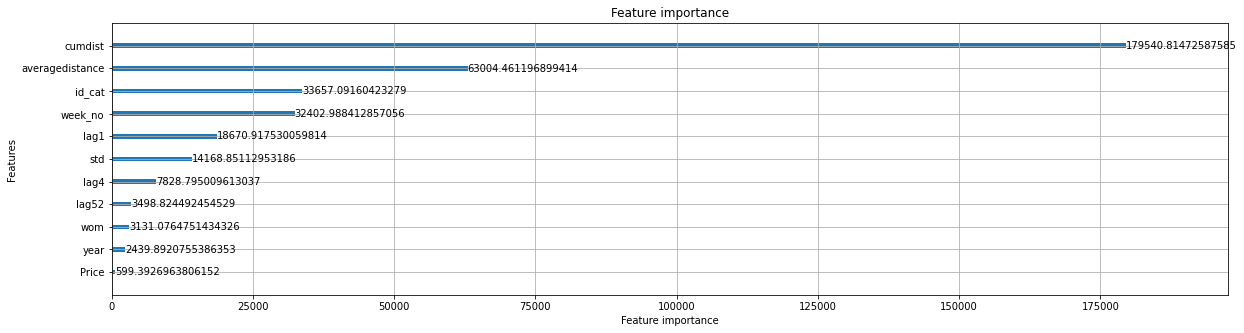

In [64]:
lgb.plot_importance(model,importance_type='gain',figsize=(20,5))

In [65]:
val_x1.head()

,Price,holiday,wom,year,week_no,cumdist,averagedistance,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,,,,,
2011-08-08,1.583599,-1.0,1,2011,32,0.0,0.013333,40.057125,1.636363,-1.109715,-0.248445,1
2011-08-15,1.583599,-1.0,2,2011,33,0.0,0.013333,40.057125,-0.510571,1.461613,-0.572982,1
2011-08-22,1.583599,-1.0,3,2011,34,0.0,0.013333,40.057125,-0.086177,-0.660357,0.375664,1
2011-08-29,1.583599,-1.0,4,2011,35,0.0,0.013333,40.057125,-0.223481,1.636363,0.088574,1
2011-09-05,1.583599,-1.0,0,2011,36,0.0,0.013333,40.057125,-0.435678,-0.510571,0.612825,1


# for recursive approach data preparation

In [66]:
val1['forecast'] = model.predict(val_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
train1['forecast'] = model.predict(train_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
train_val = pd.concat([train1,val1],axis=0)

In [69]:
vale = train_val.copy()
vale.head()

,StockCode,Quantity,Price,holiday,wom,year,week_no,timeelapsed,cumsum,cumdist,averagedistance,mean,std,tQuantity,lag1,lag4,lag52,forecast
ds,,,,,,,,,,,,,,,,,,
2010-05-31,20677,96.000000,1.583599,-1.0,4,2010,22,1.0,96.000000,0.0,0.013333,45.452,40.057125,1.261898,-1.000000,-1.000000,-1.0,-0.089153
2010-06-07,20677,10.500000,1.583599,-1.0,1,2010,23,1.0,106.500000,0.0,0.013333,45.452,40.057125,-0.872554,1.261898,-1.000000,-1.0,-0.079280
2010-06-14,20677,32.000000,1.583599,-1.0,2,2010,24,1.0,138.500000,0.0,0.013333,45.452,40.057125,-0.335820,-0.872554,-1.000000,-1.0,0.133273
2010-06-21,20677,30.833333,1.583599,-1.0,3,2010,25,1.0,169.333333,0.0,0.013333,45.452,40.057125,-0.364945,-0.335820,-1.000000,-1.0,-0.028540
2010-06-28,20677,123.666667,1.583599,-1.0,4,2010,26,1.0,293.000000,0.0,0.013333,45.452,40.057125,1.952578,-0.364945,1.261898,-1.0,0.707719


In [70]:
vale['forecast'].max()

2.8648483532357742

In [71]:
vale = vale.reset_index()

In [72]:
for lag in range(2,5):
  vale['lag'+str(lag)] = vale.groupby(['StockCode'])['tQuantity'].shift(lag)

In [73]:
val_x1.columns

Index(['Price', 'holiday', 'wom', 'year', 'week_no', 'cumdist',
       'averagedistance', 'std', 'lag1', 'lag4', 'lag52', 'id_cat'],
      dtype='object')

In [74]:
data.shape

(305914, 18)

# Recursive forecast implementation

In [75]:
def recursive_forecast(val,data,model,id_encoder,forecast_range=7,var='Quantity'):
  dat = val.copy()
  dat1 =data.copy()
  colname= dat.columns.tolist()
  for lag in range(2,5):
    dat['lag'+str(lag)] = dat.groupby(['StockCode'])[var].shift(lag)
  
  dat = dat.groupby(['StockCode'])[colname].tail(1).reset_index()
  da = dat.copy()
  # print(da)
  da_f = pd.DataFrame()  
  for fr in range(1,forecast_range):
    
    da['ds'] = da['ds'] + pd.DateOffset(days=7)
    if fr < 5:
      for i in range(1,5):
        if i == 1:
          da['lag'+str(i)] = dat['forecast'].values
                   
        else:
          da['lag'+str(i+1)] = dat['lag'+str(i)].values
          
        if i == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          # print(datt)
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          # print(dat12)
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] = datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          print(da11)

          da['lag52'] = da11['lag52']
                  
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          da1 = da[['week_no', 'wom', 'year', 'timeelapsed', 'cumdist', 'std', 'lag1',
                    'lag4', 'lag52', 'id_cat']]
          da1.fillna(-1,inplace=True)
          
          da.loc[:,'forecast'] = model.predict(da1)
          da['lforecast'] = np.where(da['forecast']*da['std']+da['mean'] < 0,0,da['forecast']*da['std']+da['mean'])
          da['cumsum'] = da.groupby(['StockCode'])['lforecast'].cumsum()
          da['cumdist'] = da.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1 
          da.fillna(-1,inplace=True)
      da_f = pd.concat([da_f,da],axis=0)
    
    else:
      for j in range(1,5):
        if j == 1 :
          da['lag'+str(j)] = da['forecast']
          
        elif j < 5:
          # print(da['lag'+str(j+1)])
          da['lag'+str(j+1)] = da['lag'+str(j)]
        if j == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          # print(datt,'\n',da['ds'])
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] =datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          # da11 = da11.rename(columns={})
          print(da11)
          da['lag52'] = da11['lag52']
          
          # print(da)
          # print(da['lag365'])
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          da1 = da[['week_no', 'wom', 'year', 'timeelapsed', 'cumdist', 'std', 'lag1',
                    'lag4', 'lag52', 'id_cat']]
          da1.fillna(-1,inplace=True)
          # print(da1)
          # print(da1.head())
          da.loc[:,'forecast'] = model.predict(da1)
          da['lforecast'] = np.where(da['forecast']*da['std']+da['mean'] < 0,0,da['forecast']*da['std']+da['mean'])
          da['cumsum'] = da.groupby(['StockCode'])['lforecast'].cumsum()
          da['cumdist'] = da.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1
          da.fillna(-1,inplace=True)
          
      da_f = pd.concat([da_f,da],axis=0)
  return da_f
 

In [76]:
(pd.to_datetime('2011-09-12') + pd.DateOffset(days=7))-pd.to_timedelta(52, unit='w')

Timestamp('2010-09-20 00:00:00')

In [77]:
data1.min()

Quantity                             0
Price                        0.0514286
holiday                             -1
ds                 2010-01-04 00:00:00
wom                                  0
year                              2010
week_no                              1
timeelapsed                          0
cumsum                               0
cumdist                             -1
averagedistance                      0
mean                                 0
std                                  0
tQuantity                     -1.91374
dtype: object

In [78]:
data.loc[data['ds']<'2010-09-20']

,StockCode,Quantity,Price,holiday,ds,wom,year,week_no,timeelapsed,cumsum,cumdist,averagedistance,mean,std,tQuantity,lag1,lag4,lag52
0,20677,96.000000,1.583599,-1.0,2010-05-31,4,2010,22,1.0,96.000000,0.0,0.013333,45.452000,40.057125,1.261898,-1.000000,-1.000000,-1.0
1,20677,10.500000,1.583599,-1.0,2010-06-07,1,2010,23,1.0,106.500000,0.0,0.013333,45.452000,40.057125,-0.872554,1.261898,-1.000000,-1.0
2,20677,32.000000,1.583599,-1.0,2010-06-14,2,2010,24,1.0,138.500000,0.0,0.013333,45.452000,40.057125,-0.335820,-0.872554,-1.000000,-1.0
3,20677,30.833333,1.583599,-1.0,2010-06-21,3,2010,25,1.0,169.333333,0.0,0.013333,45.452000,40.057125,-0.364945,-0.335820,-1.000000,-1.0
4,20677,123.666667,1.583599,-1.0,2010-06-28,4,2010,26,1.0,293.000000,0.0,0.013333,45.452000,40.057125,1.952578,-0.364945,1.261898,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305850,gift_0001_30,0.000000,25.420417,-1.0,2010-08-16,2,2010,33,1.0,22.000000,1.0,3.343750,0.578125,1.979272,-0.292090,0.213147,0.213147,-1.0
305851,gift_0001_30,0.000000,25.420417,-1.0,2010-08-23,3,2010,34,1.0,22.000000,2.0,3.343750,0.578125,1.979272,-0.292090,-0.292090,-0.292090,-1.0
305852,gift_0001_30,0.000000,25.420417,-1.0,2010-08-30,4,2010,35,1.0,22.000000,3.0,3.343750,0.578125,1.979272,-0.292090,-0.292090,-0.292090,-1.0
305853,gift_0001_30,10.000000,25.420417,-1.0,2010-09-06,0,2010,36,1.0,32.000000,0.0,3.343750,0.578125,1.979272,4.760274,-0.292090,0.213147,-1.0


# Mape  Comparison in test period

In [79]:
fr = recursive_forecast(vale,data1,model,id_encoder,8,'tQuantity')

           ds52     StockCode         ds     lag52
0    2009-02-02         22095        NaT       NaN
1    2009-06-08         20677        NaT       NaN
2    2010-09-20         20677 2010-09-20 -0.835107
3    2010-09-20         20679 2010-09-20  0.133883
4    2010-09-20         20681 2010-09-20  0.700254
...         ...           ...        ...       ...
3453 2010-09-20             M 2010-09-20  0.964455
3454 2010-09-20          PADS 2010-09-20 -0.390184
3455 2010-09-20          POST 2010-09-20 -0.262518
3456 2010-09-20  gift_0001_20 2010-09-20 -0.319954
3457 2010-09-20  gift_0001_30 2010-09-20  0.213147

[3458 rows x 4 columns]
           ds52     StockCode         ds     lag52
0    2009-02-09         22095        NaT       NaN
1    2009-06-15         20677        NaT       NaN
2    2010-09-27         20677 2010-09-27 -0.627071
3    2010-09-27         20679 2010-09-27  4.002823
4    2010-09-27         20681 2010-09-27  0.776192
...         ...           ...        ...       ...
3453 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           ds52     StockCode         ds     lag52
0    2009-02-23         22095        NaT       NaN
1    2009-06-29         20677        NaT       NaN
2    2010-10-11         20677 2010-10-11 -0.772696
3    2010-10-11         20679 2010-10-11 -0.150380
4    2010-10-11         20681 2010-10-11  0.016811
...         ...           ...        ...       ...
3453 2010-10-11             M 2010-10-11 -0.504169
3454 2010-10-11          PADS 2010-10-11 -0.390184
3455 2010-10-11          POST 2010-10-11  0.139659
3456 2010-10-11  gift_0001_20 2010-10-11 -0.319954
3457 2010-10-11  gift_0001_30 2010-10-11 -0.292090

[3458 rows x 4 columns]
           ds52     StockCode         ds     lag52
0    2009-03-02         22095        NaT       NaN
1    2009-07-06         20677        NaT       NaN
2    2010-10-18         20677 2010-10-18 -0.785179
3    2010-10-18         20679 2010-10-18 -0.152298
4    2010-10-18         20681 2010-10-18  0.016811
...         ...           ...        ...       ...
3453 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           ds52     StockCode         ds     lag52
0    2009-03-16         22095        NaT       NaN
1    2009-07-20         20677        NaT       NaN
2    2010-11-01         20677 2010-11-01  1.199487
3    2010-11-01         20679 2010-11-01 -0.047269
4    2010-11-01         20681 2010-11-01 -0.211003
...         ...           ...        ...       ...
3453 2010-11-01             M 2010-11-01 -0.516564
3454 2010-11-01          PADS 2010-11-01 -0.390184
3455 2010-11-01          POST 2010-11-01 -0.319048
3456 2010-11-01  gift_0001_20 2010-11-01 -0.319954
3457 2010-11-01  gift_0001_30 2010-11-01 -0.292090

[3458 rows x 4 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
fr.head()

,index,ds,StockCode,Quantity,Price,holiday,wom,year,week_no,timeelapsed,cumsum,cumdist,averagedistance,mean,std,tQuantity,lag1,lag4,lag52,forecast,lag2,lag3,lag5,ds52,id_cat,lforecast
0,78376,2010-02-01,22095,36.0,1.496444,-1.0,3,2010,4,1.0,11.577498,0.0,0.000000,102.416667,112.020955,-0.592895,0.287874,-0.914263,-1.000000,-0.810912,0.171843,0.171843,-1.000000,2009-02-02,946,11.577498
1,161353,2010-06-07,20677,0.0,1.583599,-1.0,4,2010,22,1.0,22.388236,0.0,0.045455,68.928030,60.184211,-1.145284,-0.625396,-0.306194,-1.000000,-0.773289,-0.439119,-0.439119,0.070428,2009-06-08,2052,22.388236
2,260986,2011-09-19,20677,6.0,1.583599,-1.0,1,2011,37,1.0,13.291894,0.0,0.013333,45.452000,40.057125,-0.984893,-0.039232,-0.223481,-0.835107,-0.802856,-0.435678,-0.435678,-0.086177,2010-09-20,1,13.291894
3,260992,2011-09-19,20679,32.5,6.618982,-1.0,1,2011,37,1.0,0.000000,0.0,0.000000,30.785438,69.504593,0.024668,0.028307,-0.198339,0.133883,-0.515350,-0.356601,-0.356601,1.614491,2010-09-20,2,0.000000
4,260998,2011-09-19,20681,0.0,3.824902,-1.0,1,2011,37,1.0,1.928582,0.0,1.906250,9.778621,13.168624,-0.742570,-0.681618,-0.742570,0.700254,-0.596117,-0.742570,-0.742570,-0.742570,2010-09-20,3,1.928582


In [81]:
test = test.reset_index()

In [82]:
# train_val.loc[train_val['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),]

In [83]:
test.isnull().sum()

ds                 0
StockCode          0
Quantity           0
Price              0
holiday            0
wom                0
year               0
week_no            0
timeelapsed        0
cumsum             0
cumdist            0
averagedistance    0
mean               0
std                0
tQuantity          0
lag1               0
lag4               0
lag52              0
dtype: int64

In [84]:
test1 = test.merge(fr[['StockCode','ds','lforecast']],on=['StockCode','ds'],how='left')
# test1['forecast'] = test1['forecast']*test1['std'] + test1['mean']
test1['error'] = np.abs(test1['Quantity']-test1['lforecast'])/(test1['Quantity']+1)
t2 = test1.loc[test1['Quantity']>0,]
t = test1.groupby('StockCode')['error'].mean().reset_index()

In [85]:
test1.isnull().sum()

ds                 0
StockCode          0
Quantity           0
Price              0
holiday            0
wom                0
year               0
week_no            0
timeelapsed        0
cumsum             0
cumdist            0
averagedistance    0
mean               0
std                0
tQuantity          0
lag1               0
lag4               0
lag52              0
lforecast          4
error              4
dtype: int64

In [86]:
t = t.sort_values(by=['error'])

In [87]:
t.groupby(['StockCode'])['error'].mean().mean()

0.6562529156146842

In [88]:
t.sort_values(by=['error'])

,StockCode,error
2434,37410,0.000000
2875,84625D,0.000000
2872,84620,0.000000
2870,84615,0.000000
2868,84601A,0.000000
...,...,...
2715,82600,12.562842
1408,22444,12.998582
881,22030,15.374628
2660,79000,21.446079


In [89]:
t3  = t2.groupby('StockCode')['error'].mean().reset_index()

In [90]:
t3.to_csv('../../data/lgbnon-zerointerval_mape.csv',index=False)

In [91]:
t2.groupby(['StockCode'])['error'].mean().reset_index()

,StockCode,error
0,20677,1.200532
1,20679,0.958163
2,20681,0.448898
3,20682,0.615192
4,20684,0.738689
...,...,...
2873,M,0.642092
2874,PADS,0.500000
2875,POST,0.980597
2876,gift_0001_20,0.500000


In [92]:
stock_cont = data1.groupby(['StockCode'])['Quantity'].sum()/data1['Quantity'].sum()

In [93]:
t = t.merge(stock_cont,on=['StockCode'],how='left')

In [94]:
t.sort_values(by=['Quantity'],ascending=False).head(60)

,StockCode,error,Quantity
1104,84077,0.330563,0.008825
2843,17003,0.876461,0.007283
1419,21212,0.456896,0.005959
1418,22492,0.455924,0.005075
1802,84568,0.580309,0.004837
0,37410,0.000000,0.004460
2073,21977,0.663725,0.003986
2124,22197,0.678923,0.003751
1191,84991,0.366402,0.003651
3101,21980,0.982341,0.003643


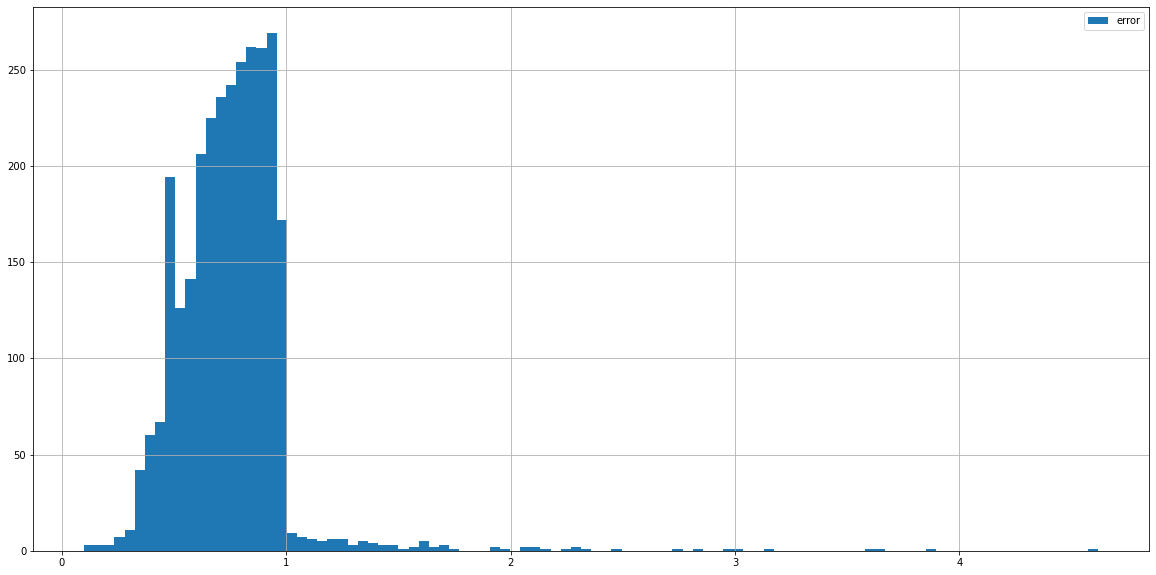

In [95]:
fig, ax = plt.subplots(figsize=(20,10))
t3['error'].hist(bins=100,legend='Mape in Test Period',ax=ax)

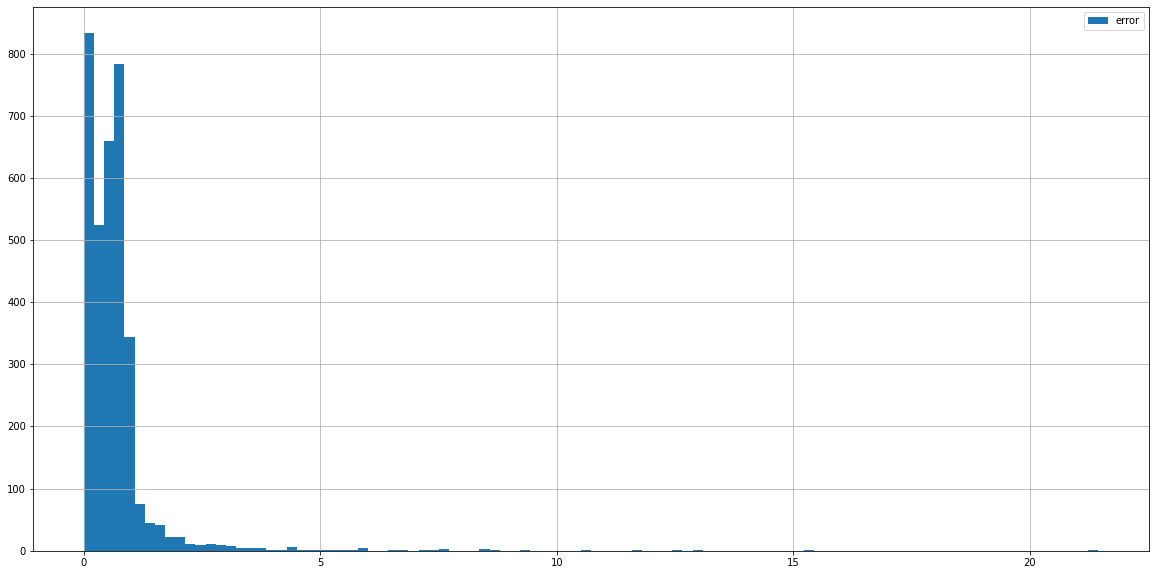

In [96]:
fig, ax = plt.subplots(figsize=(20,10))
t['error'].hist(bins=100,legend='Mape in Test Period',ax=ax)

In [97]:
test1.loc[test1['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),'lforecast'] = test1.loc[test1['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),'lforecast']

In [98]:
# len(t3[t3 <.2])

In [99]:
for i in t3['StockCode'].head(60).tolist():
  fig, ax = plt.subplots(figsize=(20,10))
  test1.loc[test1['StockCode']==i,'lforecast'].plot(ax=ax,title=i,legend='Forecast')
  test1.loc[test1['StockCode']==i,'Quantity'].plot(ax=ax,title=i,legend='Actual')

Output hidden; open in https://colab.research.google.com to view.

In [100]:
###############Forecast

In [101]:
train_fy

0         1.261898
1        -0.872554
2        -0.335820
3        -0.364945
4         1.952578
            ...   
305902   -0.292090
305903   -0.292090
305904    7.539074
305905   -0.292090
305906   -0.292090
Name: tQuantity, Length: 281717, dtype: float64

In [102]:
lgb_train = lgb.Dataset(train_f,train_fy,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_f, val_fy, reference=lgb_train)


In [103]:
val_f.head()

,Price,holiday,wom,year,week_no,cumdist,averagedistance,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,,,,,
2011-09-19,1.583599,-1.0,2,2011,38,0.0,0.013333,40.057125,-0.984893,-0.223481,-0.835107,1.0
2011-09-26,1.583599,-1.0,3,2011,39,0.0,0.013333,40.057125,1.765346,-0.435678,-0.627071,1.0
2011-10-03,1.583599,-1.0,0,2011,40,0.0,0.013333,40.057125,-0.323338,-0.572982,-0.785179,1.0
2011-10-10,1.583599,-1.0,1,2011,41,0.0,0.013333,40.057125,2.759759,-0.984893,-0.772696,1.0
2011-10-17,1.583599,-1.0,2,2011,42,0.0,0.013333,40.057125,-0.910000,1.765346,-0.785179,1.0


In [104]:
tuned_model = LightGBMTuner(params, train_set=lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=300,
                                     early_stopping_rounds=30,
                                    )

[I 2021-02-22 15:46:40,037] A new study created in memory with name: no-name-0b7c99c7-7f83-4213-8c72-d5c64eff7204


In [105]:
tuned_model.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l2: 1.00832
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 1.00922
[3]	valid_0's l2: 1.0042
[4]	valid_0's l2: 0.977983
[5]	valid_0's l2: 0.9721
[6]	valid_0's l2: 0.967268
[7]	valid_0's l2: 0.950934
[8]	valid_0's l2: 0.948699
[9]	valid_0's l2: 0.947764
[10]	valid_0's l2: 0.945709
[11]	valid_0's l2: 0.941938
[12]	valid_0's l2: 0.937115
[13]	valid_0's l2: 0.936761
[14]	valid_0's l2: 0.936367
[15]	valid_0's l2: 0.931352
[16]	valid_0's l2: 0.917466
[17]	valid_0's l2: 0.915604
[18]	valid_0's l2: 0.915101
[19]	valid_0's l2: 0.90176
[20]	valid_0's l2: 0.900432
[21]	valid_0's l2: 0.889881
[22]	valid_0's l2: 0.88983
[23]	valid_0's l2: 0.882282
[24]	valid_0's l2: 0.876808
[25]	valid_0's l2: 0.876421
[26]	valid_0's l2: 0.871048
[27]	valid_0's l2: 0.865562
[28]	valid_0's l2: 0.864573
[29]	valid_0's l2: 0.859112
[30]	valid_0's l2: 0.858187
[31]	valid_0's l2: 0.85497
[32]	valid_0's l2: 0.855563
[33]	valid_0's l2: 0.85377
[34]	valid_0's l2: 0.854367
[35]	

feature_fraction, val_score: 0.834526:  14%|#4        | 1/7 [00:02<00:17,  2.91s/it][I 2021-02-22 15:46:42,968] Trial 0 finished with value: 0.834525543865132 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.834525543865132.


[126]	valid_0's l2: 0.835531
[127]	valid_0's l2: 0.835717
[128]	valid_0's l2: 0.835733
[129]	valid_0's l2: 0.835812
[130]	valid_0's l2: 0.835815
[131]	valid_0's l2: 0.836064
[132]	valid_0's l2: 0.836113
[133]	valid_0's l2: 0.83616
[134]	valid_0's l2: 0.836142
Early stopping, best iteration is:
[104]	valid_0's l2: 0.834526


feature_fraction, val_score: 0.834526:  14%|#4        | 1/7 [00:02<00:17,  2.91s/it]

[1]	valid_0's l2: 1.00913
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980664
[3]	valid_0's l2: 0.955864
[4]	valid_0's l2: 0.927303
[5]	valid_0's l2: 0.90703
[6]	valid_0's l2: 0.892955
[7]	valid_0's l2: 0.877819
[8]	valid_0's l2: 0.867581
[9]	valid_0's l2: 0.856611
[10]	valid_0's l2: 0.849252
[11]	valid_0's l2: 0.843325
[12]	valid_0's l2: 0.838077
[13]	valid_0's l2: 0.832801
[14]	valid_0's l2: 0.829198
[15]	valid_0's l2: 0.825939
[16]	valid_0's l2: 0.823256
[17]	valid_0's l2: 0.822039
[18]	valid_0's l2: 0.821398
[19]	valid_0's l2: 0.819223
[20]	valid_0's l2: 0.819088
[21]	valid_0's l2: 0.818432
[22]	valid_0's l2: 0.81762
[23]	valid_0's l2: 0.816938
[24]	valid_0's l2: 0.816564
[25]	valid_0's l2: 0.816715
[26]	valid_0's l2: 0.816861
[27]	valid_0's l2: 0.815811
[28]	valid_0's l2: 0.816061
[29]	valid_0's l2: 0.81604
[30]	valid_0's l2: 0.815498
[31]	valid_0's l2: 0.816093
[32]	valid_0's l2: 0.816333
[33]	valid_0's l2: 0.816796
[34]	valid_0's l2: 0.817296

feature_fraction, val_score: 0.815498:  29%|##8       | 2/7 [00:05<00:13,  2.69s/it]

[57]	valid_0's l2: 0.820616
[58]	valid_0's l2: 0.820618
[59]	valid_0's l2: 0.82084
[60]	valid_0's l2: 0.820821
Early stopping, best iteration is:
[30]	valid_0's l2: 0.815498
[1]	valid_0's l2: 1.00277
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.968182
[3]	valid_0's l2: 0.940805
[4]	valid_0's l2: 0.918773
[5]	valid_0's l2: 0.900047
[6]	valid_0's l2: 0.88521
[7]	valid_0's l2: 0.872843
[8]	valid_0's l2: 0.864209
[9]	valid_0's l2: 0.856227
[10]	valid_0's l2: 0.84914
[11]	valid_0's l2: 0.84217
[12]	valid_0's l2: 0.837517
[13]	valid_0's l2: 0.833992
[14]	valid_0's l2: 0.830992
[15]	valid_0's l2: 0.828497
[16]	valid_0's l2: 0.825558
[17]	valid_0's l2: 0.824701
[18]	valid_0's l2: 0.823235
[19]	valid_0's l2: 0.821949
[20]	valid_0's l2: 0.820091
[21]	valid_0's l2: 0.819017
[22]	valid_0's l2: 0.818083
[23]	valid_0's l2: 0.818427
[24]	valid_0's l2: 0.817308
[25]	valid_0's l2: 0.816577
[26]	valid_0's l2: 0.816486
[27]	valid_0's l2: 0.816739
[28]	valid_0's l2: 0.

feature_fraction, val_score: 0.815498:  43%|####2     | 3/7 [00:07<00:10,  2.64s/it]

[57]	valid_0's l2: 0.822582
[58]	valid_0's l2: 0.822583
[59]	valid_0's l2: 0.8226
[60]	valid_0's l2: 0.82258
Early stopping, best iteration is:
[30]	valid_0's l2: 0.816135
[1]	valid_0's l2: 1.03678
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 1.03356
[3]	valid_0's l2: 0.997515
[4]	valid_0's l2: 0.970046
[5]	valid_0's l2: 0.964745
[6]	valid_0's l2: 0.955151
[7]	valid_0's l2: 0.938068
[8]	valid_0's l2: 0.916399
[9]	valid_0's l2: 0.898374
[10]	valid_0's l2: 0.889515
[11]	valid_0's l2: 0.888821
[12]	valid_0's l2: 0.877627
[13]	valid_0's l2: 0.877038
[14]	valid_0's l2: 0.869059
[15]	valid_0's l2: 0.861126
[16]	valid_0's l2: 0.854633
[17]	valid_0's l2: 0.855281
[18]	valid_0's l2: 0.849505
[19]	valid_0's l2: 0.843042
[20]	valid_0's l2: 0.842629
[21]	valid_0's l2: 0.83972
[22]	valid_0's l2: 0.83557
[23]	valid_0's l2: 0.833727
[24]	valid_0's l2: 0.832519
[25]	valid_0's l2: 0.831949
[26]	valid_0's l2: 0.832047
[27]	valid_0's l2: 0.831804
[28]	valid_0's l2: 0.83

feature_fraction, val_score: 0.815498:  57%|#####7    | 4/7 [00:09<00:07,  2.43s/it]

[66]	valid_0's l2: 0.825976
[67]	valid_0's l2: 0.825754
Early stopping, best iteration is:
[37]	valid_0's l2: 0.822787
[1]	valid_0's l2: 1.00859
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 1.00203
[3]	valid_0's l2: 0.974088
[4]	valid_0's l2: 0.948216
[5]	valid_0's l2: 0.921614
[6]	valid_0's l2: 0.905337
[7]	valid_0's l2: 0.888518
[8]	valid_0's l2: 0.875805
[9]	valid_0's l2: 0.863539
[10]	valid_0's l2: 0.854721
[11]	valid_0's l2: 0.848778
[12]	valid_0's l2: 0.843846
[13]	valid_0's l2: 0.842048
[14]	valid_0's l2: 0.837386
[15]	valid_0's l2: 0.833968
[16]	valid_0's l2: 0.830194
[17]	valid_0's l2: 0.827741
[18]	valid_0's l2: 0.82551
[19]	valid_0's l2: 0.823843
[20]	valid_0's l2: 0.822376
[21]	valid_0's l2: 0.820918
[22]	valid_0's l2: 0.820453
[23]	valid_0's l2: 0.820681
[24]	valid_0's l2: 0.820431
[25]	valid_0's l2: 0.818975
[26]	valid_0's l2: 0.819266
[27]	valid_0's l2: 0.819437
[28]	valid_0's l2: 0.819483
[29]	valid_0's l2: 0.81947
[30]	valid_0's l2: 0

feature_fraction, val_score: 0.815498:  71%|#######1  | 5/7 [00:11<00:04,  2.30s/it]

[51]	valid_0's l2: 0.824183
[52]	valid_0's l2: 0.824112
[53]	valid_0's l2: 0.82361
[54]	valid_0's l2: 0.823802
[55]	valid_0's l2: 0.824111
Early stopping, best iteration is:
[25]	valid_0's l2: 0.818975
[1]	valid_0's l2: 1.01095
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 1.00518
[3]	valid_0's l2: 0.977276
[4]	valid_0's l2: 0.951609
[5]	valid_0's l2: 0.924298
[6]	valid_0's l2: 0.916125
[7]	valid_0's l2: 0.900227
[8]	valid_0's l2: 0.886263
[9]	valid_0's l2: 0.871765
[10]	valid_0's l2: 0.860985
[11]	valid_0's l2: 0.853399
[12]	valid_0's l2: 0.847732
[13]	valid_0's l2: 0.845576
[14]	valid_0's l2: 0.840364
[15]	valid_0's l2: 0.836697
[16]	valid_0's l2: 0.834211
[17]	valid_0's l2: 0.830953
[18]	valid_0's l2: 0.827088
[19]	valid_0's l2: 0.823427
[20]	valid_0's l2: 0.823013
[21]	valid_0's l2: 0.821759
[22]	valid_0's l2: 0.819778
[23]	valid_0's l2: 0.819793
[24]	valid_0's l2: 0.818991
[25]	valid_0's l2: 0.819003
[26]	valid_0's l2: 0.819791
[27]	valid_0's l2: 

feature_fraction, val_score: 0.815498:  86%|########5 | 6/7 [00:13<00:02,  2.23s/it]

[56]	valid_0's l2: 0.822488
[57]	valid_0's l2: 0.823037
[58]	valid_0's l2: 0.823214
[59]	valid_0's l2: 0.823504
[60]	valid_0's l2: 0.823387
Early stopping, best iteration is:
[30]	valid_0's l2: 0.817791
[1]	valid_0's l2: 1.00941
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 1.00624
[3]	valid_0's l2: 0.975709
[4]	valid_0's l2: 0.952732
[5]	valid_0's l2: 0.945137
[6]	valid_0's l2: 0.935635
[7]	valid_0's l2: 0.916218
[8]	valid_0's l2: 0.899568
[9]	valid_0's l2: 0.882934
[10]	valid_0's l2: 0.872863
[11]	valid_0's l2: 0.864711
[12]	valid_0's l2: 0.85764
[13]	valid_0's l2: 0.857385
[14]	valid_0's l2: 0.852016
[15]	valid_0's l2: 0.846525
[16]	valid_0's l2: 0.839786
[17]	valid_0's l2: 0.835669
[18]	valid_0's l2: 0.83115
[19]	valid_0's l2: 0.825363
[20]	valid_0's l2: 0.825128
[21]	valid_0's l2: 0.824639
[22]	valid_0's l2: 0.822226
[23]	valid_0's l2: 0.821415
[24]	valid_0's l2: 0.820798
[25]	valid_0's l2: 0.819653
[26]	valid_0's l2: 0.820018
[27]	valid_0's l2: 0

num_leaves, val_score: 0.815498:   0%|          | 0/20 [00:00<?, ?it/s]

[67]	valid_0's l2: 0.820647
[68]	valid_0's l2: 0.821425
[69]	valid_0's l2: 0.821286
Early stopping, best iteration is:
[39]	valid_0's l2: 0.816561
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.815181
[27]	valid_0's l2: 0.814748
[28]	valid_0's l2: 0.814323
[29]	valid_0's l2: 0

num_leaves, val_score: 0.810932:   5%|5         | 1/20 [00:01<00:36,  1.90s/it]

[69]	valid_0's l2: 0.813187
[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00708
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.978744
[3]	valid_0's l2: 0.95462
[4]	valid_0's l2: 0.926259
[5]	valid_0's l2: 0.904413
[6]	valid_0's l2: 0.890331
[7]	valid_0's l2: 0.876108
[8]	valid_0's l2: 0.865316
[9]	valid_0's l2: 0.85525
[10]	valid_0's l2: 0.847719
[11]	valid_0's l2: 0.842377
[12]	valid_0's l2: 0.836983
[13]	valid_0's l2: 0.831976
[14]	valid_0's l2: 0.828543
[15]	valid_0's l2: 0.826373
[16]	valid_0's l2: 0.823832
[17]	valid_0's l2: 0.82186
[18]	valid_0's l2: 0.820065
[19]	valid_0's l2: 0.819921
[20]	valid_0's l2: 0.820008
[21]	valid_0's l2: 0.820938
[22]	valid_0's l2: 0.819542
[23]	valid_0's l2: 0.819825
[24]	valid_0's l2: 0.819827
[25]	valid_0's l2: 0.820222
[26]	valid_0's l2: 0.820818
[27]	valid_0's l2: 0

num_leaves, val_score: 0.810932:  10%|#         | 2/20 [00:19<02:00,  6.70s/it]

[49]	valid_0's l2: 0.833422
[50]	valid_0's l2: 0.833729
[51]	valid_0's l2: 0.833612
[52]	valid_0's l2: 0.833441
Early stopping, best iteration is:
[22]	valid_0's l2: 0.819542
[1]	valid_0's l2: 1.00886
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.97933
[3]	valid_0's l2: 0.954582
[4]	valid_0's l2: 0.925995
[5]	valid_0's l2: 0.905022
[6]	valid_0's l2: 0.89166
[7]	valid_0's l2: 0.876392
[8]	valid_0's l2: 0.866026
[9]	valid_0's l2: 0.856112
[10]	valid_0's l2: 0.847796
[11]	valid_0's l2: 0.842148
[12]	valid_0's l2: 0.835735
[13]	valid_0's l2: 0.830236
[14]	valid_0's l2: 0.825481
[15]	valid_0's l2: 0.823048
[16]	valid_0's l2: 0.820554
[17]	valid_0's l2: 0.820566
[18]	valid_0's l2: 0.819858
[19]	valid_0's l2: 0.819884
[20]	valid_0's l2: 0.819661
[21]	valid_0's l2: 0.819669
[22]	valid_0's l2: 0.818491
[23]	valid_0's l2: 0.818437
[24]	valid_0's l2: 0.818076
[25]	valid_0's l2: 0.818475
[26]	valid_0's l2: 0.818319
[27]	valid_0's l2: 0.818728
[28]	valid_0's l2: 

num_leaves, val_score: 0.810932:  15%|#5        | 3/20 [00:23<01:41,  5.94s/it]

[50]	valid_0's l2: 0.824584
[51]	valid_0's l2: 0.824473
[52]	valid_0's l2: 0.825981
[53]	valid_0's l2: 0.826428
[54]	valid_0's l2: 0.826453
Early stopping, best iteration is:
[24]	valid_0's l2: 0.818076


[I 2021-02-22 15:47:19,774] Trial 9 finished with value: 0.8180763474609628 and parameters: {'num_leaves': 86}. Best is trial 7 with value: 0.810931737012285.
num_leaves, val_score: 0.810932:  15%|#5        | 3/20 [00:23<01:41,  5.94s/it]

[1]	valid_0's l2: 1.00529
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.976146
[3]	valid_0's l2: 0.951568
[4]	valid_0's l2: 0.925364
[5]	valid_0's l2: 0.90415
[6]	valid_0's l2: 0.889989
[7]	valid_0's l2: 0.875607
[8]	valid_0's l2: 0.864435
[9]	valid_0's l2: 0.853358
[10]	valid_0's l2: 0.845909
[11]	valid_0's l2: 0.839693
[12]	valid_0's l2: 0.8335
[13]	valid_0's l2: 0.827999
[14]	valid_0's l2: 0.822552
[15]	valid_0's l2: 0.820435
[16]	valid_0's l2: 0.818414
[17]	valid_0's l2: 0.816882
[18]	valid_0's l2: 0.816762
[19]	valid_0's l2: 0.816708
[20]	valid_0's l2: 0.816909
[21]	valid_0's l2: 0.817297
[22]	valid_0's l2: 0.815784
[23]	valid_0's l2: 0.816483
[24]	valid_0's l2: 0.816887
[25]	valid_0's l2: 0.817374
[26]	valid_0's l2: 0.817904
[27]	valid_0's l2: 0.818329
[28]	valid_0's l2: 0.818369
[29]	valid_0's l2: 0.818674
[30]	valid_0's l2: 0.820339
[31]	valid_0's l2: 0.819659
[32]	valid_0's l2: 0.819866
[33]	valid_0's l2: 0.820808
[34]	valid_0's l2: 0.82129


num_leaves, val_score: 0.810932:  20%|##        | 4/20 [00:28<01:27,  5.47s/it]

[51]	valid_0's l2: 0.83146
[52]	valid_0's l2: 0.831385
Early stopping, best iteration is:
[22]	valid_0's l2: 0.815784
[1]	valid_0's l2: 1.00928
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980273
[3]	valid_0's l2: 0.955731
[4]	valid_0's l2: 0.93081
[5]	valid_0's l2: 0.911584
[6]	valid_0's l2: 0.897085
[7]	valid_0's l2: 0.882213
[8]	valid_0's l2: 0.872758
[9]	valid_0's l2: 0.863179
[10]	valid_0's l2: 0.855271
[11]	valid_0's l2: 0.850622
[12]	valid_0's l2: 0.845865
[13]	valid_0's l2: 0.838726
[14]	valid_0's l2: 0.835019
[15]	valid_0's l2: 0.830714
[16]	valid_0's l2: 0.829325
[17]	valid_0's l2: 0.826955
[18]	valid_0's l2: 0.823028
[19]	valid_0's l2: 0.822137
[20]	valid_0's l2: 0.820316
[21]	valid_0's l2: 0.818433
[22]	valid_0's l2: 0.817236
[23]	valid_0's l2: 0.817205
[24]	valid_0's l2: 0.816789
[25]	valid_0's l2: 0.816236
[26]	valid_0's l2: 0.816352
[27]	valid_0's l2: 0.815955
[28]	valid_0's l2: 0.815708
[29]	valid_0's l2: 0.815518
[30]	valid_0's l2: 

num_leaves, val_score: 0.810932:  25%|##5       | 5/20 [00:30<01:07,  4.49s/it]

[84]	valid_0's l2: 0.816425
[85]	valid_0's l2: 0.816529
[86]	valid_0's l2: 0.81697
[87]	valid_0's l2: 0.817187
[88]	valid_0's l2: 0.817434
[89]	valid_0's l2: 0.817424
[90]	valid_0's l2: 0.817595
[91]	valid_0's l2: 0.817683
[92]	valid_0's l2: 0.817703
Early stopping, best iteration is:
[62]	valid_0's l2: 0.812137
[1]	valid_0's l2: 1.00541
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.976398
[3]	valid_0's l2: 0.950572
[4]	valid_0's l2: 0.924237
[5]	valid_0's l2: 0.903361
[6]	valid_0's l2: 0.890252
[7]	valid_0's l2: 0.87345
[8]	valid_0's l2: 0.862609
[9]	valid_0's l2: 0.852347
[10]	valid_0's l2: 0.845211
[11]	valid_0's l2: 0.838799
[12]	valid_0's l2: 0.832589
[13]	valid_0's l2: 0.825852
[14]	valid_0's l2: 0.822439
[15]	valid_0's l2: 0.819721
[16]	valid_0's l2: 0.817946
[17]	valid_0's l2: 0.8157
[18]	valid_0's l2: 0.815713
[19]	valid_0's l2: 0.815884
[20]	valid_0's l2: 0.815396
[21]	valid_0's l2: 0.814948
[22]	valid_0's l2: 0.814624
[23]	valid_0's l2: 0.

num_leaves, val_score: 0.810932:  30%|###       | 6/20 [00:34<01:01,  4.43s/it]

[50]	valid_0's l2: 0.827136
[51]	valid_0's l2: 0.826755
[52]	valid_0's l2: 0.826989
Early stopping, best iteration is:
[22]	valid_0's l2: 0.814624
[1]	valid_0's l2: 1.00581
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.976535
[3]	valid_0's l2: 0.950934
[4]	valid_0's l2: 0.923055
[5]	valid_0's l2: 0.902398
[6]	valid_0's l2: 0.887355
[7]	valid_0's l2: 0.872468
[8]	valid_0's l2: 0.862218
[9]	valid_0's l2: 0.852278
[10]	valid_0's l2: 0.845419
[11]	valid_0's l2: 0.839426
[12]	valid_0's l2: 0.832821
[13]	valid_0's l2: 0.828222
[14]	valid_0's l2: 0.822287
[15]	valid_0's l2: 0.819876
[16]	valid_0's l2: 0.817478
[17]	valid_0's l2: 0.816413
[18]	valid_0's l2: 0.816219
[19]	valid_0's l2: 0.816574
[20]	valid_0's l2: 0.817216
[21]	valid_0's l2: 0.817298
[22]	valid_0's l2: 0.816673
[23]	valid_0's l2: 0.815762
[24]	valid_0's l2: 0.815692
[25]	valid_0's l2: 0.815956
[26]	valid_0's l2: 0.816436
[27]	valid_0's l2: 0.816533
[28]	valid_0's l2: 0.816813
[29]	valid_0's l2

num_leaves, val_score: 0.810932:  35%|###5      | 7/20 [00:39<00:57,  4.42s/it]

[54]	valid_0's l2: 0.827203
Early stopping, best iteration is:
[24]	valid_0's l2: 0.815692
[1]	valid_0's l2: 1.00903
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.97945
[3]	valid_0's l2: 0.954585
[4]	valid_0's l2: 0.926361
[5]	valid_0's l2: 0.905435
[6]	valid_0's l2: 0.89195
[7]	valid_0's l2: 0.876877
[8]	valid_0's l2: 0.866505
[9]	valid_0's l2: 0.85686
[10]	valid_0's l2: 0.848083
[11]	valid_0's l2: 0.842444
[12]	valid_0's l2: 0.83612
[13]	valid_0's l2: 0.830495
[14]	valid_0's l2: 0.825268
[15]	valid_0's l2: 0.822562
[16]	valid_0's l2: 0.82019
[17]	valid_0's l2: 0.819703
[18]	valid_0's l2: 0.818722
[19]	valid_0's l2: 0.818863
[20]	valid_0's l2: 0.817323
[21]	valid_0's l2: 0.817904
[22]	valid_0's l2: 0.817842
[23]	valid_0's l2: 0.817471
[24]	valid_0's l2: 0.817329
[25]	valid_0's l2: 0.817705
[26]	valid_0's l2: 0.818606
[27]	valid_0's l2: 0.819158
[28]	valid_0's l2: 0.819256
[29]	valid_0's l2: 0.819641
[30]	valid_0's l2: 0.820106
[31]	valid_0's l2: 0.8

num_leaves, val_score: 0.810932:  40%|####      | 8/20 [00:42<00:47,  4.00s/it]

[46]	valid_0's l2: 0.826503
[47]	valid_0's l2: 0.827276
[48]	valid_0's l2: 0.82755
[49]	valid_0's l2: 0.827908
[50]	valid_0's l2: 0.828154
Early stopping, best iteration is:
[20]	valid_0's l2: 0.817323


[I 2021-02-22 15:47:38,071] Trial 14 finished with value: 0.817322701020977 and parameters: {'num_leaves': 89}. Best is trial 7 with value: 0.810931737012285.
num_leaves, val_score: 0.810932:  40%|####      | 8/20 [00:42<00:47,  4.00s/it]

[1]	valid_0's l2: 1.00542
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.976404
[3]	valid_0's l2: 0.950722
[4]	valid_0's l2: 0.922694
[5]	valid_0's l2: 0.901985
[6]	valid_0's l2: 0.888374
[7]	valid_0's l2: 0.873416
[8]	valid_0's l2: 0.862207
[9]	valid_0's l2: 0.852381
[10]	valid_0's l2: 0.845803
[11]	valid_0's l2: 0.839914
[12]	valid_0's l2: 0.833656
[13]	valid_0's l2: 0.827488
[14]	valid_0's l2: 0.824787
[15]	valid_0's l2: 0.822928
[16]	valid_0's l2: 0.820813
[17]	valid_0's l2: 0.819868
[18]	valid_0's l2: 0.819611
[19]	valid_0's l2: 0.817908
[20]	valid_0's l2: 0.817654
[21]	valid_0's l2: 0.818436
[22]	valid_0's l2: 0.817005
[23]	valid_0's l2: 0.817179
[24]	valid_0's l2: 0.817293
[25]	valid_0's l2: 0.817354
[26]	valid_0's l2: 0.818589
[27]	valid_0's l2: 0.819175
[28]	valid_0's l2: 0.819521
[29]	valid_0's l2: 0.819848
[30]	valid_0's l2: 0.820263
[31]	valid_0's l2: 0.820932
[32]	valid_0's l2: 0.821332
[33]	valid_0's l2: 0.822659
[34]	valid_0's l2: 0.824

num_leaves, val_score: 0.810932:  45%|####5     | 9/20 [00:46<00:44,  4.09s/it]

[1]	valid_0's l2: 1.00725
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.978908
[3]	valid_0's l2: 0.954917
[4]	valid_0's l2: 0.927013
[5]	valid_0's l2: 0.905773
[6]	valid_0's l2: 0.891684
[7]	valid_0's l2: 0.877358
[8]	valid_0's l2: 0.867271
[9]	valid_0's l2: 0.856266
[10]	valid_0's l2: 0.849653
[11]	valid_0's l2: 0.843971
[12]	valid_0's l2: 0.837805
[13]	valid_0's l2: 0.831944
[14]	valid_0's l2: 0.826855
[15]	valid_0's l2: 0.824449
[16]	valid_0's l2: 0.82256
[17]	valid_0's l2: 0.821224
[18]	valid_0's l2: 0.820728
[19]	valid_0's l2: 0.81942
[20]	valid_0's l2: 0.81835
[21]	valid_0's l2: 0.819809
[22]	valid_0's l2: 0.81976
[23]	valid_0's l2: 0.820073
[24]	valid_0's l2: 0.82003
[25]	valid_0's l2: 0.820456
[26]	valid_0's l2: 0.821126
[27]	valid_0's l2: 0.822121
[28]	valid_0's l2: 0.822321
[29]	valid_0's l2: 0.822537
[30]	valid_0's l2: 0.822815
[31]	valid_0's l2: 0.822481
[32]	valid_0's l2: 0.823168
[33]	valid_0's l2: 0.824508
[34]	valid_0's l2: 0.825107
[

num_leaves, val_score: 0.810932:  50%|#####     | 10/20 [00:49<00:38,  3.89s/it]


[50]	valid_0's l2: 0.831072
Early stopping, best iteration is:
[20]	valid_0's l2: 0.81835
[1]	valid_0's l2: 1.01078
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.981974
[3]	valid_0's l2: 0.957768
[4]	valid_0's l2: 0.932441
[5]	valid_0's l2: 0.913269
[6]	valid_0's l2: 0.898728
[7]	valid_0's l2: 0.883997
[8]	valid_0's l2: 0.874714
[9]	valid_0's l2: 0.865333
[10]	valid_0's l2: 0.857182
[11]	valid_0's l2: 0.852931
[12]	valid_0's l2: 0.846888
[13]	valid_0's l2: 0.840453
[14]	valid_0's l2: 0.834306
[15]	valid_0's l2: 0.832324
[16]	valid_0's l2: 0.828492
[17]	valid_0's l2: 0.826375
[18]	valid_0's l2: 0.824335
[19]	valid_0's l2: 0.823226
[20]	valid_0's l2: 0.821553
[21]	valid_0's l2: 0.820784
[22]	valid_0's l2: 0.820148
[23]	valid_0's l2: 0.818042
[24]	valid_0's l2: 0.817671
[25]	valid_0's l2: 0.816488
[26]	valid_0's l2: 0.816842
[27]	valid_0's l2: 0.816669
[28]	valid_0's l2: 0.815932
[29]	valid_0's l2: 0.815672
[30]	valid_0's l2: 0.815152
[31]	valid_0's l2

num_leaves, val_score: 0.810932:  55%|#####5    | 11/20 [00:51<00:29,  3.26s/it]

[66]	valid_0's l2: 0.813824
[67]	valid_0's l2: 0.814195
[68]	valid_0's l2: 0.81442
[69]	valid_0's l2: 0.81376
[70]	valid_0's l2: 0.813774
[71]	valid_0's l2: 0.8139
[72]	valid_0's l2: 0.814471
[73]	valid_0's l2: 0.814529
[74]	valid_0's l2: 0.81467
Early stopping, best iteration is:
[44]	valid_0's l2: 0.811526
[1]	valid_0's l2: 1.01097
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.981491
[3]	valid_0's l2: 0.958516
[4]	valid_0's l2: 0.933668
[5]	valid_0's l2: 0.914353
[6]	valid_0's l2: 0.901404
[7]	valid_0's l2: 0.887635
[8]	valid_0's l2: 0.879017
[9]	valid_0's l2: 0.87068
[10]	valid_0's l2: 0.862515
[11]	valid_0's l2: 0.855062
[12]	valid_0's l2: 0.848687
[13]	valid_0's l2: 0.841747
[14]	valid_0's l2: 0.837637
[15]	valid_0's l2: 0.835816
[16]	valid_0's l2: 0.834576
[17]	valid_0's l2: 0.831604
[18]	valid_0's l2: 0.827155
[19]	valid_0's l2: 0.824069
[20]	valid_0's l2: 0.823396
[21]	valid_0's l2: 0.821196
[22]	valid_0's l2: 0.819855
[23]	valid_0's l2: 0.81

num_leaves, val_score: 0.810932:  60%|######    | 12/20 [00:53<00:22,  2.80s/it]

[70]	valid_0's l2: 0.814856
[71]	valid_0's l2: 0.814856
[72]	valid_0's l2: 0.81552
[73]	valid_0's l2: 0.815546
[74]	valid_0's l2: 0.815558
Early stopping, best iteration is:
[44]	valid_0's l2: 0.813797
[1]	valid_0's l2: 1.00898
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.979596
[3]	valid_0's l2: 0.955232
[4]	valid_0's l2: 0.928049
[5]	valid_0's l2: 0.907666
[6]	valid_0's l2: 0.893765
[7]	valid_0's l2: 0.877759
[8]	valid_0's l2: 0.867366
[9]	valid_0's l2: 0.858324
[10]	valid_0's l2: 0.849854
[11]	valid_0's l2: 0.843741
[12]	valid_0's l2: 0.837601
[13]	valid_0's l2: 0.831776
[14]	valid_0's l2: 0.826634
[15]	valid_0's l2: 0.824321
[16]	valid_0's l2: 0.821453
[17]	valid_0's l2: 0.820247
[18]	valid_0's l2: 0.818495
[19]	valid_0's l2: 0.817181
[20]	valid_0's l2: 0.816753
[21]	valid_0's l2: 0.816788
[22]	valid_0's l2: 0.815191
[23]	valid_0's l2: 0.815103
[24]	valid_0's l2: 0.814785
[25]	valid_0's l2: 0.815086
[26]	valid_0's l2: 0.815373
[27]	valid_0's l2:

num_leaves, val_score: 0.810932:  65%|######5   | 13/20 [00:56<00:19,  2.72s/it]

[1]	valid_0's l2: 1.009
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.979681
[3]	valid_0's l2: 0.955518
[4]	valid_0's l2: 0.928379
[5]	valid_0's l2: 0.907615
[6]	valid_0's l2: 0.89343
[7]	valid_0's l2: 0.877041
[8]	valid_0's l2: 0.866707
[9]	valid_0's l2: 0.856386
[10]	valid_0's l2: 0.847978
[11]	valid_0's l2: 0.84265
[12]	valid_0's l2: 0.836622
[13]	valid_0's l2: 0.831193
[14]	valid_0's l2: 0.8263
[15]	valid_0's l2: 0.823886
[16]	valid_0's l2: 0.821353
[17]	valid_0's l2: 0.819816
[18]	valid_0's l2: 0.818608
[19]	valid_0's l2: 0.818424
[20]	valid_0's l2: 0.817143
[21]	valid_0's l2: 0.816867
[22]	valid_0's l2: 0.816979
[23]	valid_0's l2: 0.817498
[24]	valid_0's l2: 0.817169
[25]	valid_0's l2: 0.817308
[26]	valid_0's l2: 0.817392
[27]	valid_0's l2: 0.817335
[28]	valid_0's l2: 0.817221
[29]	valid_0's l2: 0.817546
[30]	valid_0's l2: 0.817871
[31]	valid_0's l2: 0.817786
[32]	valid_0's l2: 0.818607
[33]	valid_0's l2: 0.819226
[34]	valid_0's l2: 0.819817
[3

num_leaves, val_score: 0.810932:  70%|#######   | 14/20 [00:58<00:15,  2.61s/it]

[45]	valid_0's l2: 0.822542
[46]	valid_0's l2: 0.82292
[47]	valid_0's l2: 0.823034
[48]	valid_0's l2: 0.823127
[49]	valid_0's l2: 0.823503
[50]	valid_0's l2: 0.823761
[51]	valid_0's l2: 0.823203
Early stopping, best iteration is:
[21]	valid_0's l2: 0.816867
[1]	valid_0's l2: 1.00528
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.975218
[3]	valid_0's l2: 0.949514
[4]	valid_0's l2: 0.922277
[5]	valid_0's l2: 0.90056
[6]	valid_0's l2: 0.887407
[7]	valid_0's l2: 0.872006
[8]	valid_0's l2: 0.860188
[9]	valid_0's l2: 0.849602
[10]	valid_0's l2: 0.843461
[11]	valid_0's l2: 0.837994
[12]	valid_0's l2: 0.832123
[13]	valid_0's l2: 0.827607
[14]	valid_0's l2: 0.822493
[15]	valid_0's l2: 0.820016
[16]	valid_0's l2: 0.818457
[17]	valid_0's l2: 0.817907
[18]	valid_0's l2: 0.81764
[19]	valid_0's l2: 0.816499
[20]	valid_0's l2: 0.816902
[21]	valid_0's l2: 0.817514
[22]	valid_0's l2: 0.816993
[23]	valid_0's l2: 0.818471
[24]	valid_0's l2: 0.818885
[25]	valid_0's l2: 0

num_leaves, val_score: 0.810932:  75%|#######5  | 15/20 [01:02<00:15,  3.15s/it]

[49]	valid_0's l2: 0.835552
Early stopping, best iteration is:
[19]	valid_0's l2: 0.816499
[1]	valid_0's l2: 1.01254
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.986252
[3]	valid_0's l2: 0.963212
[4]	valid_0's l2: 0.946827
[5]	valid_0's l2: 0.930514
[6]	valid_0's l2: 0.916466
[7]	valid_0's l2: 0.907292
[8]	valid_0's l2: 0.89744
[9]	valid_0's l2: 0.890826
[10]	valid_0's l2: 0.883461
[11]	valid_0's l2: 0.879037
[12]	valid_0's l2: 0.873781
[13]	valid_0's l2: 0.868921
[14]	valid_0's l2: 0.866402
[15]	valid_0's l2: 0.864424
[16]	valid_0's l2: 0.862465
[17]	valid_0's l2: 0.859784
[18]	valid_0's l2: 0.856621
[19]	valid_0's l2: 0.85494
[20]	valid_0's l2: 0.853099
[21]	valid_0's l2: 0.851804
[22]	valid_0's l2: 0.850308
[23]	valid_0's l2: 0.848073
[24]	valid_0's l2: 0.847338
[25]	valid_0's l2: 0.845821
[26]	valid_0's l2: 0.84471
[27]	valid_0's l2: 0.844371
[28]	valid_0's l2: 0.844148
[29]	valid_0's l2: 0.842275
[30]	valid_0's l2: 0.841235
[31]	valid_0's l2: 0

num_leaves, val_score: 0.810932:  80%|########  | 16/20 [01:04<00:10,  2.72s/it]

[114]	valid_0's l2: 0.82518
[115]	valid_0's l2: 0.825174
[116]	valid_0's l2: 0.824699
[117]	valid_0's l2: 0.824742
[118]	valid_0's l2: 0.824764
[119]	valid_0's l2: 0.824493
[120]	valid_0's l2: 0.824428
[121]	valid_0's l2: 0.824431
[122]	valid_0's l2: 0.825083
[123]	valid_0's l2: 0.825184
Early stopping, best iteration is:
[93]	valid_0's l2: 0.823846
[1]	valid_0's l2: 1.00905
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.979696
[3]	valid_0's l2: 0.955305
[4]	valid_0's l2: 0.927261
[5]	valid_0's l2: 0.906918
[6]	valid_0's l2: 0.892749
[7]	valid_0's l2: 0.876943
[8]	valid_0's l2: 0.866763
[9]	valid_0's l2: 0.856309
[10]	valid_0's l2: 0.848489
[11]	valid_0's l2: 0.842307
[12]	valid_0's l2: 0.836018
[13]	valid_0's l2: 0.830679
[14]	valid_0's l2: 0.826831
[15]	valid_0's l2: 0.823894
[16]	valid_0's l2: 0.821247
[17]	valid_0's l2: 0.820101
[18]	valid_0's l2: 0.818404
[19]	valid_0's l2: 0.817898
[20]	valid_0's l2: 0.817417
[21]	valid_0's l2: 0.817122
[22]	val

num_leaves, val_score: 0.810932:  85%|########5 | 17/20 [01:06<00:07,  2.61s/it]

[49]	valid_0's l2: 0.8208
[50]	valid_0's l2: 0.821062
[51]	valid_0's l2: 0.821138
[52]	valid_0's l2: 0.820802
[53]	valid_0's l2: 0.821167
[54]	valid_0's l2: 0.821445
Early stopping, best iteration is:
[24]	valid_0's l2: 0.815342
[1]	valid_0's l2: 1.00917
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.979801
[3]	valid_0's l2: 0.955069
[4]	valid_0's l2: 0.927955
[5]	valid_0's l2: 0.906668
[6]	valid_0's l2: 0.89318
[7]	valid_0's l2: 0.877001
[8]	valid_0's l2: 0.86668
[9]	valid_0's l2: 0.856741
[10]	valid_0's l2: 0.850121
[11]	valid_0's l2: 0.844297
[12]	valid_0's l2: 0.837423
[13]	valid_0's l2: 0.832201
[14]	valid_0's l2: 0.827153
[15]	valid_0's l2: 0.824601
[16]	valid_0's l2: 0.822247
[17]	valid_0's l2: 0.822139
[18]	valid_0's l2: 0.821567
[19]	valid_0's l2: 0.820098
[20]	valid_0's l2: 0.81959
[21]	valid_0's l2: 0.819986
[22]	valid_0's l2: 0.819584
[23]	valid_0's l2: 0.819344
[24]	valid_0's l2: 0.819003
[25]	valid_0's l2: 0.819362
[26]	valid_0's l2: 0.8

num_leaves, val_score: 0.810932:  90%|######### | 18/20 [01:09<00:05,  2.76s/it]

[54]	valid_0's l2: 0.827429
Early stopping, best iteration is:
[24]	valid_0's l2: 0.819003
[1]	valid_0's l2: 1.00615
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.9773
[3]	valid_0's l2: 0.95299
[4]	valid_0's l2: 0.924269
[5]	valid_0's l2: 0.904417
[6]	valid_0's l2: 0.890214
[7]	valid_0's l2: 0.875311
[8]	valid_0's l2: 0.864636
[9]	valid_0's l2: 0.855866
[10]	valid_0's l2: 0.848489
[11]	valid_0's l2: 0.84239
[12]	valid_0's l2: 0.835828
[13]	valid_0's l2: 0.831006
[14]	valid_0's l2: 0.824937
[15]	valid_0's l2: 0.822576
[16]	valid_0's l2: 0.821199
[17]	valid_0's l2: 0.818405
[18]	valid_0's l2: 0.816899
[19]	valid_0's l2: 0.815615
[20]	valid_0's l2: 0.815739
[21]	valid_0's l2: 0.815929
[22]	valid_0's l2: 0.81392
[23]	valid_0's l2: 0.814434
[24]	valid_0's l2: 0.814386
[25]	valid_0's l2: 0.81523
[26]	valid_0's l2: 0.816322
[27]	valid_0's l2: 0.816738
[28]	valid_0's l2: 0.816991
[29]	valid_0's l2: 0.817138
[30]	valid_0's l2: 0.818347
[31]	valid_0's l2: 0.81

num_leaves, val_score: 0.810932:  95%|#########5| 19/20 [01:13<00:03,  3.13s/it]

[52]	valid_0's l2: 0.827737
Early stopping, best iteration is:
[22]	valid_0's l2: 0.81392
[1]	valid_0's l2: 1.00903
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980581
[3]	valid_0's l2: 0.95538
[4]	valid_0's l2: 0.927751
[5]	valid_0's l2: 0.90745
[6]	valid_0's l2: 0.893379
[7]	valid_0's l2: 0.876416
[8]	valid_0's l2: 0.866332
[9]	valid_0's l2: 0.855469
[10]	valid_0's l2: 0.8484
[11]	valid_0's l2: 0.842635
[12]	valid_0's l2: 0.837179
[13]	valid_0's l2: 0.832442
[14]	valid_0's l2: 0.827338
[15]	valid_0's l2: 0.824883
[16]	valid_0's l2: 0.822636
[17]	valid_0's l2: 0.8213
[18]	valid_0's l2: 0.820436
[19]	valid_0's l2: 0.819683
[20]	valid_0's l2: 0.817648
[21]	valid_0's l2: 0.816486
[22]	valid_0's l2: 0.814951
[23]	valid_0's l2: 0.814698
[24]	valid_0's l2: 0.814385
[25]	valid_0's l2: 0.814323
[26]	valid_0's l2: 0.81461
[27]	valid_0's l2: 0.814343
[28]	valid_0's l2: 0.814534
[29]	valid_0's l2: 0.814396
[30]	valid_0's l2: 0.814328
[31]	valid_0's l2: 0.8151

bagging, val_score: 0.810932:   0%|          | 0/10 [00:00<?, ?it/s]

[54]	valid_0's l2: 0.819219
[55]	valid_0's l2: 0.819313
Early stopping, best iteration is:
[25]	valid_0's l2: 0.814323
[1]	valid_0's l2: 1.0095
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980002
[3]	valid_0's l2: 0.956159
[4]	valid_0's l2: 0.930963
[5]	valid_0's l2: 0.909311
[6]	valid_0's l2: 0.895759
[7]	valid_0's l2: 0.882003
[8]	valid_0's l2: 0.869986
[9]	valid_0's l2: 0.859182
[10]	valid_0's l2: 0.850304
[11]	valid_0's l2: 0.84456
[12]	valid_0's l2: 0.840065
[13]	valid_0's l2: 0.836187
[14]	valid_0's l2: 0.83
[15]	valid_0's l2: 0.825668
[16]	valid_0's l2: 0.822634
[17]	valid_0's l2: 0.821378
[18]	valid_0's l2: 0.820855
[19]	valid_0's l2: 0.819338
[20]	valid_0's l2: 0.818013
[21]	valid_0's l2: 0.817596
[22]	valid_0's l2: 0.815747
[23]	valid_0's l2: 0.81474
[24]	valid_0's l2: 0.814337
[25]	valid_0's l2: 0.813671
[26]	valid_0's l2: 0.813741
[27]	valid_0's l2: 0.813923
[28]	valid_0's l2: 0.813774
[29]	valid_0's l2: 0.813717
[30]	valid_0's l2: 0.814

bagging, val_score: 0.810932:  10%|#         | 1/10 [00:02<00:22,  2.49s/it]

[73]	valid_0's l2: 0.816349
[74]	valid_0's l2: 0.816652
[75]	valid_0's l2: 0.816786
[76]	valid_0's l2: 0.816851
[77]	valid_0's l2: 0.817116
[78]	valid_0's l2: 0.817422
Early stopping, best iteration is:
[48]	valid_0's l2: 0.812933
[1]	valid_0's l2: 1.00849
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980292
[3]	valid_0's l2: 0.958344
[4]	valid_0's l2: 0.933439
[5]	valid_0's l2: 0.913112
[6]	valid_0's l2: 0.89937
[7]	valid_0's l2: 0.88524
[8]	valid_0's l2: 0.876141
[9]	valid_0's l2: 0.866385
[10]	valid_0's l2: 0.858087
[11]	valid_0's l2: 0.850168
[12]	valid_0's l2: 0.842532
[13]	valid_0's l2: 0.838963
[14]	valid_0's l2: 0.836156
[15]	valid_0's l2: 0.833419
[16]	valid_0's l2: 0.829505
[17]	valid_0's l2: 0.827126
[18]	valid_0's l2: 0.824972
[19]	valid_0's l2: 0.82415
[20]	valid_0's l2: 0.822372
[21]	valid_0's l2: 0.82133
[22]	valid_0's l2: 0.81892
[23]	valid_0's l2: 0.818378
[24]	valid_0's l2: 0.818053
[25]	valid_0's l2: 0.818032
[26]	valid_0's l2: 0.8

bagging, val_score: 0.810932:  20%|##        | 2/10 [00:04<00:18,  2.37s/it]

[49]	valid_0's l2: 0.820845
[50]	valid_0's l2: 0.821425
[51]	valid_0's l2: 0.821285
[52]	valid_0's l2: 0.821435
[53]	valid_0's l2: 0.821643
[54]	valid_0's l2: 0.821926
[55]	valid_0's l2: 0.822138
Early stopping, best iteration is:
[25]	valid_0's l2: 0.818032


[I 2021-02-22 15:48:16,455] Trial 28 finished with value: 0.8180318921549482 and parameters: {'bagging_fraction': 0.5411211987063979, 'bagging_freq': 2}. Best is trial 27 with value: 0.8129327706735359.
bagging, val_score: 0.810932:  20%|##        | 2/10 [00:04<00:18,  2.37s/it]

[1]	valid_0's l2: 1.00938
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980708
[3]	valid_0's l2: 0.956625
[4]	valid_0's l2: 0.931265
[5]	valid_0's l2: 0.910216
[6]	valid_0's l2: 0.896935
[7]	valid_0's l2: 0.881709
[8]	valid_0's l2: 0.872916
[9]	valid_0's l2: 0.863853
[10]	valid_0's l2: 0.854466
[11]	valid_0's l2: 0.848894
[12]	valid_0's l2: 0.843299
[13]	valid_0's l2: 0.838205
[14]	valid_0's l2: 0.835043
[15]	valid_0's l2: 0.830435
[16]	valid_0's l2: 0.828325
[17]	valid_0's l2: 0.824882
[18]	valid_0's l2: 0.823693
[19]	valid_0's l2: 0.822761
[20]	valid_0's l2: 0.820702
[21]	valid_0's l2: 0.820087
[22]	valid_0's l2: 0.818946
[23]	valid_0's l2: 0.818975
[24]	valid_0's l2: 0.818729
[25]	valid_0's l2: 0.818191
[26]	valid_0's l2: 0.818649
[27]	valid_0's l2: 0.818113
[28]	valid_0's l2: 0.818228
[29]	valid_0's l2: 0.818305
[30]	valid_0's l2: 0.818502
[31]	valid_0's l2: 0.818171
[32]	valid_0's l2: 0.818159
[33]	valid_0's l2: 0.818328
[34]	valid_0's l2: 0.818

bagging, val_score: 0.810932:  30%|###       | 3/10 [00:06<00:16,  2.32s/it]

[55]	valid_0's l2: 0.819677
[56]	valid_0's l2: 0.81981
[57]	valid_0's l2: 0.820095
Early stopping, best iteration is:
[27]	valid_0's l2: 0.818113
[1]	valid_0's l2: 1.01008
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.981918
[3]	valid_0's l2: 0.957175
[4]	valid_0's l2: 0.933109
[5]	valid_0's l2: 0.914257
[6]	valid_0's l2: 0.90082
[7]	valid_0's l2: 0.887554
[8]	valid_0's l2: 0.87552
[9]	valid_0's l2: 0.866132
[10]	valid_0's l2: 0.858518
[11]	valid_0's l2: 0.852345
[12]	valid_0's l2: 0.846266
[13]	valid_0's l2: 0.84116
[14]	valid_0's l2: 0.83828
[15]	valid_0's l2: 0.836608
[16]	valid_0's l2: 0.835316
[17]	valid_0's l2: 0.832392
[18]	valid_0's l2: 0.829366
[19]	valid_0's l2: 0.827697
[20]	valid_0's l2: 0.82768
[21]	valid_0's l2: 0.826026
[22]	valid_0's l2: 0.822861
[23]	valid_0's l2: 0.822837
[24]	valid_0's l2: 0.822701
[25]	valid_0's l2: 0.822118
[26]	valid_0's l2: 0.821351
[27]	valid_0's l2: 0.820911
[28]	valid_0's l2: 0.820505
[29]	valid_0's l2: 0.82

bagging, val_score: 0.810932:  40%|####      | 4/10 [00:08<00:13,  2.27s/it]

[54]	valid_0's l2: 0.827479
[55]	valid_0's l2: 0.827954
[56]	valid_0's l2: 0.828449
[57]	valid_0's l2: 0.828812
[58]	valid_0's l2: 0.827931
[59]	valid_0's l2: 0.828122
Early stopping, best iteration is:
[29]	valid_0's l2: 0.820126


[I 2021-02-22 15:48:20,842] Trial 30 finished with value: 0.8201260003017093 and parameters: {'bagging_fraction': 0.4856223871916884, 'bagging_freq': 3}. Best is trial 27 with value: 0.8129327706735359.
bagging, val_score: 0.810932:  40%|####      | 4/10 [00:08<00:13,  2.27s/it]

[1]	valid_0's l2: 1.00855
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.97981
[3]	valid_0's l2: 0.956951
[4]	valid_0's l2: 0.933014
[5]	valid_0's l2: 0.911764
[6]	valid_0's l2: 0.898328
[7]	valid_0's l2: 0.884893
[8]	valid_0's l2: 0.873657
[9]	valid_0's l2: 0.863404
[10]	valid_0's l2: 0.855547
[11]	valid_0's l2: 0.848713
[12]	valid_0's l2: 0.8434
[13]	valid_0's l2: 0.839646
[14]	valid_0's l2: 0.835264
[15]	valid_0's l2: 0.830699
[16]	valid_0's l2: 0.828896
[17]	valid_0's l2: 0.82689
[18]	valid_0's l2: 0.825087
[19]	valid_0's l2: 0.82411
[20]	valid_0's l2: 0.823648
[21]	valid_0's l2: 0.82225
[22]	valid_0's l2: 0.821336
[23]	valid_0's l2: 0.820131
[24]	valid_0's l2: 0.819569
[25]	valid_0's l2: 0.81886
[26]	valid_0's l2: 0.819195
[27]	valid_0's l2: 0.819362
[28]	valid_0's l2: 0.819456
[29]	valid_0's l2: 0.819216
[30]	valid_0's l2: 0.819156
[31]	valid_0's l2: 0.819326
[32]	valid_0's l2: 0.81957
[33]	valid_0's l2: 0.819661
[34]	valid_0's l2: 0.819932
[35]

bagging, val_score: 0.810932:  50%|#####     | 5/10 [00:10<00:10,  2.13s/it]

[52]	valid_0's l2: 0.821316
[53]	valid_0's l2: 0.821542
[54]	valid_0's l2: 0.821852
[55]	valid_0's l2: 0.822064
Early stopping, best iteration is:
[25]	valid_0's l2: 0.81886
[1]	valid_0's l2: 1.00989
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980911
[3]	valid_0's l2: 0.956412
[4]	valid_0's l2: 0.931725
[5]	valid_0's l2: 0.912941
[6]	valid_0's l2: 0.898508
[7]	valid_0's l2: 0.885465
[8]	valid_0's l2: 0.875779
[9]	valid_0's l2: 0.865013
[10]	valid_0's l2: 0.858429
[11]	valid_0's l2: 0.853611
[12]	valid_0's l2: 0.846982
[13]	valid_0's l2: 0.843142
[14]	valid_0's l2: 0.83929
[15]	valid_0's l2: 0.837914
[16]	valid_0's l2: 0.836576
[17]	valid_0's l2: 0.834465
[18]	valid_0's l2: 0.832212
[19]	valid_0's l2: 0.831739
[20]	valid_0's l2: 0.830535
[21]	valid_0's l2: 0.828966
[22]	valid_0's l2: 0.828254
[23]	valid_0's l2: 0.828012
[24]	valid_0's l2: 0.826596
[25]	valid_0's l2: 0.826662
[26]	valid_0's l2: 0.82684
[27]	valid_0's l2: 0.826891
[28]	valid_0's l2: 0

bagging, val_score: 0.810932:  60%|######    | 6/10 [00:12<00:08,  2.11s/it]

[53]	valid_0's l2: 0.831837
[54]	valid_0's l2: 0.832085
[55]	valid_0's l2: 0.832317
[56]	valid_0's l2: 0.832536
[57]	valid_0's l2: 0.832623
[58]	valid_0's l2: 0.830919
Early stopping, best iteration is:
[28]	valid_0's l2: 0.826453
[1]	valid_0's l2: 1.0094
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980378
[3]	valid_0's l2: 0.955789
[4]	valid_0's l2: 0.930502
[5]	valid_0's l2: 0.909287
[6]	valid_0's l2: 0.895107
[7]	valid_0's l2: 0.88061
[8]	valid_0's l2: 0.871191
[9]	valid_0's l2: 0.862381
[10]	valid_0's l2: 0.855152
[11]	valid_0's l2: 0.849285
[12]	valid_0's l2: 0.844299
[13]	valid_0's l2: 0.837012
[14]	valid_0's l2: 0.831815
[15]	valid_0's l2: 0.829748
[16]	valid_0's l2: 0.827581
[17]	valid_0's l2: 0.826163
[18]	valid_0's l2: 0.823435
[19]	valid_0's l2: 0.82279
[20]	valid_0's l2: 0.820678
[21]	valid_0's l2: 0.818914
[22]	valid_0's l2: 0.818094
[23]	valid_0's l2: 0.818086
[24]	valid_0's l2: 0.817353
[25]	valid_0's l2: 0.816585
[26]	valid_0's l2: 0

bagging, val_score: 0.810932:  70%|#######   | 7/10 [00:15<00:06,  2.32s/it]

[72]	valid_0's l2: 0.818359
[73]	valid_0's l2: 0.817501
Early stopping, best iteration is:
[43]	valid_0's l2: 0.814292
[1]	valid_0's l2: 1.00929
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.98019
[3]	valid_0's l2: 0.95592
[4]	valid_0's l2: 0.9309
[5]	valid_0's l2: 0.908899
[6]	valid_0's l2: 0.895607
[7]	valid_0's l2: 0.881709
[8]	valid_0's l2: 0.872474
[9]	valid_0's l2: 0.8621
[10]	valid_0's l2: 0.854833
[11]	valid_0's l2: 0.847711
[12]	valid_0's l2: 0.843021
[13]	valid_0's l2: 0.836025
[14]	valid_0's l2: 0.832476
[15]	valid_0's l2: 0.828024
[16]	valid_0's l2: 0.824781
[17]	valid_0's l2: 0.822784
[18]	valid_0's l2: 0.819958
[19]	valid_0's l2: 0.819284
[20]	valid_0's l2: 0.818005
[21]	valid_0's l2: 0.816087
[22]	valid_0's l2: 0.815118
[23]	valid_0's l2: 0.815093
[24]	valid_0's l2: 0.814422
[25]	valid_0's l2: 0.814161
[26]	valid_0's l2: 0.814395
[27]	valid_0's l2: 0.813855
[28]	valid_0's l2: 0.813552
[29]	valid_0's l2: 0.813497
[30]	valid_0's l2: 0.81

bagging, val_score: 0.810932:  80%|########  | 8/10 [00:18<00:04,  2.41s/it]

[61]	valid_0's l2: 0.815841
[62]	valid_0's l2: 0.815815
[63]	valid_0's l2: 0.815973
[64]	valid_0's l2: 0.816019
[65]	valid_0's l2: 0.816155
Early stopping, best iteration is:
[35]	valid_0's l2: 0.813004
[1]	valid_0's l2: 1.01015
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.982059
[3]	valid_0's l2: 0.957509
[4]	valid_0's l2: 0.932734
[5]	valid_0's l2: 0.909949
[6]	valid_0's l2: 0.896794
[7]	valid_0's l2: 0.88403
[8]	valid_0's l2: 0.874794
[9]	valid_0's l2: 0.865567
[10]	valid_0's l2: 0.857637
[11]	valid_0's l2: 0.853182
[12]	valid_0's l2: 0.845748
[13]	valid_0's l2: 0.840757
[14]	valid_0's l2: 0.837463
[15]	valid_0's l2: 0.836128
[16]	valid_0's l2: 0.834828
[17]	valid_0's l2: 0.832351
[18]	valid_0's l2: 0.830045
[19]	valid_0's l2: 0.828926
[20]	valid_0's l2: 0.828038
[21]	valid_0's l2: 0.826335
[22]	valid_0's l2: 0.823406
[23]	valid_0's l2: 0.822106
[24]	valid_0's l2: 0.821409
[25]	valid_0's l2: 0.819818
[26]	valid_0's l2: 0.820428
[27]	valid_0's l2:

bagging, val_score: 0.810932:  90%|######### | 9/10 [00:20<00:02,  2.27s/it]

[54]	valid_0's l2: 0.824897
[55]	valid_0's l2: 0.825248
Early stopping, best iteration is:
[25]	valid_0's l2: 0.819818
[1]	valid_0's l2: 1.00934
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980502
[3]	valid_0's l2: 0.956688
[4]	valid_0's l2: 0.931587
[5]	valid_0's l2: 0.91106
[6]	valid_0's l2: 0.897675
[7]	valid_0's l2: 0.883592
[8]	valid_0's l2: 0.874225
[9]	valid_0's l2: 0.863484
[10]	valid_0's l2: 0.856942
[11]	valid_0's l2: 0.851756
[12]	valid_0's l2: 0.846235
[13]	valid_0's l2: 0.839609
[14]	valid_0's l2: 0.835776
[15]	valid_0's l2: 0.833514
[16]	valid_0's l2: 0.831163
[17]	valid_0's l2: 0.82913
[18]	valid_0's l2: 0.828055
[19]	valid_0's l2: 0.827066
[20]	valid_0's l2: 0.825498
[21]	valid_0's l2: 0.823806
[22]	valid_0's l2: 0.82267
[23]	valid_0's l2: 0.822456
[24]	valid_0's l2: 0.82204
[25]	valid_0's l2: 0.821568
[26]	valid_0's l2: 0.821597
[27]	valid_0's l2: 0.821178
[28]	valid_0's l2: 0.821177
[29]	valid_0's l2: 0.821128
[30]	valid_0's l2: 0.

bagging, val_score: 0.810932: 100%|##########| 10/10 [00:22<00:00,  2.37s/it]

[62]	valid_0's l2: 0.823448
[63]	valid_0's l2: 0.823688
[64]	valid_0's l2: 0.823856
[65]	valid_0's l2: 0.824018
[66]	valid_0's l2: 0.824329
[67]	valid_0's l2: 0.824526
[68]	valid_0's l2: 0.825016
Early stopping, best iteration is:
[38]	valid_0's l2: 0.820768


[I 2021-02-22 15:48:34,668] Trial 36 finished with value: 0.8207682698954006 and parameters: {'bagging_fraction': 0.6681263924875309, 'bagging_freq': 5}. Best is trial 27 with value: 0.8129327706735359.
feature_fraction_stage2, val_score: 0.810932:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	valid_0's l2: 1.00949
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 1.00424
[3]	valid_0's l2: 0.976317
[4]	valid_0's l2: 0.95072
[5]	valid_0's l2: 0.926188
[6]	valid_0's l2: 0.909843
[7]	valid_0's l2: 0.8939
[8]	valid_0's l2: 0.881913
[9]	valid_0's l2: 0.870612
[10]	valid_0's l2: 0.860858
[11]	valid_0's l2: 0.854324
[12]	valid_0's l2: 0.848384
[13]	valid_0's l2: 0.845467
[14]	valid_0's l2: 0.840754
[15]	valid_0's l2: 0.837071
[16]	valid_0's l2: 0.832498
[17]	valid_0's l2: 0.829624
[18]	valid_0's l2: 0.827498
[19]	valid_0's l2: 0.823157
[20]	valid_0's l2: 0.821592
[21]	valid_0's l2: 0.82047
[22]	valid_0's l2: 0.819177
[23]	valid_0's l2: 0.817017
[24]	valid_0's l2: 0.816239
[25]	valid_0's l2: 0.815635
[26]	valid_0's l2: 0.81566
[27]	valid_0's l2: 0.815186
[28]	valid_0's l2: 0.814942
[29]	valid_0's l2: 0.814437
[30]	valid_0's l2: 0.814534
[31]	valid_0's l2: 0.814002
[32]	valid_0's l2: 0.81416
[33]	valid_0's l2: 0.81377
[34]	valid_0's l2: 0.81376
[35]	

feature_fraction_stage2, val_score: 0.810932:  17%|#6        | 1/6 [00:01<00:09,  1.86s/it][I 2021-02-22 15:48:36,551] Trial 37 finished with value: 0.8129835767247906 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.8129835767247906.


[62]	valid_0's l2: 0.816396
[63]	valid_0's l2: 0.816617
[64]	valid_0's l2: 0.815897
[65]	valid_0's l2: 0.815978
[66]	valid_0's l2: 0.816352
[67]	valid_0's l2: 0.816566
[68]	valid_0's l2: 0.81711
[69]	valid_0's l2: 0.817015
[70]	valid_0's l2: 0.817226
[71]	valid_0's l2: 0.8175
Early stopping, best iteration is:
[41]	valid_0's l2: 0.812984


feature_fraction_stage2, val_score: 0.810932:  17%|#6        | 1/6 [00:01<00:09,  1.86s/it]

[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.815181
[27]	valid_0's l2: 0.814748
[28]	valid_0's l2: 0.814323
[29]	valid_0's l2: 0.814205
[30]	valid_0's l2: 0.813457
[31]	valid_0's l2: 0.812209
[32]	valid_0's l2: 0.812638
[33]	valid_0's l2: 0.811548
[34]	valid_0's l2: 0.811781

feature_fraction_stage2, val_score: 0.810932:  33%|###3      | 2/6 [00:04<00:08,  2.06s/it]

[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.815181
[27]	valid_0's l2: 0.814748
[28]	valid_0's l2: 0.814323
[29]	valid_0's l2: 0.814205
[30]	valid_0's l2: 0.813457
[31]	valid_0's l2: 0

feature_fraction_stage2, val_score: 0.810932:  50%|#####     | 3/6 [00:06<00:06,  2.08s/it]

[66]	valid_0's l2: 0.81284
[67]	valid_0's l2: 0.812932
[68]	valid_0's l2: 0.813196
[69]	valid_0's l2: 0.813187
[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.976257
[3]	valid_0's l2: 0.954386
[4]	valid_0's l2: 0.930916
[5]	valid_0's l2: 0.912271
[6]	valid_0's l2: 0.895463
[7]	valid_0's l2: 0.882297
[8]	valid_0's l2: 0.870963
[9]	valid_0's l2: 0.861553
[10]	valid_0's l2: 0.854542
[11]	valid_0's l2: 0.848098
[12]	valid_0's l2: 0.84342
[13]	valid_0's l2: 0.840133
[14]	valid_0's l2: 0.834896
[15]	valid_0's l2: 0.832731
[16]	valid_0's l2: 0.82862
[17]	valid_0's l2: 0.827225
[18]	valid_0's l2: 0.826339
[19]	valid_0's l2: 0.823346
[20]	valid_0's l2: 0.821413
[21]	valid_0's l2: 0.820432
[22]	valid_0's l2: 0.820403
[23]	valid_0's l2: 0.818746
[24]	valid_0's l2: 0

feature_fraction_stage2, val_score: 0.810932:  67%|######6   | 4/6 [00:08<00:04,  2.08s/it]

[61]	valid_0's l2: 0.814863
[62]	valid_0's l2: 0.81502
[63]	valid_0's l2: 0.815269
[64]	valid_0's l2: 0.815432
[65]	valid_0's l2: 0.815541
[66]	valid_0's l2: 0.815732
[67]	valid_0's l2: 0.8162
[68]	valid_0's l2: 0.816214
[69]	valid_0's l2: 0.816726
[70]	valid_0's l2: 0.816869
Early stopping, best iteration is:
[40]	valid_0's l2: 0.813293
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.8

feature_fraction_stage2, val_score: 0.810932:  83%|########3 | 5/6 [00:10<00:02,  2.06s/it]

[68]	valid_0's l2: 0.813196
[69]	valid_0's l2: 0.813187
[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.976257
[3]	valid_0's l2: 0.954386
[4]	valid_0's l2: 0.930916
[5]	valid_0's l2: 0.912271
[6]	valid_0's l2: 0.895463
[7]	valid_0's l2: 0.882297
[8]	valid_0's l2: 0.870963
[9]	valid_0's l2: 0.861553
[10]	valid_0's l2: 0.854542
[11]	valid_0's l2: 0.848098
[12]	valid_0's l2: 0.84342
[13]	valid_0's l2: 0.840133
[14]	valid_0's l2: 0.834896
[15]	valid_0's l2: 0.832731
[16]	valid_0's l2: 0.82862
[17]	valid_0's l2: 0.827225
[18]	valid_0's l2: 0.826339
[19]	valid_0's l2: 0.823346
[20]	valid_0's l2: 0.821413
[21]	valid_0's l2: 0.820432
[22]	valid_0's l2: 0.820403
[23]	valid_0's l2: 0.818746
[24]	valid_0's l2: 0.819027
[25]	valid_0's l2: 0.817943
[26]	valid_0's l2: 

regularization_factors, val_score: 0.810932:   0%|          | 0/20 [00:00<?, ?it/s]

[65]	valid_0's l2: 0.815541
[66]	valid_0's l2: 0.815732
[67]	valid_0's l2: 0.8162
[68]	valid_0's l2: 0.816214
[69]	valid_0's l2: 0.816726
[70]	valid_0's l2: 0.816869
Early stopping, best iteration is:
[40]	valid_0's l2: 0.813293
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.8

regularization_factors, val_score: 0.810932:   5%|5         | 1/20 [00:02<00:38,  2.00s/it]

[68]	valid_0's l2: 0.813196
[69]	valid_0's l2: 0.813187
[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0

regularization_factors, val_score: 0.810932:  10%|#         | 2/20 [00:03<00:35,  1.98s/it]

[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980254
[3]	valid_0's l2: 0.955694
[4]	valid_0's l2: 0.930782
[5]	valid_0's l2: 0.909577
[6]	valid_0's l2: 0.895223
[7]	valid_0's l2: 0.880521
[8]	valid_0's l2: 0.871061
[9]	valid_0's l2: 0.8618
[10]	valid_0's l2: 0.853096
[11]	valid_0's l2: 0.848399
[12]	valid_0's l2: 0.843768
[13]	valid_0's l2: 0.837113
[14]	valid_0's l2: 0.832625
[15]	valid_0's l2: 0.830133
[16]	valid_0's l2: 0.826148
[17]	valid_0's l2: 0.823964
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819151
[22]	valid_0's l2: 0.818317
[23]	valid_0's l2: 0.816973
[24]	valid_0's l2: 0.816578
[25]	valid_0's l2: 0.81492
[26]	valid_0's l2: 0.815178
[27]	valid_0's l2: 0.814745
[28]	valid_0's l2: 0

regularization_factors, val_score: 0.810891:  15%|#5        | 3/20 [00:05<00:33,  1.97s/it]

[70]	valid_0's l2: 0.814475
[71]	valid_0's l2: 0.814959
[72]	valid_0's l2: 0.815147
[73]	valid_0's l2: 0.81481
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810891
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.815181
[27]	valid_0's l2: 0.814748
[28]	valid_0's l2: 0

regularization_factors, val_score: 0.810891:  20%|##        | 4/20 [00:07<00:31,  1.97s/it]

[69]	valid_0's l2: 0.813186
[70]	valid_0's l2: 0.813323
[71]	valid_0's l2: 0.813591
[72]	valid_0's l2: 0.813867
[73]	valid_0's l2: 0.813871
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810931
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.816579
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 

regularization_factors, val_score: 0.810867:  25%|##5       | 5/20 [00:09<00:29,  1.96s/it]

[71]	valid_0's l2: 0.814813
[72]	valid_0's l2: 0.814897
[73]	valid_0's l2: 0.814844
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810867
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.815181
[27]	valid_0's l2: 0.814748
[28]	valid_0's l2: 0.814323
[29]	valid_0's l2: 0

regularization_factors, val_score: 0.810867:  30%|###       | 6/20 [00:11<00:27,  1.94s/it]


[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 0.814747
[28]	valid_0's l2: 0.814322
[29]	valid_0's l2: 

regularization_factors, val_score: 0.810867:  35%|###5      | 7/20 [00:13<00:25,  1.94s/it]

[70]	valid_0's l2: 0.813322
[71]	valid_0's l2: 0.813591
[72]	valid_0's l2: 0.813948
[73]	valid_0's l2: 0.813946
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810931
[1]	valid_0's l2: 1.00944
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980279
[3]	valid_0's l2: 0.955913
[4]	valid_0's l2: 0.930704
[5]	valid_0's l2: 0.909139
[6]	valid_0's l2: 0.895031
[7]	valid_0's l2: 0.880537
[8]	valid_0's l2: 0.871319
[9]	valid_0's l2: 0.862564
[10]	valid_0's l2: 0.854972
[11]	valid_0's l2: 0.847432
[12]	valid_0's l2: 0.841445
[13]	valid_0's l2: 0.83441
[14]	valid_0's l2: 0.830396
[15]	valid_0's l2: 0.825808
[16]	valid_0's l2: 0.823503
[17]	valid_0's l2: 0.821686
[18]	valid_0's l2: 0.819424
[19]	valid_0's l2: 0.819001
[20]	valid_0's l2: 0.8178
[21]	valid_0's l2: 0.817598
[22]	valid_0's l2: 0.816254
[23]	valid_0's l2: 0.815459
[24]	valid_0's l2: 0.815247
[25]	valid_0's l2: 0.814055
[26]	valid_0's l2: 0.813311
[27]	valid_0's l2: 0.812342
[28]	valid_0's l2: 0

regularization_factors, val_score: 0.810867:  40%|####      | 8/20 [00:15<00:23,  1.96s/it]

[67]	valid_0's l2: 0.814143
[68]	valid_0's l2: 0.814485
[69]	valid_0's l2: 0.814899
[70]	valid_0's l2: 0.815146
[71]	valid_0's l2: 0.815307
[72]	valid_0's l2: 0.815396
[73]	valid_0's l2: 0.815345
Early stopping, best iteration is:
[43]	valid_0's l2: 0.811596
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0

regularization_factors, val_score: 0.810867:  45%|####5     | 9/20 [00:17<00:21,  1.95s/it]

[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00943
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980258
[3]	valid_0's l2: 0.955699
[4]	valid_0's l2: 0.930788
[5]	valid_0's l2: 0.909583
[6]	valid_0's l2: 0.89523
[7]	valid_0's l2: 0.880528
[8]	valid_0's l2: 0.871068
[9]	valid_0's l2: 0.861806
[10]	valid_0's l2: 0.853102
[11]	valid_0's l2: 0.848404
[12]	valid_0's l2: 0.843772
[13]	valid_0's l2: 0.837117
[14]	valid_0's l2: 0.832629
[15]	valid_0's l2: 0.830137
[16]	valid_0's l2: 0.825968
[17]	valid_0's l2: 0.823788
[18]	valid_0's l2: 0.821596
[19]	valid_0's l2: 0.819537
[20]	valid_0's l2: 0.81916
[21]	valid_0's l2: 0.817782
[22]	valid_0's l2: 0.816981
[23]	valid_0's l2: 0.816509
[24]	valid_0's l2: 0.816163
[25]	valid_0's l2: 0.815221
[26]	valid_0's l2: 0.815226
[27]	valid_0's l2: 0.813817
[28]	valid_0's l2: 0.813304
[29]	valid_0's l2: 

regularization_factors, val_score: 0.810867:  50%|#####     | 10/20 [00:19<00:19,  1.95s/it]

[69]	valid_0's l2: 0.814768
[70]	valid_0's l2: 0.814759
[71]	valid_0's l2: 0.815052
[72]	valid_0's l2: 0.815151
[73]	valid_0's l2: 0.8151
Early stopping, best iteration is:
[43]	valid_0's l2: 0.811313
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.815181
[27]	valid_0's l2: 0.8

regularization_factors, val_score: 0.810867:  55%|#####5    | 11/20 [00:21<00:17,  1.95s/it]

[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00944
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980276
[3]	valid_0's l2: 0.955906
[4]	valid_0's l2: 0.930693
[5]	valid_0's l2: 0.909406
[6]	valid_0's l2: 0.895274
[7]	valid_0's l2: 0.880738
[8]	valid_0's l2: 0.871456
[9]	valid_0's l2: 0.86252
[10]	valid_0's l2: 0.854942
[11]	valid_0's l2: 0.8474
[12]	valid_0's l2: 0.841401
[13]	valid_0's l2: 0.834598
[14]	valid_0's l2: 0.830435
[15]	valid_0's l2: 0.825796
[16]	valid_0's l2: 0.823455
[17]	valid_0's l2: 0.821896
[18]	valid_0's l2: 0.819742
[19]	valid_0's l2: 0.819126
[20]	valid_0's l2: 0.81784
[21]	valid_0's l2: 0.817479
[22]	valid_0's l2: 0.815996
[23]	valid_0's l2: 0.814963
[24]	valid_0's l2: 0.814582
[25]	valid_0's l2: 0.813548
[26]	valid_0's l2: 0.813572
[27]	valid_0's l2: 0.812662
[28]	valid_0's l2: 0.

regularization_factors, val_score: 0.810867:  60%|######    | 12/20 [00:23<00:16,  2.00s/it]

[81]	valid_0's l2: 0.815126
Early stopping, best iteration is:
[51]	valid_0's l2: 0.811314
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980253
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.930781
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.88052
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848398
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837112
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818317
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.816579
[25]	valid_0's l2: 0.814921
[26]	valid_0's l2: 0.815179
[27]	valid_0's l2: 0.814746
[28]	valid_0's l2: 0.814321
[29]	valid_0's l2: 0.814203
[30]	valid_0's l2: 0.813455
[31]	valid_0's l2:

regularization_factors, val_score: 0.810867:  65%|######5   | 13/20 [00:25<00:13,  1.99s/it]

[69]	valid_0's l2: 0.81635
[70]	valid_0's l2: 0.816493
[71]	valid_0's l2: 0.817262
[72]	valid_0's l2: 0.817368
[73]	valid_0's l2: 0.817037
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810894
[1]	valid_0's l2: 1.00944
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980276
[3]	valid_0's l2: 0.955906
[4]	valid_0's l2: 0.930693
[5]	valid_0's l2: 0.909406
[6]	valid_0's l2: 0.895274
[7]	valid_0's l2: 0.880738
[8]	valid_0's l2: 0.871456
[9]	valid_0's l2: 0.86252
[10]	valid_0's l2: 0.854942
[11]	valid_0's l2: 0.8474
[12]	valid_0's l2: 0.841402
[13]	valid_0's l2: 0.834598
[14]	valid_0's l2: 0.830435
[15]	valid_0's l2: 0.825796
[16]	valid_0's l2: 0.823455
[17]	valid_0's l2: 0.821896
[18]	valid_0's l2: 0.819742
[19]	valid_0's l2: 0.819126
[20]	valid_0's l2: 0.81784
[21]	valid_0's l2: 0.817478
[22]	valid_0's l2: 0.815996
[23]	valid_0's l2: 0.814963
[24]	valid_0's l2: 0.814582
[25]	valid_0's l2: 0.813548
[26]	valid_0's l2: 0.813572
[27]	valid_0's l2: 0.8

regularization_factors, val_score: 0.810867:  70%|#######   | 14/20 [00:27<00:12,  2.06s/it]

[74]	valid_0's l2: 0.814474
[75]	valid_0's l2: 0.814535
[76]	valid_0's l2: 0.814706
[77]	valid_0's l2: 0.814752
[78]	valid_0's l2: 0.814821
[79]	valid_0's l2: 0.814865
[80]	valid_0's l2: 0.81498
[81]	valid_0's l2: 0.815126
Early stopping, best iteration is:
[51]	valid_0's l2: 0.811314
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0

regularization_factors, val_score: 0.810867:  75%|#######5  | 15/20 [00:29<00:10,  2.05s/it]

[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980253
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.930781
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848398
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837112
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.816579
[25]	valid_0's l2: 0.814921
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 0.814746
[28]	valid_0's l2:

regularization_factors, val_score: 0.810867:  80%|########  | 16/20 [00:31<00:08,  2.01s/it]

[71]	valid_0's l2: 0.816857
[72]	valid_0's l2: 0.816233
[73]	valid_0's l2: 0.816295
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810895
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 0.814747
[28]	valid_0's l2: 0.814322
[29]	valid_0's l2: 0

regularization_factors, val_score: 0.810867:  85%|########5 | 17/20 [00:33<00:05,  1.98s/it]


[70]	valid_0's l2: 0.813323
[71]	valid_0's l2: 0.813591
[72]	valid_0's l2: 0.813867
[73]	valid_0's l2: 0.813871
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810931
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980257
[3]	valid_0's l2: 0.955698
[4]	valid_0's l2: 0.930786
[5]	valid_0's l2: 0.909582
[6]	valid_0's l2: 0.895228
[7]	valid_0's l2: 0.880526
[8]	valid_0's l2: 0.871066
[9]	valid_0's l2: 0.861804
[10]	valid_0's l2: 0.8531
[11]	valid_0's l2: 0.848402
[12]	valid_0's l2: 0.843771
[13]	valid_0's l2: 0.837116
[14]	valid_0's l2: 0.832628
[15]	valid_0's l2: 0.830135
[16]	valid_0's l2: 0.82615
[17]	valid_0's l2: 0.823964
[18]	valid_0's l2: 0.82177
[19]	valid_0's l2: 0.819705
[20]	valid_0's l2: 0.819351
[21]	valid_0's l2: 0.817787
[22]	valid_0's l2: 0.816452
[23]	valid_0's l2: 0.814391
[24]	valid_0's l2: 0.814049
[25]	valid_0's l2: 0.813081
[26]	valid_0's l2: 0.81327
[27]	valid_0's l2: 0.812762
[28]	valid_0's l2: 0.

regularization_factors, val_score: 0.810867:  85%|########5 | 17/20 [00:35<00:05,  1.98s/it]


[71]	valid_0's l2: 0.814492
[72]	valid_0's l2: 0.814514
[73]	valid_0's l2: 0.814602
[74]	valid_0's l2: 0.81492
[75]	valid_0's l2: 0.815147
[76]	valid_0's l2: 0.815302
[77]	valid_0's l2: 0.815759
[78]	valid_0's l2: 0.815803
[79]	valid_0's l2: 0.815958
[80]	valid_0's l2: 0.816439
[81]	valid_0's l2: 0.816621
[82]	valid_0's l2: 0.816696
Early stopping, best iteration is:
[52]	valid_0's l2: 0.812075


regularization_factors, val_score: 0.810867:  90%|######### | 18/20 [00:35<00:04,  2.01s/it]

[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955692
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909574
[6]	valid_0's l2: 0.89522
[7]	valid_0's l2: 0.880518
[8]	valid_0's l2: 0.871058
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853094
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832623
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.81658
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.815181
[27]	valid_0's l2: 0.814748
[28]	valid_0's l2: 0.814323
[29]	valid_0's l2: 0.814205
[30]	valid_0's l2: 0.813457
[31]	valid_0's l2: 0.812209
[32]	valid_0's l2: 0.812638
[33]	valid_0's l2: 0.811548
[34]	valid_0's l2: 0.811781

regularization_factors, val_score: 0.810867:  95%|#########5| 19/20 [00:37<00:01,  1.99s/it]

[69]	valid_0's l2: 0.813187
[70]	valid_0's l2: 0.813324
[71]	valid_0's l2: 0.813592
[72]	valid_0's l2: 0.813868
[73]	valid_0's l2: 0.813872
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810932
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980255
[3]	valid_0's l2: 0.955696
[4]	valid_0's l2: 0.930784
[5]	valid_0's l2: 0.909579
[6]	valid_0's l2: 0.895225
[7]	valid_0's l2: 0.880524
[8]	valid_0's l2: 0.871063
[9]	valid_0's l2: 0.861802
[10]	valid_0's l2: 0.853098
[11]	valid_0's l2: 0.848401
[12]	valid_0's l2: 0.843769
[13]	valid_0's l2: 0.837114
[14]	valid_0's l2: 0.832626
[15]	valid_0's l2: 0.830134
[16]	valid_0's l2: 0.826149
[17]	valid_0's l2: 0.823964
[18]	valid_0's l2: 0.821766
[19]	valid_0's l2: 0.819706
[20]	valid_0's l2: 0.819353
[21]	valid_0's l2: 0.8178
[22]	valid_0's l2: 0.816466
[23]	valid_0's l2: 0.814403
[24]	valid_0's l2: 0.81406
[25]	valid_0's l2: 0.81309
[26]	valid_0's l2: 0.813279
[27]	valid_0's l2: 0.

  0%|          | 0/5 [00:00<?, ?it/s]

[71]	valid_0's l2: 0.813213
[72]	valid_0's l2: 0.812842
[73]	valid_0's l2: 0.812879
[74]	valid_0's l2: 0.812995
[75]	valid_0's l2: 0.813312
[76]	valid_0's l2: 0.81342
[77]	valid_0's l2: 0.813551
[78]	valid_0's l2: 0.813773
[79]	valid_0's l2: 0.813818
[80]	valid_0's l2: 0.813823
[81]	valid_0's l2: 0.813894
Early stopping, best iteration is:
[51]	valid_0's l2: 0.811447


min_data_in_leaf, val_score: 0.810867:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's l2: 1.03379
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.999046
[3]	valid_0's l2: 0.967666
[4]	valid_0's l2: 0.944635
[5]	valid_0's l2: 0.925269
[6]	valid_0's l2: 0.906239
[7]	valid_0's l2: 0.891264
[8]	valid_0's l2: 0.877677
[9]	valid_0's l2: 0.867055
[10]	valid_0's l2: 0.860295
[11]	valid_0's l2: 0.855766
[12]	valid_0's l2: 0.849791
[13]	valid_0's l2: 0.844173
[14]	valid_0's l2: 0.839309
[15]	valid_0's l2: 0.836258
[16]	valid_0's l2: 0.832792
[17]	valid_0's l2: 0.82972
[18]	valid_0's l2: 0.827365
[19]	valid_0's l2: 0.824521
[20]	valid_0's l2: 0.823733
[21]	valid_0's l2: 0.821999
[22]	valid_0's l2: 0.820878
[23]	valid_0's l2: 0.820645
[24]	valid_0's l2: 0.818681
[25]	valid_0's l2: 0.817435
[26]	valid_0's l2: 0.816671
[27]	valid_0's l2: 0.815676
[28]	valid_0's l2: 0.815175
[29]	valid_0's l2: 0.815175
[30]	valid_0's l2: 0.81537
[31]	valid_0's l2: 0.814487
[32]	valid_0's l2: 0.814553
[33]	valid_0's l2: 0.813718
[34]	valid_0's l2: 0.81318

min_data_in_leaf, val_score: 0.810867:  20%|##        | 1/5 [00:01<00:06,  1.71s/it]

[66]	valid_0's l2: 0.816134
[67]	valid_0's l2: 0.816301
Early stopping, best iteration is:
[37]	valid_0's l2: 0.812481
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.816579
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 0.814747
[28]	valid_0's l2: 0.814322
[29]	valid_0's l2: 0.814204
[30]	valid_0's l2: 

min_data_in_leaf, val_score: 0.810867:  40%|####      | 2/5 [00:03<00:05,  1.79s/it]

[69]	valid_0's l2: 0.814378
[70]	valid_0's l2: 0.814633
[71]	valid_0's l2: 0.814981
[72]	valid_0's l2: 0.814951
[73]	valid_0's l2: 0.814386
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810867
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.816579
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 

min_data_in_leaf, val_score: 0.810867:  60%|######    | 3/5 [00:05<00:03,  1.85s/it]

[70]	valid_0's l2: 0.815967
[71]	valid_0's l2: 0.815975
[72]	valid_0's l2: 0.816124
[73]	valid_0's l2: 0.815421
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810867
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.816579
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 0.814747
[28]	valid_0's l2: 

min_data_in_leaf, val_score: 0.810867:  80%|########  | 4/5 [00:07<00:01,  1.91s/it]

[68]	valid_0's l2: 0.815742
[69]	valid_0's l2: 0.815538
[70]	valid_0's l2: 0.815621
[71]	valid_0's l2: 0.815961
[72]	valid_0's l2: 0.816311
[73]	valid_0's l2: 0.816313
[74]	valid_0's l2: 0.816299
[75]	valid_0's l2: 0.816435
Early stopping, best iteration is:
[45]	valid_0's l2: 0.811324
[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2:

min_data_in_leaf, val_score: 0.810867: 100%|##########| 5/5 [00:09<00:00,  1.94s/it]

[69]	valid_0's l2: 0.81436
[70]	valid_0's l2: 0.814335
[71]	valid_0's l2: 0.814589
[72]	valid_0's l2: 0.814585
[73]	valid_0's l2: 0.814603
Early stopping, best iteration is:
[43]	valid_0's l2: 0.810867


In [106]:
best_params = tuned_model.best_params

In [107]:
lgb_train = lgb.Dataset(train_f,train_fy,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_f, val_fy, reference=lgb_train)

In [108]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=1000,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l2: 1.00942
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.980252
[3]	valid_0's l2: 0.955693
[4]	valid_0's l2: 0.93078
[5]	valid_0's l2: 0.909575
[6]	valid_0's l2: 0.895221
[7]	valid_0's l2: 0.880519
[8]	valid_0's l2: 0.871059
[9]	valid_0's l2: 0.861798
[10]	valid_0's l2: 0.853095
[11]	valid_0's l2: 0.848397
[12]	valid_0's l2: 0.843767
[13]	valid_0's l2: 0.837111
[14]	valid_0's l2: 0.832624
[15]	valid_0's l2: 0.830132
[16]	valid_0's l2: 0.826147
[17]	valid_0's l2: 0.823963
[18]	valid_0's l2: 0.821769
[19]	valid_0's l2: 0.820265
[20]	valid_0's l2: 0.819871
[21]	valid_0's l2: 0.819152
[22]	valid_0's l2: 0.818318
[23]	valid_0's l2: 0.816974
[24]	valid_0's l2: 0.816579
[25]	valid_0's l2: 0.814922
[26]	valid_0's l2: 0.81518
[27]	valid_0's l2: 0.814747
[28]	valid_0's l2: 0.814322
[29]	valid_0's l2: 0.814204
[30]	valid_0's l2: 0.813456
[31]	valid_0's l2: 0.812209
[32]	valid_0's l2: 0.812639
[33]	valid_0's l2: 0.811548
[34]	valid_0's l2: 0.81178

In [109]:
val['forecast'] = model.predict(val_f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [110]:
vale = val.copy()
for lag in range(2,5):
  vale['lag'+str(lag)] = vale.groupby(['StockCode'])['tQuantity'].shift(lag)

In [111]:
fr = recursive_forecast(vale,data1,model,id_encoder,8,'tQuantity')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           ds52     StockCode         ds     lag52
0    2010-11-08         20677 2010-11-08 -0.885036
1    2010-11-08         20679 2010-11-08 -0.107697
2    2010-11-08         20681 2010-11-08 -0.097096
3    2010-11-08         20682 2010-11-08 -0.457258
4    2010-11-08         20684 2010-11-08 -0.469290
...         ...           ...        ...       ...
3452 2010-11-08             M 2010-11-08 -0.564662
3453 2010-11-08          PADS 2010-11-08 -0.390184
3454 2010-11-08          POST 2010-11-08 -0.197869
3455 2010-11-08  gift_0001_20 2010-11-08  0.319954
3456 2010-11-08  gift_0001_30 2010-11-08 -0.292090

[3457 rows x 4 columns]
           ds52     StockCode         ds     lag52
0    2010-11-15         20677 2010-11-15  0.011600
1    2010-11-15         20679 2010-11-15 -0.126401
2    2010-11-15         20681 2010-11-15  0.605331
3    2010-11-15         20682 2010-11-15  0.261935
4    2010-11-15         20684 2010-11-15  0.689600
...         ...           ...        ...       ...
3452 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           ds52     StockCode         ds     lag52
0    2010-12-06         20677 2010-12-06 -0.560500
1    2010-12-06         20679 2010-12-06 -0.090432
2    2010-12-06         20681 2010-12-06  0.168687
3    2010-12-06         20682 2010-12-06 -0.623626
4    2010-12-06         20684 2010-12-06  1.153156
...         ...           ...        ...       ...
3452 2010-12-06             M 2010-12-06 -0.401128
3453 2010-12-06          PADS 2010-12-06 -0.390184
3454 2010-12-06          POST 2010-12-06 -0.364001
3455 2010-12-06  gift_0001_20 2010-12-06  0.319954
3456 2010-12-06  gift_0001_30 2010-12-06 -0.292090

[3457 rows x 4 columns]
           ds52     StockCode         ds     lag52
0    2010-12-13         20677 2010-12-13 -0.776857
1    2010-12-13         20679 2010-12-13 -0.025688
2    2010-12-13         20681 2010-12-13 -0.476786
3    2010-12-13         20682 2010-12-13 -0.855848
4    2010-12-13         20684 2010-12-13 -0.585179
...         ...           ...        ...       ...
3452 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [112]:
fr.head()

,index,StockCode,Quantity,Price,holiday,ds,wom,year,week_no,timeelapsed,cumsum,cumdist,averagedistance,mean,std,tQuantity,lag1,lag4,lag52,forecast,lag2,lag3,lag5,ds52,id_cat,lforecast
0,74,20677,26.500000,1.583599,-1.0,2011-11-07,4,2011,44,1.0,14.501756,0.0,0.013333,45.452000,40.057125,-0.473124,0.007277,-0.910000,-0.885036,-0.772653,-0.664518,-0.664518,2.759759,2010-11-08,1.0,14.501756
1,170,20679,30.333333,6.618982,-1.0,2011-11-07,4,2011,44,1.0,0.000000,0.0,0.000000,30.785438,69.504593,-0.006505,0.006732,-0.183951,-0.107697,-0.473246,0.204513,0.204513,-0.241501,2010-11-08,2.0,0.000000
2,266,20681,4.000000,3.824902,-1.0,2011-11-07,4,2011,44,1.0,4.538334,0.0,1.906250,9.778621,13.168624,-0.438817,0.449275,-0.742570,-0.097096,-0.397937,-0.742570,-0.742570,-0.666632,2010-11-08,3.0,4.538334
3,362,20682,6.000000,3.834104,-1.0,2011-11-07,4,2011,44,1.0,11.199348,0.0,0.041667,21.461806,19.234506,-0.803858,-0.033435,0.573875,-0.457258,-0.533544,0.443900,0.443900,-0.803858,2010-11-08,4.0,11.199348
4,458,20684,3.000000,3.572652,-1.0,2011-11-07,4,2011,44,1.0,0.522308,0.0,0.864583,5.049479,8.628946,-0.237512,0.257154,-0.585179,-0.469290,-0.524649,-0.585179,-0.585179,-0.585179,2010-11-08,5.0,0.522308


In [113]:
forecast = fr[['ds','StockCode','lforecast']]

In [114]:
forecast['year'] = forecast['ds'].dt.year
forecast['Week No'] = forecast['ds'].dt.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:
forecast = forecast.rename(columns={'lforecast':'Quantity'})

In [116]:
forecast[['StockCode','year','Week No','Quantity']].to_csv('../../outputs/lgb_zerodistanceforecast.csv',index=False)

In [117]:
forecast[['Week No']]

,Week No
0,45
1,45
2,45
3,45
4,45
...,...
3451,51
3452,51
3453,51
3454,51


In [118]:
forecast

,ds,StockCode,Quantity,year,Week No
0,2011-11-07,20677,14.501756,2011,45
1,2011-11-07,20679,0.000000,2011,45
2,2011-11-07,20681,4.538334,2011,45
3,2011-11-07,20682,11.199348,2011,45
4,2011-11-07,20684,0.522308,2011,45
...,...,...,...,...,...
3451,2011-12-19,M,4.015509,2011,51
3452,2011-12-19,PADS,0.000000,2011,51
3453,2011-12-19,POST,0.000000,2011,51
3454,2011-12-19,gift_0001_20,0.000000,2011,51
